In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import shutil
import importlib
import matplotlib.pyplot as plt
import re
from skimage import io
import tifffile
from scipy.ndimage import median_filter
from skimage.util import img_as_ubyte,  img_as_float
import skimage
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import scipy
import seaborn as sns
from scipy import stats
from skimage.filters import unsharp_mask
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import color, morphology
from skimage.transform import rescale
import matplotlib as mpl
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test

from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from bokeh.palettes import Colorblind
d_colorblind = {'Liver':'#d55e00','Lung':'#0072b2',
               'high':'#e69f00','low': '#56b4e9',
               'basal-like':'#000000','classical':'#cc79a7',
               'high pSUB': '#f0e442','low pSUB':'#d55e00'}
# Set Paths
codedir = os.getcwd()
import util

%matplotlib inline

In [2]:
#images: dowload from synapse.org syn51068458
# (free account required)
rootdir = codedir#'/home/groups/BCC_Chin_Lab/ChinData/Cyclic_Workflow/cmIF_2021-05-03_PDAC'
regdir = f'{rootdir}/RegisteredImages'
segdir = f'{codedir}/Segmentation'
segdiro = f'{rootdir}/Segmentation'

# clone mplex_image at https://gitlab.com/engje/mplex_image
os.chdir('../..')
from mplex_image import preprocess, mpimage #, cmif
os.chdir(codedir)

# Table of contents <a name="contents"></a>
0. [functions](#func)
1. [skimage blobs](#sk)
2. [Foci analysis](#focifoci)
3. [mIHC analysis](#mihc)
4. [Patient metadata](#meta)
4. [CPH modeling](#clin)  [CPH plots](#cphplot)
5. [gene expression analysis](#geneexp)
6. [TCR analysis](#tcell) [TCR survival](#tcells)
7. [GSEA plots](#split) [GSVA violins](#violin2)

In [ ]:
# import importlib
# importlib.reload(util)

## functions <a name="func"></a> 

import from util.py

[contents](#contents)

##  Section 1: skimage blob detection

Foci are detected here from images plus segmentation masks

**You can skip and use pre-computed foci counts**

 <a name="sk"></a> 

[contents](#contents)

In [ ]:
#intensity data: dowload from synapse.org syn51068458
df_mi = pd.read_csv(f'{codedir}/data/20220720_U54-TMA_FilteredMeanIntensity_Link.csv',index_col=0)

In [ ]:
#skimage blob detection
#requires images: dowload from synapse.org syn51068458
threshold=0.002
d_thresh = {'pRPA':1100, 'gH2AX':1100, 'RAD51':1300}
os.chdir(regdir)
ls_slide = sorted(set(df_mi.slide_scene)) 
ls_marker = ['pRPA','gH2AX','RAD51',] 
df_result_all = pd.DataFrame()
for s_slide in ls_slide:
    print(s_slide)
    os.chdir(f'{segdiro}/U54-TMA-9_CellposeSegmentation') #change this to path for your downloaded segmentation masks
    s_seg = pd.Series(sorted(os.listdir()),dtype='object')[pd.Series(index=sorted(os.listdir()),dtype='object').index.str.contains(f'{s_slide}_nuc30_NucleiSegmentationBasins')].iloc[0]
    label_image = io.imread(s_seg)
    os.chdir(f'{regdir}/{s_slide}') # change this to path to your downloaded registered tifs
    df_img=mpimage.parse_org()
    for idxs, s_marker in enumerate(ls_marker):
        intensity_image = io.imread(df_img[df_img.marker==s_marker].index[0])
        props = skimage.measure.regionprops_table(label_image, intensity_image=intensity_image, properties=('label','bbox','mean_intensity')) # 'image','intensity_image',
        df_props = pd.DataFrame(props,dtype='float').set_index('label')
        df_props.columns = [item.replace('-','') for item in df_props.columns]
        ls_index = df_props[df_props.mean_intensity>d_thresh[s_marker]].index
        print(f'{s_marker} {len(ls_index)}')
        for i_cell in ls_index:
            se_cell = df_props.loc[i_cell].dropna().astype('int')
            image = intensity_image[se_cell.bbox0:se_cell.bbox2,se_cell.bbox1:se_cell.bbox3]
            if s_marker == 'pRPA':
                blobs, fig = util.get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            elif s_marker == 'gH2AX':
                blobs, fig = util.get_blobs2(image,min_sigma=1,max_sigma=2,threshold=threshold,exclude_border=1)
            else:
                blobs, fig = util.get_blobs2(image,min_sigma=0.1,max_sigma=2,threshold=threshold,exclude_border=1)
            df_props.loc[i_cell,'blobs'] = len(blobs)
            if len(blobs) > 1:
                fig.suptitle(s_marker)
                plt.tight_layout()
                fig.savefig(f'{codedir}/blobs/{s_marker}/{s_slide}_{s_marker}_{i_cell}.png',dpi=200)
                plt.close(fig)
        df_props.index = [s_slide + '_cell' + str(item) for item in df_props.index]
        if len(ls_index)==0:
                df_props['blobs'] = np.NaN
        if idxs == 0:
            df_result = df_props.rename({'blobs':f'{s_marker}_foci'},axis=1)
        else:
            df_result.loc[df_props.index,f'{s_marker}_foci'] = df_props.blobs
    df_result_all = df_result_all.append(df_result)

#uncomment to save (this data has been pre-computed and saved in the repo)
#df_result_all.loc[:,df_result_all.columns.str.contains('foci')].dropna(how='all').to_csv(f'{codedir}/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv')


### Section 2: FOCI Analysis <a name="focifoci"></a>

Load saved foci for plotting and downstream analysis

liver/lung

**You don't need to run section 1 to run this**


[contents](#contents)

In [ ]:
df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link.csv')
len(df_surv)
#df_pORG = pd.read_csv(f'{codedir}/data/GSVA_Scores_Link.csv')#=,index_col='Public_Specimen_ID'
#df_pORG = pd.read_csv(f'{codedir}/20230526_GSVA_Scores.csv')
df_pORG = pd.read_csv(f'data/20230608_GSVA_Scores.csv')
#df_pORG
df_primary = df_surv[((df_surv.Tissue=='PDAC') | (df_surv.Tissue=='Intestinal'))].copy()
print(len(df_primary))
df_primary = df_primary.merge(df_pORG[df_pORG.Group=='GSVA_All'],on='Public_Specimen_ID',how='left')
df_primary.set_index("Public_Specimen_ID", inplace = True)
len(df_primary)

In [ ]:
df_mapper = df_primary[~df_primary.index.duplicated()]
ls_add = ['txi_pORG_Up_42_Genes',
          'trim_padj_0.2_pORG_Up_55_Genes',
          'trim_padj_0.2_pSUB_Up_100_Genes',
        'txi_pSUB_Up_100_Genes']
for s_add in ls_add:
    d_map = dict(zip(df_mapper.index,df_mapper.loc[:,s_add]))
    print(len(d_map))
    df_surv[s_add] = df_surv.Public_Specimen_ID.map(d_map)

### TMA survival

In [ ]:
##
%matplotlib inline
alpha = 0.06
s_propo = ''
savedir = f'{codedir}'
s_time=  'Survival_time'#
s_censor='Survival'#
s_subtype = ''
s_cell = ''
s_type_title = ''
 
for s_col in ls_add:
    print(s_col)
    for cutp in [0.33,0.5,0.66]: #np.round(np.arange(0.25,1,0.25),3):#
            print(cutp)
            df_km, pvalue = util.single_km(df_surv[~df_surv.Public_Patient_ID.duplicated()],s_cell,s_subtype,s_type_title,s_col,savedir,alpha,cutp, #
                                       s_time,s_censor,s_propo)
            print(pvalue)
    #break

### define high/low pORG

based on survival differences on TMA samples

In [ ]:
df_pri = df_surv[~(df_surv.Public_Patient_ID.duplicated(keep='first')) & ((df_surv.Tissue=='PDAC'))]
s_select_porg = 'trim_padj_0.2_pORG_Up_55_Genes'#'txi_pORG_Up_42_Genes'
i_pORG_txi = np.quantile(df_pri.loc[:,s_select_porg].dropna(),0.66)#0.66 #0.5
print(i_pORG_txi)
# df_surv.loc[df_surv['Original_pORG_Up_78_Genes'] >= i_pORG_ori,'pORG_binary_orig'] = 'high'
# df_surv.loc[df_surv['Original_pORG_Up_78_Genes'] < i_pORG_ori,'pORG_binary_orig'] = 'low'

df_surv.loc[df_surv[s_select_porg] >= i_pORG_txi,'pORG_binary'] = 'high'
df_surv.loc[df_surv[s_select_porg] < i_pORG_txi,'pORG_binary'] = 'low'

In [ ]:
#save the 0608
#df_surv.drop(['Unnamed: 0','pORG_binary','pORG_Score'],axis=1).to_csv(f'{codedir}/data/u54_tma_sampleannot_Link_new.csv')


In [ ]:
#print(df_surv.pORG_binary_orig.value_counts())
print(df_surv[(df_surv.Tissue=='PDAC') & (~df_surv.Public_Specimen_ID.duplicated())].pORG_binary.value_counts())

In [ ]:
#load combined
s_sample = '20220721_U54-TMA'#'20220711_U54-TMA' #'20220409_JP-TMAs_IMC-TMAs'
s_names = 'Combined' #'unnamed' #
s_type = 'PDAC'
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_{s_names}Celltypes_{s_type}_Link.csv',index_col=0)

d_patient = dict(zip(df_surv.coor_mplexable,df_surv.Public_Patient_ID))

df_lei['Tissue'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Tissue)))
df_epi = pd.read_csv(f'{codedir}/data/results_20220721_U54-TMA_CellTypeCounts_byPatient_byleidencelltype5_PDAC_Link.csv',index_col=0)


In [ ]:

ls_marker = ['gH2AX','pRPA','RAD51']
threshold=0.002
df_foci2 = pd.read_csv(f'{codedir}/data/foci_U54-TMA-9_{".".join(ls_marker)}_{threshold}.csv',index_col=0)
df_foci2.index = [item.replace('.0','') for item in df_foci2.index]
df_foci2 = df_foci2.fillna(0)
df_foci2['scene'] = [item.split('_cell')[0] for item in df_foci2.index]
df_foci2['Patient'] = df_foci2.scene.map(d_patient)

In [ ]:
# plot Ki67 versus pRPA foci
s_define = 'pORG_binary'#'pORG_binary_txi'#'pORG_binary_orig'#
df_lei['Cohort'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.Cohort)))
df_lei['pORG_binary'] = df_lei.Patient.map(dict(zip(df_surv.Public_Patient_ID,df_surv.loc[:,s_define])))
df_lei['Ki67pos'] = np.nan
df_lei.loc[df_lei.Ki67>3*256,'Ki67pos'] = 'Ki67+'
df_lei.Ki67pos.fillna('Ki67-',inplace=True)
ls_foci =['pRPA_foci','gH2AX_foci','RAD51_foci']
df_lei_foci = df_lei.merge(df_foci2.loc[:,ls_foci],left_index=True,right_index=True,how='left')
df_lei_foci.loc[:,ls_foci] = df_lei_foci.loc[:,ls_foci].fillna(0)

In [ ]:
#use df foci sum 2 (lower threshold)
ls_index = df_lei[df_lei.leidencelltype5=='epithelial'].index
df_foci_sum2 = df_foci2.loc[df_foci2.index.isin(ls_index)].groupby('Patient').sum()
for s_marker in ls_marker:
    df_foci_sum2[f'log_{s_marker}_foci'] = np.log(df_foci_sum2.loc[:,f'{s_marker}_foci'] + 1)
    df_foci_sum2[f'mean_{s_marker}_foci'] = (df_foci_sum2.loc[df_foci_sum2.index.isin(df_epi.index),f'{s_marker}_foci']/df_epi.epithelial).fillna(0)

    
df_foci_sum2['Public_Patient_ID'] = df_foci_sum2.index
df_surv = df_surv.merge(df_foci_sum2,on='Public_Patient_ID',how='left',suffixes=('_1',''))

In [ ]:
s_group = 'pORG_binary'
s_type = ''
s_cell = 'epithelial'
for s_marker in ['mean_pRPA_foci','mean_RAD51_foci','mean_gH2AX_foci']:
    util.categorical_correlation_boxplot(df_surv[~df_surv.Public_Patient_ID.duplicated()],s_group,s_marker,s_type,s_cell,
                                         alpha=1.05,s_propo='in',b_ttest=True)


In [ ]:
#compare Ki67+ versus negative, double violinplots
#compare all the combinations, double violinplots
%matplotlib inline
import seaborn as sns
from scipy import stats
from statannotations.Annotator import Annotator
from itertools import combinations
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

s_compare = 'Ki67'#'all' #
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
for s_cat in ['pORG_binary','Cohort']:
    ls_order = ['Ki67-','Ki67+']
    for s_foci in ls_foci:
        if s_compare == 'all':
            figsize=(3.5,3)
        else:
            figsize=(2.8,2.8)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        order = []
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            statistic, pvalue = stats.ttest_ind(df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67+',s_foci],
                                                df_plot_foci.loc[df_plot_foci.Ki67pos=='Ki67-',s_foci],
                                               alternative='greater')
            for s_order in ls_order:
                order.append((s_cohort,s_order))
            df_both = pd.concat([df_both,df_plot_foci])
            d_pval.update({s_cohort:pvalue})
        sns.violinplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,ax=ax,alpha=0.5,linewidth=0.5)
        sns.stripplot(data=df_both,hue='Ki67pos',y=s_foci,x=s_cat,s=1,dodge=True,ax=ax,palette='dark',jitter=0.2)
        #annotate
        if s_compare == 'all':
            pairs = list(combinations(order, r=2))
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.configure(test="t-test_ind",line_width=1)#,alternative='greater
            pvalues = annotator.apply_test().annotations #annotator.apply_and_annotate() # 
            pvalues = [item.data.pvalue for item in pvalues]     
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        else:
            pairs = [(order[0],order[1]),(order[2],order[3])]
            pvalues = [d_pval[pairs[0][0][0]],d_pval[pairs[1][0][0]]]
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='bonferroni')
            formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
            annotator = Annotator(ax, pairs=pairs, data=df_both, y=s_foci,x=s_cat,hue='Ki67pos')
            annotator.set_custom_annotations(formatted_pvalues)
            annotator.annotate()
        
        ax.set_title(f"{s_foci.replace('_',' ')} vs. {s_cat.split('_')[0]}", fontsize='x-large')
        ax.set_xlabel(s_cat)
        ax.set_ylabel(f"No. {s_foci.replace('_',' ')}")
        h, l = ax.get_legend_handles_labels()
        labels =  [f'_{item}' if ind < 2 else item for ind,item in enumerate(l)]
        ax.legend(h,labels,title='',fontsize='small',markerscale=.5,bbox_to_anchor=(1.01,0.9))
        plt.tight_layout()
        fig.savefig(f'{codedir}/violinplot_both_{s_foci}_{s_cohort}_{s_compare}.png')
    if s_cat == 'pORG_binary':
        df_both.to_csv(f'results_foci_Ki67.csv')
        #break
    break

In [ ]:
## make the bargraphs
# percent pRPA epithelial cells

d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in ls_foci:
        figsize=(2.8,2.5)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial')
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_obs = df_both[df_both.loc[:,s_foci] > 0].loc[:,s_cat]
        df_exp = df_both.loc[:,s_cat]
        #chi
        f_obs = df_obs.value_counts().loc[ls_order]
        f_exp = f_obs.sum() * df_exp.value_counts(normalize=True).loc[ls_order]
        statistic, pvalue =  stats.chisquare(f_obs, f_exp)
        df_obs.value_counts(normalize=True).loc[ls_order].plot(kind='bar',ax=ax,color=['mediumpurple','deepskyblue'])
        ax.set_title(f'{s_foci} vs. {s_cat}\nChi-squared p={pvalue:.3}')
        ax.set_ylabel(f'Percent of {s_foci.split("_")[0]}+ Epithelial')
        plt.tight_layout()
        xtickslocs = ax.get_xticks()
        for idx, s_order in enumerate(ls_order):
            s = f'{df_obs.value_counts().loc[s_order]}\nof\n{df_exp.value_counts().loc[s_order]}'
            plt.text(-0.2+idx,0.3,s)
        break
    break

In [ ]:
## make the bargraphs
# percent pRPA epithelial cells
# percent of those that are Ki67+
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in ls_foci:
        figsize=(2.8,2.5)
        fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_obs = df_both[df_both.loc[:,'Ki67pos']=='Ki67+'].loc[:,s_cat]
        df_exp = df_both.loc[:,s_cat]
        #chi
        f_obs = df_obs.value_counts().loc[ls_order]
        f_exp = f_obs.sum() * df_exp.value_counts(normalize=True).loc[ls_order]
        statistic, pvalue =  stats.chisquare(f_obs, f_exp)
        df_plot = df_obs.value_counts()/df_exp.value_counts()
        df_plot.loc[ls_order].plot(kind='bar',ax=ax,color=['mediumpurple','deepskyblue'])
        ax.set_title(f'{s_foci} vs. {s_cat}\nChi-squared p={pvalue:.3}')
        ax.set_ylabel(f'Percent of {s_foci.split("_")[0]}+ Epithelial\nthat are Proliferating')
        plt.tight_layout()
        xtickslocs = ax.get_xticks()
        for idx, s_order in enumerate(ls_order):
            s = f'{df_obs.value_counts().loc[s_order]}\nof\n{df_exp.value_counts().loc[s_order]}'
            plt.text(-0.2+idx,0.15,s)
        #break
    #break

In [ ]:
## make the boxplots
# percent pRPA epithelial cells
# percent of those that are Ki67+
d_cats = {'pORG_binary':['high','low'],'Cohort':['liver_cohort','lung_cohort']}
for s_cat, ls_order in d_cats.items():
    for s_foci in ls_foci:
        figsize=(2.8,2.5)
        #fig,ax=plt.subplots(dpi=300,figsize=figsize)
        df_both = pd.DataFrame()
        d_pval = {}
        for idx, s_cohort in enumerate(df_lei_foci.loc[:,s_cat].dropna().unique()):
            print(s_cohort)
            df_plot_foci =df_lei_foci[(df_lei_foci.leidencelltype5=='epithelial') & (df_lei_foci.loc[:,s_foci] > 0)
                                      & (df_lei_foci.Tissue=='PDAC') & (df_lei_foci.loc[:,s_cat]==s_cohort)]
            df_both = pd.concat([df_both,df_plot_foci])
        df_sum = df_both.loc[:,[s_cat,'Patient','Ki67pos']].groupby('Patient').value_counts().unstack().reset_index().fillna(0)
        df_sum['Frac. Prolif.'] = df_sum.loc[:,'Ki67+']/(df_sum.loc[:,['Ki67+','Ki67-']].sum(axis=1))
        util.categorical_correlation_boxplot(df_sum,s_cat,'Frac. Prolif.',s_type='',s_cell=f"{s_foci.split('_')[0]}+",
                                         alpha=1.05,s_propo='in',b_ttest=True)
        #break
    #break

### Section 3: mIHC Analysis <a name="mihc"></a>

Stacked barplot


[contents](#contents)

In [ ]:
#survival

df_surv = pd.read_csv(f'{codedir}/data/u54_tma_sampleannot_Link_new.csv',index_col=0)
df_surv['Sample_ID'] = [item.split('-T')[0][-6::] for item in df_surv.loc[:,'Public_Patient_ID'].fillna('none')]

In [ ]:
# dowload mIHC data from https://www.synapse.org/#!Synapse:syn51078766
# combine ROIs into large dataframe and save
if not os.path.exists(f'data/20221123_mIHC_LiverLung_Celltypes.csv'):
    ls_col = ['Sample_ID','class','Location_Center_X', 'Location_Center_Y', 
           'GRZB_func', 'KI67_func', 'PD1_func', 'PDL1_func', 'CD163_func',
           'CCR2_func', 'HLAII_func', 'EOMES_func','Area']
    df_ll =pd.DataFrame()
    for s_file in sorted(os.listdir('mIHC_Data')):
        df = pd.read_csv(f'mIHC_Data/{s_file}',index_col=0)
        s_sample = s_file.split('LiverLungBCC')[1].split('.')[0]
        df['Sample_ID'] = s_sample
        df.index = [f'{s_sample.split("Nuclei_")[1].replace("ROI","_scene")}_cell{item}' for item in df.index]
        df_ll = pd.concat([df_ll,df.loc[:,ls_col]])
        break
    df_ll['Organ'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Met Site'])))
    df_ll['Location'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Location'])))
    df_ll['Desc'] = df_ll.Sample_ID.map(dict(zip(df_ll_annot.index,df_ll_annot.loc[:,'Desc'])))
    df_ll.to_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv')

In [ ]:
#load data
df_ll = pd.read_csv(f'data/20221123_mIHC_LiverLung_Celltypes.csv',index_col=0,low_memory=False)
print(len(df_ll))

df_ll_ann = pd.read_csv('data/LiverLung_annotations.csv',index_col=0)
df_ll_roi = pd.read_csv('data/annotated_LiverLung_perROI.csv',index_col=0)

In [ ]:
#add annotation
df_ll['Sample_ID_short'] = [item.split('Nuclei_')[1].split('ROI')[0] for item in df_ll.Sample_ID]
df_ll['Sample_ID_int'] = [int(item) for item in df_ll.Sample_ID_short]
df_ll['ROI'] = [int(item.split('ROI')[1]) for item in df_ll.Sample_ID]
df_ll['Cohort'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Cohort)))
df_ll['Patient'] = df_ll.Sample_ID_int.map(dict(zip(df_ll_ann.index, df_ll_ann.Patient)))
df_ll['Sample_ROI'] = df_ll.Sample_ID_int.astype('str') + '_' + df_ll.ROI.astype('str')
df_ll_roi['Sample_ROI'] = df_ll_roi.index.astype('str') + '_' + df_ll_roi.ROI.astype('str')
df_ll['Location'] = df_ll.Sample_ROI.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Location'])))

In [ ]:
df_ll['classII'] = df_ll.loc[:,'class'].replace({'T-regulatory CD4 cells':'T cells',
                                                 'CD4 T helper cells':'T cells','CD8 T cells':'T cells'}) #
df_ll.rename({'class':'classI'},axis=1,inplace=True)

In [ ]:
d_color = dict(zip(['ST-00016289', 'ST-00017078', 'ST-00017310', 'ST-00017381',
       'ST-00018269', 'ST-00018955', 'ST-00019367', 'ST-00019368',
       'ST-00020181'],sns.color_palette('Purples',9)))
d_color.update(dict(zip(['ST-00015839', 'ST-00017440', 'ST-00017804'],sns.color_palette('Blues',3))))




In [ ]:
#by location
s_define = 'trim_padj_0.2_pORG_Up_55_Genes'#'txi_pORG_Up_42_Genes'#''#
s_group = 'Cohort'
alpha = 1.05
s_column = 'classI'#'classII'#
if s_column == 'classI':
    ls_mihc = [ 'PanCK+','aSMA+','CD4 T helper cells','CD8 T cells', 'T-regulatory CD4 cells','B cells', 'Granulocytes', 'Monocyte',
 'Macrophage', 'Mature DC','Immature DC']
elif s_column == 'classII':
    ls_mihc = ['T cells', #'B cells', 'Granulocytes', 'Monocyte', 'Macrophage',
       #'Mature DC', 'Immature DC', 'Immune Other', 'PanCK+', 'aSMA+','Other Cells'
       ]
s_patient = 'Public_Patient_ID'

for s_loc in ['all','T','B','D']: 
    if s_loc == 'all':
        df_loc = df_ll
    else:
        df_loc = df_ll[df_ll.Location==s_loc]
    print(len(df_loc.Sample_ID_short.unique()))
    df_group = (df_loc.groupby(['Patient',s_column]).count().Sample_ID/(df_loc.groupby(['Patient']).count().Sample_ID)).unstack()
    df_group[s_patient] = df_group.index
    df_group['Cohort'] = df_group.index.map(dict(zip(df_ll_roi.Patient,df_ll_roi.loc[:,'Cohort'])))
    df_group = df_group.merge(df_surv.loc[:,['Survival','Survival_time',s_define,s_patient]],on=s_patient)
    df_group = df_group[~df_group.loc[:,s_patient].duplicated()]
    df_group = df_group[df_group.Cohort!='Liver met'].fillna(0)
    ls_order = sorted(df_group.loc[:,s_group].unique())
    for s_marker in ls_mihc:
        try:
            s_high = df_group.loc[:,s_group].unique()[0]
            s_low = df_group.loc[:,s_group].unique()[1]
        except:
            continue
        n_high = sum(df_group.loc[:,s_group]==s_high)
        n_low = sum(df_group.loc[:,s_group]==s_low)
        statistic,pvalue = stats.ttest_ind(df_group.loc[df_group.loc[:,s_group]==s_high,s_marker],
                                           df_group.loc[df_group.loc[:,s_group]==s_low,s_marker])
        if pvalue <= alpha:
            df_group_roi = (df_loc.groupby(['Sample_ROI',s_column]).count().Sample_ID/(df_loc.groupby(['Sample_ROI']).count().Sample_ID)).unstack()
            df_group_roi['Cohort'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Cohort'])))
            df_group_roi['Patient'] = df_group_roi.index.map(dict(zip(df_ll_roi.Sample_ROI,df_ll_roi.loc[:,'Patient'])))
            df_group_roi = df_group_roi[df_group_roi.Cohort.isin(['liver_cohort','lung_cohort'])]
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            sns.boxplot(data=df_group_roi,x=s_group,y=s_marker,showfliers=False,ax=ax,order=[str(item) for item in ls_order],palette=['mediumpurple','deepskyblue'])
            sns.stripplot(data=df_group_roi,x=s_group,y=s_marker,ax=ax,hue='Patient',s=3,palette=d_color)
            ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
            ax.set_title(f'{s_group} versus\n {s_marker}\n p={pvalue:.4f} (n={n_low}, {n_high})')
            ax.set_ylabel(f'{s_marker} in {s_loc}')
            #ax.set_ylabel(f'{s_marker}')
            ax.get_legend().remove()
            plt.tight_layout()
            #fig.savefig(f'{s_date}/boxplot_mIHC_{s_marker}_versus_{s_group}_in_{s_loc}.png')
        break
    break

In [ ]:

print(df_group.groupby('Cohort').mean().loc[:,s_define])
print(df_group.groupby('Cohort').sem().loc[:,s_define])

In [ ]:
fig,ax=plt.subplots(dpi=300)
df_group.groupby('Cohort').mean().loc[:,ls_mihc].plot(kind='bar',width=.9,stacked=True,ax=ax,colormap='Paired')
ax.legend(bbox_to_anchor=(1,.9))
ax.set_ylabel('Fraction in Tissue')
plt.tight_layout()

# Section 4 <a name="meta"></a>

patient metadata


[contents](#contents)

### Patients in LabKey

In [317]:
# load patient vital status
#also had stage/ grade/ lymph nodes etc.
df_vital = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/FMP_Patients_Nov17_2021.xlsx',sheet_name='Sheet1')

#Stage 1 pancreatic cancer means the cancer is not more than 4cm in size and it hasn't spread outside the pancreas. It is split into 1A and 1B.
# 1A In TNM staging, this is the same as T1, N0, M0 1B In TNM staging, this is the same as T2, N0, M0

# Stage 2A means the cancer is bigger than 4cm but is still within the pancreas. It has not spread to the lymph nodes Open a glossary item or other areas of the body.
#2A in TNM staging, this is the same as T3, N0, M0. 2B In TNM staging, this is the same as T1, 2 or 3, N1, M0.

#3 Stage 3 can mean that the cancer is any size within the pancreas and has spread to 4 or more nearby lymph nodes Open a glossary item.
#In TNM staging, this is the same as T1, 2 or 3, N2, M0.
#Or stage 3 can mean the cancer has started to grow outside the pancreas into the major blood vessels nearby. It may or may not have spread into the lymph nodes. It hasn't spread to any other areas of the body.
#In TNM staging, this is the same as T4, Any N, M0.

#4 Your doctor might call this advanced (metastatic) cancer.
#In TNM staging, this is the same as Any T, Any N, M1.

#collapse stage
d_stage = {'2B - IIB':'II', 'p2A':'II', 'p2B':'II', '4 - IV':'IV', '2A - IIA':'II', 'p3':'III', '1B - IB':'I',
    'c1B':'I', 'c2B':'I', 'nan':np.NaN, 'p4':'IV','2B - T1-3, N1, M0':'II','p0':'0','p1B':'I','c1':'I',
    'c4':'IV','c3':'III','p1A':'I','pNA':np.NaN,'3 - T4, Any N, M0':'III','c2A':'II','p4B':'IV','c4B':'IV',
     '2B - T1, N1, M0 / T2, N1, M0 / T3, N1, M0':'II','pUNK':np.NaN,'p2':'II','p3B':'III','c2':'II','p3A':'III',
    '3 - III':'III','99 - Unknown':np.NaN,'1A - IA':'I','c3A':'III','c4A':'IV','p1':'I','c1A':'I','p4A':'IV',
    '88 - Not applicable to 7th Edition staging':np.NaN,
           '88 - No classification is recommended in 6th Edition':np.NaN,
    '2A - T3, N0, M0':'II','4 - Any T, Any N, M1':'IV'}
df_vital['Stage'] = df_vital.loc[:,'Stage Grouping _ Dominant'].replace(d_stage) 

#collapse grade

d_grade = {'Grade II  Moderately Diff / Mod Well Diff':'2',
       'Grade I   Well Differentiated/Differentiated':'1',
       'Cell type not determined; not stated;N/A;Unk; high grade dysplas':np.NaN,
       'Grade III Poorly Differentiated':'3', 'nan':np.NaN,'Grade IV Undifferentiated, Anaplastic':'4',
         'B-CELL    LYMPHOMA OR LEUKEMIA ONLY':np.NaN}
df_vital['Grade'] = df_vital.loc[:,'Grade_Differentiation'].replace(d_grade) 

#collapse LV invasion
d_replace = {'nan':np.NaN, 'LYMPHOVASCULAR INVASION STATED AS NOT PRESENT':'NO',
       'LYMPHOVASCULAR INVASION PRESENT/IDENTIFIED':'YES',
       'Unknown/Indeterminate':np.NaN, 'NOT APPLICABLE':np.NaN,
       'Lymph-vascular Invasion Present/Identified':'YES',
       'LYMPHATIC AND SMALL VESSEL INVASION ONLY (L)':'YES',
       'BOTH LYMPHATIC AND SMALL VESSEL AND VENOUS (LARGE VESSEL) INVASION':'YES'}
df_vital['LV_Invasion'] = df_vital.loc[:,'Lymph_vascular Invasion'].replace(d_replace)

# LN positivity
df_vital['LN_Pos'] = df_vital.loc[:,'Regional Lymph Nodes Positive'] >= 1
df_vital.loc[df_vital.loc[:,'Regional Lymph Nodes Positive'].isna(),'LN_Pos'] = np.NaN
df_vital['LN_Pos']  = df_vital.LN_Pos.replace({True:'YES',False:'NO'})

df_vital['Survival'] = df_vital.cVitalStatus.replace({'Alive':0,'Dead':1})
print(df_vital.Grade.unique())
print(df_vital.Stage.unique())
print(len(df_vital))

['3' '2' '1' nan '4']
['II' '0' 'I' 'IV' 'III' nan]
2545


In [318]:
# kaplan meier
# %matplotlib inline
# # check prognostic value of clinicopathologiocal variables

# ls_vital = ['Stage', 'Grade','LV_Invasion','LN_Pos'] 
# s_time = 'cDays from Diagnosis to FU'
# s_censor = 'Survival'
# for s_vital in ls_vital:
#     print(s_vital)
#     df = df_vital.loc[df_vital.loc[:,'Primary Site _ Major Groups For Staging']=='Pancreas',[s_vital,s_time,s_censor]].dropna(how='any')
#     fig, __ = util.km_plot(df,s_vital,s_time,s_censor)
#     fig.savefig(f'figures/KM_clinicopath_{s_vital}.png')
#     #break

#CPH
s_time = 'cDays from Diagnosis to FU'
#df_vital['Survival_time'] = df_vital.loc[:,s_time]
s_censor = 'Survival'
ls_vital = ['LV_Invasion','Stage', 'Grade','LN_Pos'] #,'Age'
for s_vital in ls_vital:
    print(s_vital)
    df = df_vital.loc[df_vital.loc[:,'Primary Site _ Major Groups For Staging']=='Pancreas',[s_vital,s_time,s_censor]].dropna(how='any')
    if df.columns.isin(['Stage']).any():
        df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
    if df.columns.isin(['Grade']).any():
        df.Grade = df.Grade.astype('int')
    if df.loc[:,s_vital].dtype=='O':
        df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
        df.drop(s_vital,axis=1,inplace=True)
        s_vital = df_dummy.columns[0]
        df[s_vital] = df_dummy
    fig, cph = util.cph_plot(df,s_vital,s_time,s_censor,figsize=(3,1.5))
    plt.tight_layout()
    fig.savefig(f'figures/CPH_single_{s_vital}_all.png')
    plt.close(fig)
    break

LV_Invasion


### Patients in Paper 

n=434 specimens

n=422 patients

In [319]:
#load full patient data, neoadjuvant
df_patient = pd.read_excel(f'data/SupplementalDataset1.xlsx',
                           sheet_name='Patients - Tab 1')
df_patient.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
df_patient.loc[df_patient.loc[:,'Lung Met Present']=='YES','Cohort'] = 'Lung'
df_patient.loc[df_patient.loc[:,'Liver Met Present']=='YES','Cohort'] = 'Liver'
#how many in cohorts
for s_site in df_patient.Cohort.dropna().unique():
    n_patients = df_patient[df_patient.Cohort==s_site].Public_Patient_ID.nunique()
    print(f'{s_site} {n_patients}')
print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

#define neodjuvant binary
df_patient.loc[:,'Neoadjuvant Treatment'].unique()
df_patient.loc[df_patient.loc[:,'Neoadjuvant Treatment'] == 'Yes Neoadjuvant','Neoadjuvant'] = 'Yes'
df_patient['Neoadjuvant'] = df_patient.Neoadjuvant.fillna('No')

#load T cell data
df_tcell_tumor = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Tumor Samples')

df_tcell_blood = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Blood Samples')

#merge T cell blood and tumor
df_tcell = df_tcell_tumor.merge(df_tcell_blood,on='Patient ID',suffixes=(' tumor',' blood'),how='outer')

df_tcell.rename({'Productive Rearrangements (Observed Richness)':'Productive_Rearrangements',
                'Templates per ng':'Templates_per_ng','Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
print(f'Add TCR patients {len(df_tcell)}')
#merge
df_patient = df_patient.merge(df_tcell,on='Public_Patient_ID',how='left',suffixes=('','_x'))
df_patient['INDEX'] = df_patient.index + 1
print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')
#all 422 have OS and vital status
print(f"Missing OS: {df_patient.loc[:,'Days from Diagnosis to FU'].isna().sum()}")
print(f"Missing Vital Status: {df_patient.loc[:,'Vital Status at FU'].isna().sum()}")

Liver 130
Lung 35
number rows 422
number unique pts. 422
Add TCR patients 290
number rows 422
number unique pts. 422
Missing OS: 0
Missing Vital Status: 0


In [320]:
#load Purist
d_gsva = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx', sheet_name=None)
df_gsva = d_gsva['Specimen Subtype - Tab 2'].loc[:,['PurIST Score','Patient Specimen ID','PurIST Subtype','Patient ID']]
df_gsva.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
df_gsva['Specimen_ID'] = [item.split('-')[-1] for item in df_gsva.loc[:,'Patient Specimen ID']]
df_gsva.drop('Patient Specimen ID',axis=1,inplace=True)
df_purist = df_gsva.pivot(index='Public_Patient_ID',columns=['Specimen_ID'],values='PurIST Score')
df_purist['PurIST_Primary'] = df_purist.loc[:,'T'].fillna(df_purist.F).fillna(df_purist.T2)
df_purist['PurIST_Primary_T2'] = df_purist.T2
#odd that there are only 71 mets with purist calls
df_purist['PurIST_Met'] = df_purist.loc[:,'M'].fillna(df_purist.M2)
print(f'Pts with RNAseq: {df_purist.reset_index().Public_Patient_ID.nunique()}')
df_patient = df_patient.merge(df_purist.reset_index().loc[:,['PurIST_Primary','PurIST_Met',
                            'PurIST_Primary_T2','Public_Patient_ID']],
                            on='Public_Patient_ID',how='left')
print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

Pts with RNAseq: 277
number rows 422
number unique pts. 422


In [321]:
#add mutation data, if there are more than 9 patient with a mutation
df_gene = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset2.xlsx',
                           sheet_name='Mutation Data')
#which patients were sequenced
se_patients = pd.Series(df_gene.loc[:,'Patient Specimen ID'].unique())
se_mets = se_patients[se_patients.str.contains('-M')]
ls_met = [item.split('-')[0] + '-' + item.split('-')[1] for item in se_mets]
se_pri = se_patients[~se_patients.str.contains('-M')]
ls_pri = [item.split('-')[0] + '-' + item.split('-')[1] for item in se_pri]
d_fill = {'_Primary':ls_pri,'_Met':ls_met,'':ls_pri+ls_met}
ls_genes = []
for s_gene in df_gene.Gene.unique():  
    df_gene_alt = df_gene.loc[df_gene.Gene==s_gene,['Patient ID','Patient Specimen ID','Gene']].copy()
    if df_gene_alt.loc[:,'Patient ID'].nunique() > 9 or s_gene.find('BRCA') > -1:
        print(s_gene)
        df_gene_alt['Specimen_ID'] = [item.split('-')[-1] for item in df_gene_alt.loc[:,'Patient Specimen ID']]
        df_pivot = df_gene_alt.drop_duplicates().pivot(index='Patient ID',columns=['Specimen_ID'],values='Gene')
        try:
            df_pivot[f'{s_gene}_Altered_Primary'] = df_pivot.loc[:,'T'].fillna(df_pivot.F).replace({s_gene:True})#.fillna(False)
        except:
            df_pivot[f'{s_gene}_Altered_Primary'] = df_pivot.loc[:,'T'].replace({s_gene:True})#.fillna(False)
        if df_pivot.columns.isin(['M']).any():
            ls_col = ['Patient ID',f'{s_gene}_Altered_Primary',f'{s_gene}_Altered_Met']
            try:
                df_pivot[f'{s_gene}_Altered_Met'] = df_pivot.loc[:,'M'].fillna(df_pivot.M2).replace({s_gene:True})#.fillna(False)
            except:
                df_pivot[f'{s_gene}_Altered_Met'] = df_pivot.loc[:,'M'].replace({s_gene:True})#.fillna(False)
        else:
            ls_col = ['Patient ID',f'{s_gene}_Altered_Primary']
        df_pivot = df_pivot.reset_index().loc[:,ls_col]
        df_pivot.rename({'Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
        df_pivot.loc[(df_pivot.iloc[:,1::]).any(axis=1),f'{s_gene}_Altered'] = True
        df_patient = df_patient.merge(df_pivot,on='Public_Patient_ID',how='left',suffixes=('','__'))
        for s_loc in ['_Primary','_Met','']:
            try:
                b_na = df_patient.loc[:,f'{s_gene}_Altered{s_loc}'].isna()
                b_loc = df_patient.Public_Patient_ID.isin(d_fill[s_loc])
                df_patient.loc[(b_na) & (b_loc),f'{s_gene}_Altered{s_loc}'] = False #.fillna(False,inplace=True)
                ls_genes.append(f'{s_gene}_Altered{s_loc}')
            except:
                print(f'no {s_loc}')
    #break

RNF43
TP53
GNAS
KRAS
APOB
SMAD4
BRCA1
no _Met
CDKN2A
NOTCH1
BCOR
STK11
TGFBR2
ARID1B
TSC2
ATRX
KDM6A
ATM
LRP1B
ARID1A
CUX1
KMT2A
KMT2D
PBRM1
BRCA2
GATA1
KDM5C
RBM10
SMARCB1
ELF3
MTAP
BRAF
CREBBP
CDKN2B


In [322]:
#add age, filter patients who died after surgery
d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/OLD Versions/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

df_id = d_ids['RnaSeqKey']
ls_ids = df_id.loc[:,'Public.Specimen.ID']

# add patients w/o RNA seq
for s_key in ['TcrTumorKey','TcrBloodKey']:
    df_add = d_ids[s_key].loc[~d_ids[s_key].loc[:,'Public.Specimen.ID'].isin(ls_ids)]
    df_id = pd.concat([df_id,df_add])

#check
print(df_id.loc[:,'OPTR.Specimen.ID'].duplicated().any())
ls_drop = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T2')].index
df_unique = df_id.loc[df_id.loc[:,'OPTR.Specimen.ID'].str.contains('-T')].drop(ls_drop)
#check
print(df_unique.OPTR.duplicated().any())

#add id
df_vital['Public_Patient_ID'] = df_vital.OPTR.map(dict(zip(df_unique.OPTR,df_unique.loc[:,'Biolibrary.Subject.ID'])))

#omics data plus clinical data
df_patient = df_patient.merge(df_vital,on='Public_Patient_ID',how='left',suffixes=('','_x'))
print('adding cinical data')
print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')
#df_id.to_csv('Patient_IDs.csv')

#add age category
df_patient.loc[df_patient.loc[:,'Age at Diagnosis'] > 70,'Age'] = '>70'
df_patient.loc[df_patient.loc[:,'Age at Diagnosis'] <= 70,'Age'] = '<=70'

# drop less than 30 days #died of surgery
ls_drop_surgery = df_patient[(df_patient.loc[:,'Days from Resection to FU'] < 30) & (df_patient.loc[:,'cVitalStatus'] == 'Dead')].index
print('patients who died 1 month after surgery')
print(df_patient[df_patient.index.isin(ls_drop_surgery)].Public_Patient_ID)
#df_patient = df_patient.drop(ls_drop_surgery)
df_patient.loc[ls_drop_surgery,'Alive_30_days_post_surgery'] = False
df_patient.Alive_30_days_post_surgery.fillna(True,inplace=True)
print('identifying died of surgery')
print(f'{df_patient.Alive_30_days_post_surgery.value_counts()}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

#add lung and liver versus all (not just lung, liver and NA)
df_patient['Lung_Cohort'] = False
df_patient.loc[df_patient.Cohort=='Lung','Lung_Cohort'] = True

df_patient['Liver_Cohort'] = False
df_patient.loc[df_patient.Cohort=='Liver','Liver_Cohort'] = True


print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

False
False
adding cinical data
number rows 422
number unique pts. 422
patients who died 1 month after surgery
159    ST-00020081
238    ST-00020077
239    ST-00007146
240    ST-00018963
241    ST-00018932
242    ST-00018260
243    ST-00006625
244    ST-00016968
Name: Public_Patient_ID, dtype: object
identifying died of surgery
True     414
False      8
Name: Alive_30_days_post_surgery, dtype: int64
number unique pts. 422
number rows 422
number unique pts. 422


In [323]:
# a patient who has a period of resection to FU but not to recurrence had no recurrence and 
#a patient who had a period of resection to recurrence but no liver or lung met had another site of recurrence.

#has a recurrence, not in liver or lung
b_recur = df_patient.loc[:,'Days from Resection to Recurrence'].notna() #& df_patient.Cohort.isna() 

#had a resection, no recurrence,  not liver or lung
b_no_recur = df_patient.loc[:,'Days from Resection to FU'].notna() & df_patient.loc[:,'Days from Resection to Recurrence'].isna()  #& df_patient.Cohort.isna() 

#add recurrence other
df_patient['Recurrence'] = False
df_patient.loc[b_recur,'Recurrence'] = True
#add recurrence none
df_patient['No_Recurrence'] = False
df_patient.loc[b_no_recur,'No_Recurrence'] = True
# should be 73 and 103, but I get 184 with a recurrence and 113 without a recurrence
print(df_patient.Recurrence.sum())
print(df_patient.No_Recurrence.sum())

print((df_patient.Recurrence & df_patient.No_Recurrence).sum())


184
113
0


In [324]:
#what is up with these patients?
df_patient.loc[(df_patient.Cohort.notna()) & (df_patient.No_Recurrence)].loc[:,['Public_Patient_ID','Cohort','Days from Resection to FU','Days from Resection to Recurrence']]

Public_Patient_ID Cohort  Days from Resection to FU  \
90        ST-00024980  Liver                      607.0   
159       ST-00020081   Lung                        1.0   
160       ST-00020218   Lung                      250.0   

     Days from Resection to Recurrence  
90                                 NaN  
159                                NaN  
160                                NaN

In [325]:
#all recurrence in one
df_patient.loc[df_patient.Recurrence,'Recurrence_Sites_4'] = 'Other_site'
df_patient.loc[df_patient.No_Recurrence,'Recurrence_Sites_4'] = 'No_Recurrence'
df_patient.loc[(df_patient.Cohort.notna()) & (df_patient.Recurrence),'Recurrence_Sites_4'] = df_patient.Cohort
df_patient.Recurrence_Sites_4.fillna('No_Resection',inplace=True)

for s_site in df_patient.Recurrence_Sites_4.unique():
    n_patients = df_patient[df_patient.Recurrence_Sites_4==s_site].Public_Patient_ID.nunique()
    print(f'{s_site} {n_patients}')
print(df_patient.Cohort.dropna().value_counts())
print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

#looks good
print(82 + 125 + 113 + 29 + 73) # all patients
print(82 + 29 + 113 + 73)

Liver 82
No_Resection 125
No_Recurrence 113
Lung 29
Other_site 73
Liver    130
Lung      35
Name: Cohort, dtype: int64
number rows 422
number unique pts. 422
422
297


In [326]:
#number of pateints alive 30 days after surgery and include in survival analysis
for s_site in df_patient.Recurrence_Sites_4.unique():
    n_patients = df_patient[(df_patient.Recurrence_Sites_4==s_site) &(df_patient.Alive_30_days_post_surgery)].Public_Patient_ID.nunique()
    print(f'{s_site} {n_patients}')
print(df_patient.loc[df_patient.Alive_30_days_post_surgery,'Cohort'].dropna().value_counts())

# 82 + 29 + 73 + 105
# 82 + 29 + 73 + 105 + 125
# 82 + 29 + 113 + 73
#add column for was resected
df_patient['Resected'] = False
df_patient.loc[df_patient.loc[:,'Days from Resection to FU'].notna(),'Resected'] = True
print(df_patient.Resected.value_counts())

Liver 82
No_Resection 125
No_Recurrence 105
Lung 29
Other_site 73
Liver    130
Lung      34
Name: Cohort, dtype: int64
True     297
False    125
Name: Resected, dtype: int64


In [327]:
#add pORG 
ls_pORG = ['trim_padj_0.2_pORG_Up_55_Genes','Original_pORG_Up_78_Genes']
s_pSUB = 'Kallisto55_pSUB1e-04'
df_pORG = pd.read_csv(f'../20230608_GSVA_Scores.csv',index_col=0)
df_pORG.reset_index(drop=True,inplace=True)
df_pORG['Specimen_ID'] = [item.split('-')[-1] for item in df_pORG.Public_Specimen_ID]
df_pORG['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pORG.Public_Specimen_ID]
#drop 'T2'
df_t2 = df_pORG[df_pORG.Public_Specimen_ID.str.contains('-T2')]
ls_drop = df_pORG[df_pORG.Public_Specimen_ID.str.contains('-T2')].index
df_pORG = df_pORG.drop(ls_drop)
#add pri and met
for s_pORG in ls_pORG:
    for s_group in ['GSVA_Primary', 'GSVA_Met']: 
        df_group = df_pORG.loc[df_pORG.Group==s_group,[s_pORG,'Public_Patient_ID']]
        df_group.rename({'trim_padj_0.2_pORG_Up_55_Genes':'pORG_0.2',
                        'Original_pORG_Up_78_Genes':'pORG_78'},axis=1,inplace=True)
        s_suffix = s_group.replace('GSVA','')
        df_patient = df_patient.merge(df_group,on='Public_Patient_ID',suffixes=('',s_suffix),how='left')
df_patient.rename({'pORG_0.2':'pORG_0.2_Primary',
                      'pORG_78':'pORG_78_Primary'},axis=1,inplace=True)

#add 'GSVA_All': must pivot
df_group = df_pORG.loc[df_pORG.Group=='GSVA_All',[s_pORG,'Public_Patient_ID','Specimen_ID']]
df_group = df_group.pivot(index='Public_Patient_ID',columns='Specimen_ID',values=s_pORG)
df_group['pORG_0.2_allPrimary'] = df_group.loc[:,'T'].fillna(df_group.F)
df_group['pORG_0.2_allMet'] = df_group.loc[:,'M'].fillna(df_group.M2)
df_patient = df_patient.merge(df_group.reset_index().loc[:,['Public_Patient_ID','pORG_0.2_allPrimary','pORG_0.2_allMet']],on='Public_Patient_ID',how='left')
print(len(df_patient))
#add T2 specimens, primary, all
d_t2 = dict(zip(df_t2[df_t2.Group=='GSVA_Primary'].Public_Patient_ID,df_t2.loc[df_t2.Group=='GSVA_Primary',s_pORG]))
df_patient['pORG_0.2_Primary_T2'] = df_patient.Public_Patient_ID.map(d_t2)
d_t2_all = dict(zip(df_t2[df_t2.Group=='GSVA_All'].Public_Patient_ID,df_t2.loc[df_t2.Group=='GSVA_All',s_pORG]))
df_patient['pORG_0.2_All_T2'] = df_patient.Public_Patient_ID.map(d_t2)

#label 10 matched samples
df_patient.loc[(~df_patient['pORG_0.2_allPrimary'].isna()) | (~df_patient['pORG_0.2_allMet'].isna()),'Matched_Primary_Met_RNA'] = False 
df_patient.loc[(~df_patient['pORG_0.2_allPrimary'].isna()) & (~df_patient['pORG_0.2_allMet'].isna()),'Matched_Primary_Met_RNA'] = True
df_patient.Matched_Primary_Met_RNA.value_counts()


422


False    268
True      10
Name: Matched_Primary_Met_RNA, dtype: int64

In [328]:
# add pSUB

d_rename = {'Kallisto55_pSUB1e-05':'pSUB1e-05', 'Kallisto55_pSUB1e-04':'pSUB1e-04'}
for s_group in ['Primaries','Mets','All']:
    df_pSUB = pd.read_csv(f'../annotation/GSVA_{s_group}_Kallisto55_pSUB1e-4and1e-5.tsv',sep='\t')
    ls_drop = df_pSUB[df_pSUB.SampleID.str.contains('-T2')].index
    df_pSUB = df_pSUB.drop(ls_drop)
    #temp: use OPTR
    df_pSUB['Patient Specimen ID'] = df_pSUB.SampleID.map(dict(zip(df_id.loc[:,'OPTR.Specimen.ID'],df_id.loc[:,'Public.Specimen.ID'])))
    df_pSUB.drop('SampleID',axis=1,inplace=True)
    df_pSUB['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_pSUB.loc[:,'Patient Specimen ID']]
    df_pSUB['Specimen_ID'] = [item.split('-')[-1] for item in df_pSUB.loc[:,'Patient Specimen ID']]
    #df_pSUB = df_pSUB.loc[:,[s_pSUB,'Public_Patient_ID']]
    df_pSUB.rename(d_rename,axis=1,inplace=True)
    s_suffix = s_group.replace('Mets','Met').replace('Primaries','Primary')
    if s_group == 'All':
        df_group = df_pSUB.pivot(index='Public_Patient_ID',columns='Specimen_ID',values=d_rename[s_pSUB])
        df_group[f'{d_rename[s_pSUB]}_allPrimary'] = df_group.loc[:,'T'].fillna(df_group.F)
        df_group[f'{d_rename[s_pSUB]}_allMet'] = df_group.loc[:,'M'].fillna(df_group.M2)
        ls_col = [f'{d_rename[s_pSUB]}_allPrimary',f'{d_rename[s_pSUB]}_allMet','Public_Patient_ID']
        df_patient = df_patient.merge(df_group.reset_index().loc[:,ls_col],on='Public_Patient_ID',suffixes=('',f'_{s_suffix}'),how='left')
    else:
        df_patient = df_patient.merge(df_pSUB.loc[:,[d_rename[s_pSUB],'Public_Patient_ID']],on='Public_Patient_ID',suffixes=('',f'_{s_suffix}'),how='left')
    #break
df_patient.rename({'pSUB1e-05':'pSUB1e-05_Primary', 'pSUB1e-04':'pSUB1e-04_Primary'},axis=1,inplace=True)

print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')


number rows 422
number unique pts. 422


In [329]:
df_carl = pd.read_csv('../JasonsPaperMetaDataWithPublicIDs.tsv',sep='\t')
print(len(df_carl))
ls_col = ['Tumor.Cellularity.by.DNA','cHas.DDR.Alteration','Specimen.Site','Public.Specimen.ID']
df_carl = df_carl.loc[:,ls_col]
df_carl.columns = [item.replace('.','_').replace('cHas_','') for item in df_carl.columns]
ls_drop = df_carl[df_carl['Public_Specimen_ID'].str.contains('T2')].index
df_carl = df_carl.drop(ls_drop)
df_carl['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_carl.Public_Specimen_ID]
df_carl['Specimen_ID'] = [item.split('-')[-1] for item in df_carl.Public_Specimen_ID]
print(len(df_carl))
df_carl.head()

290
288


Tumor_Cellularity_by_DNA  DDR_Alteration Specimen_Site Public_Specimen_ID  \
0                       NaN             NaN      Pancreas      ST-00007061-T   
1                 68.733622             1.0      Pancreas      ST-00007067-T   
2                 50.902806             1.0      Pancreas      ST-00007071-T   
3                 48.752731             NaN      Pancreas      ST-00007085-T   
4                 24.226168             NaN      Pancreas      ST-00007099-T   

  Public_Patient_ID Specimen_ID  
0       ST-00007061           T  
1       ST-00007067           T  
2       ST-00007071           T  
3       ST-00007085           T  
4       ST-00007099           T

In [330]:
df_optr = pd.DataFrame(index=df_carl.Public_Patient_ID.unique(),dtype='O')
df_optr.index.name = 'Public_Patient_ID'
ls_col = ['Specimen_Site','DDR_Alteration','Tumor_Cellularity_by_DNA']
df_group = df_carl.pivot(index='Public_Patient_ID',columns='Specimen_ID',values=ls_col)
for s_col in ls_col:
    df_col = df_group.loc[:,s_col]
    df_optr[f'{s_col}_Primary'] = df_col.loc[:,'T'].fillna(df_col.F)
    df_optr[f'{s_col}_Met'] = df_col.loc[:,'M'].fillna(df_col.M2)

df_patient = df_patient.merge(df_optr.reset_index(),on='Public_Patient_ID',how='left')

In [331]:
print(f'number rows {len(df_patient)}')
print(f'number unique pts. {df_patient.Public_Patient_ID.nunique()}')

number rows 422
number unique pts. 422


In [332]:
# Panel, but no mutation data: 4044 4139 4404 4701 4731 4793
# We need to add a "place holder" gene for each of the samples with no calls.
# This is so that these will be included in the statistics and shown on the graphs.
OPTRsWithPanelButNoMutations = [4044, 4139, 4404, 4701, 4731, 4793]
se_optr = df_id.loc[df_id.OPTR.isin(OPTRsWithPanelButNoMutations),'Biolibrary.Subject.ID']
df_patient.loc[df_patient.Public_Patient_ID.isin(se_optr),df_patient.columns.str.contains('Altered_Primary')]=False
#Primary: 5 or six already had a False in the data (should have been NA)
#df_patient.loc[df_patient.Public_Patient_ID.isin(se_optr),df_patient.columns.str.endswith('Altered')]
#Met: 6 of 6 had False in data

In [333]:
df_dove = pd.read_excel('../Adaptive-total samples-metadata-mets.xlsx',index_col=0)
print(df_dove.index.duplicated().any())
df_dove['Public_Patient_ID'] = df_dove.index.map(dict(zip(df_id.OPTR,df_id.loc[:,'Biolibrary.Subject.ID'])))
print(df_dove.Public_Patient_ID.duplicated().any())
df_patient['TCR_Met_Site'] = df_patient.Public_Patient_ID.map(dict(zip(df_dove.Public_Patient_ID,df_dove.loc[:,'Tumor tissue site'])))
d_replace = {'Supraclavicular lymph node':'Lymph Node','peritoneum':'Peritoneum',
             'lung':'Lung','omentum':'Omentum'}
df_patient['TCR_Met_Site'] = df_patient.TCR_Met_Site.replace(d_replace)
df_patient.groupby('Cohort').TCR_Met_Site.value_counts()#.sum()

False
False


Cohort  TCR_Met_Site                   
Liver   Liver                              10
        Peritoneum                          2
        Gastric serosal                     1
        Lower quadrant mass                 1
        Mesocolon                           1
        Tissue near left hepatic artery     1
Lung    Lung                                2
        Peritoneum                          1
Name: TCR_Met_Site, dtype: int64

In [334]:
df_patient.columns[df_patient.columns.str.contains('_x')]

Index([], dtype='object')

In [340]:
s_out = '20230921_Patient_Metadata.csv'

df_patient.Stage = df_patient.Stage.replace({'I':1,'II':2,'III':3,'IV':4,'0':0}).astype('Int64')
df_patient.Grade = df_patient.Grade.astype('Int64')
df_patient['Survival'] = df_patient.loc[:,'Vital Status at FU'].replace({'Alive':0,'Dead':1})
ls_drop_columns = ['OPTR',
                   'Lung Met Present in Patient blood','Liver Met Present in Patient blood',
    'Liver Met Present in Patient tumor','Lung Met Present in Patient tumor',
    'cDays from Diagnosis to FU','cDays from Earliest Recur to FU','cDays from Resection to FU',
    'cDays from Resection to Recurrence','cLiverMet','cLongTermRecurrer','cLongTermSurvivor',
    'cLungMet','cNeoadjuvant Treatment','cRapidRecurrer','cVitalStatus']
if not os.path.exists(s_out):
    print('saving')
    df_patient.loc[:,~df_patient.columns.isin(ls_drop_columns)].to_csv(s_out)
    

saving


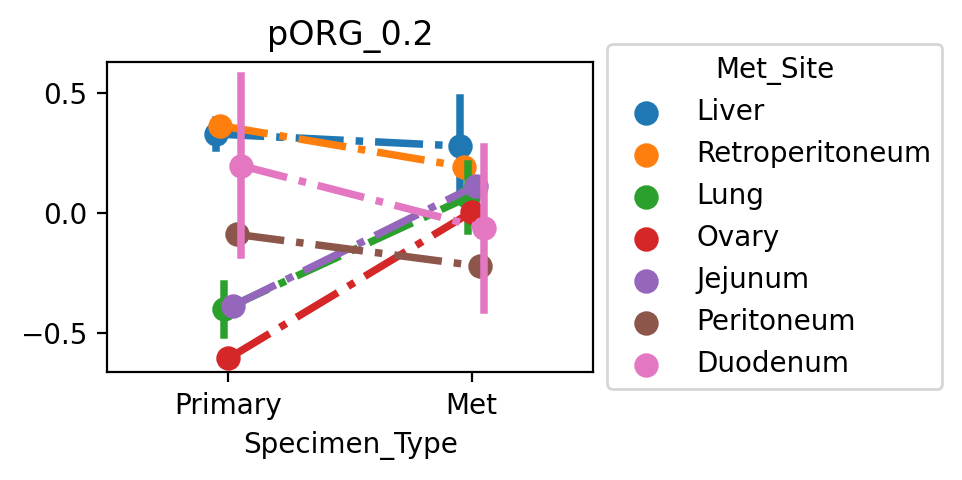

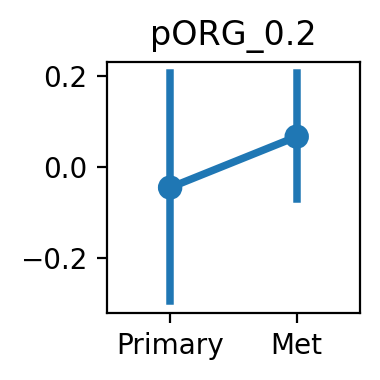

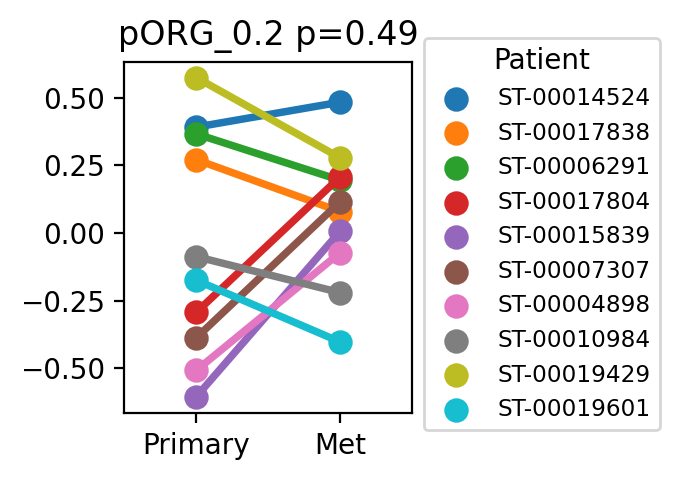

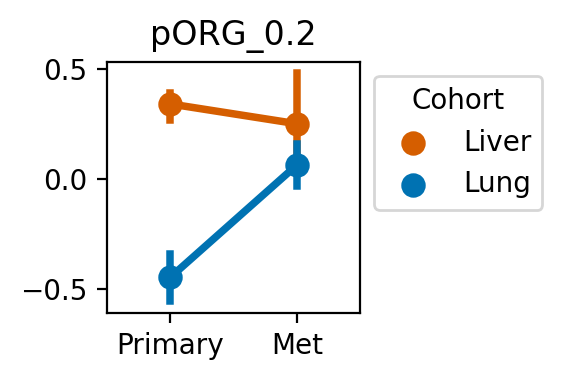

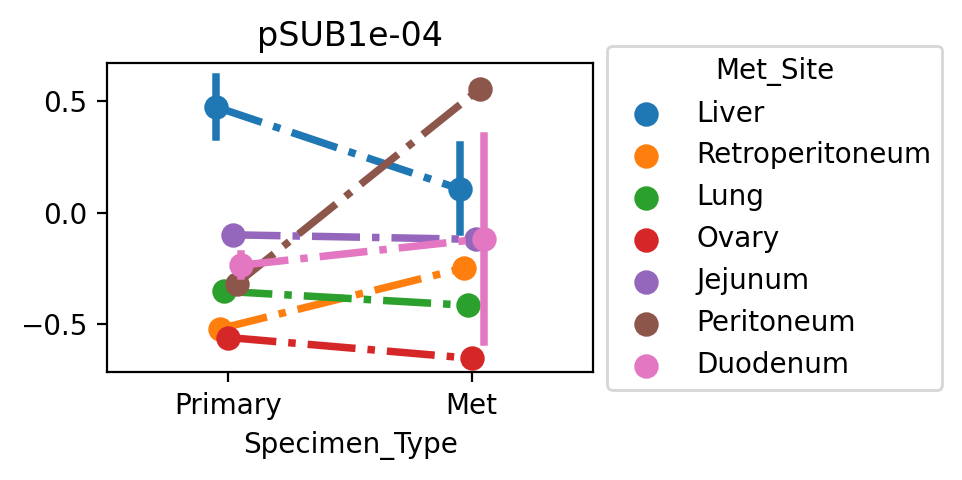

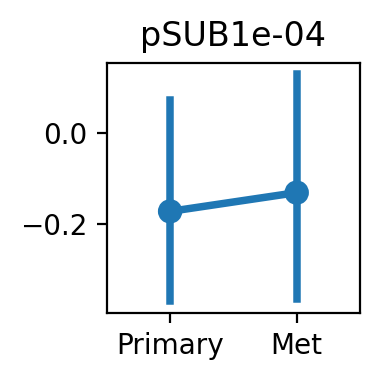

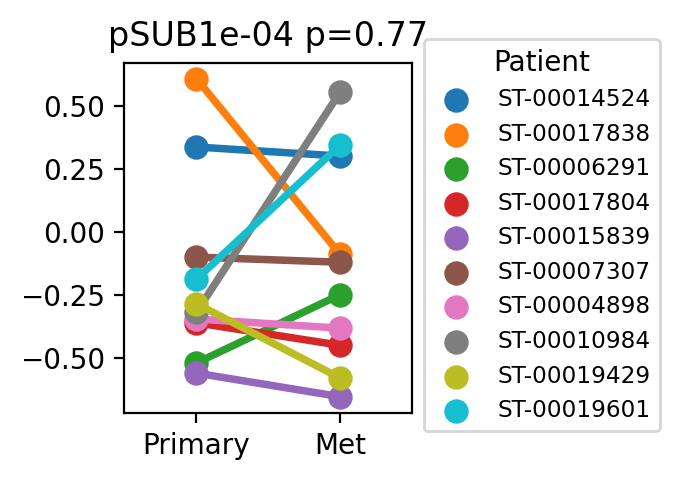

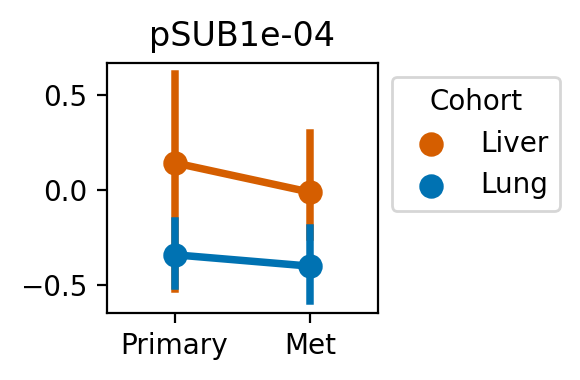

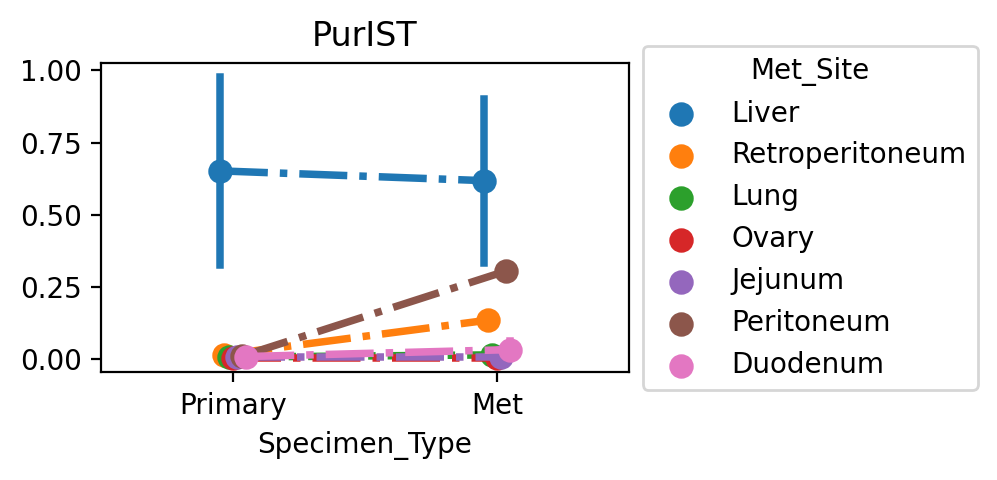

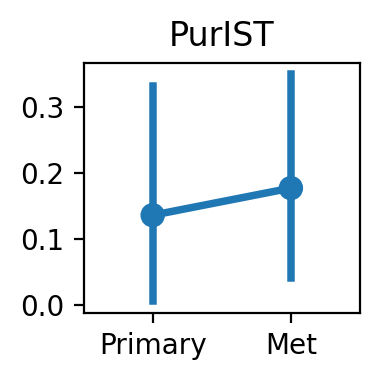

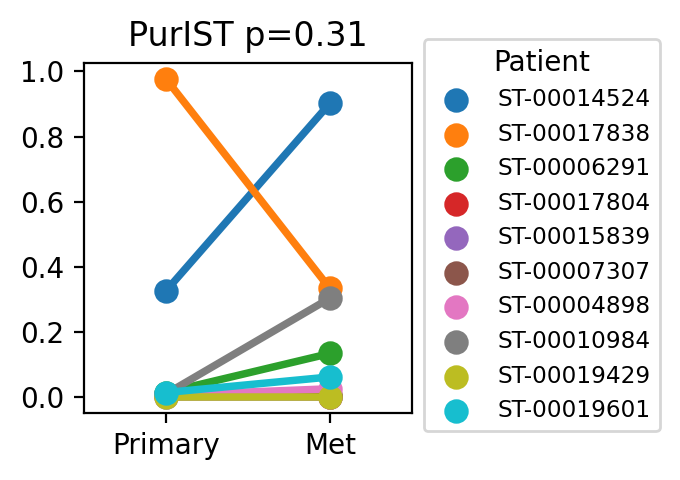

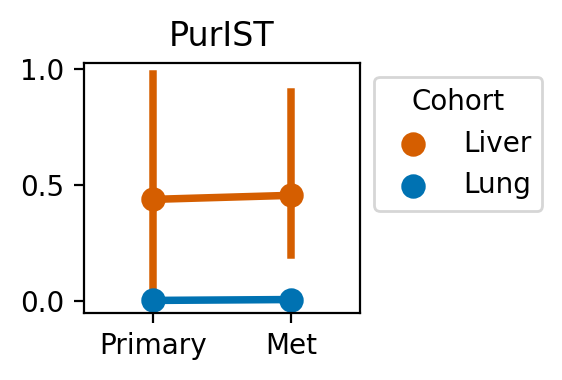

In [341]:
%matplotlib inline
ls_site = [#['pORG_0.2_Primary', 'pORG_0.2_Met'],
           ['pORG_0.2_allPrimary', 'pORG_0.2_allMet'],
['pSUB1e-04_allPrimary', 'pSUB1e-04_allMet'],
 ['PurIST_Primary', 'PurIST_Met'] ]
for tu_site in ls_site:
    df_test = df_patient.loc[:,['Public_Patient_ID']+tu_site].dropna()
    s_value = tu_site[0].replace(f"_{tu_site[0].split('_')[-1]}",'')
    df_test.set_index('Public_Patient_ID',inplace=True)#.stack()
    df_test.columns = [item.split('_')[-1].replace('all','') for item in df_test.columns]
    df_long = df_test.stack().reset_index().rename({'level_1':'Specimen_Type',0:s_value},axis=1)
    df_long['Met_Site'] = df_long.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Specimen_Site_Met)))
    fig,ax=plt.subplots(figsize=(5,2.5),dpi=200)
    sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,hue='Met_Site',
                  dodge=0.1,ax=ax,alpha=0.7,linestyles='-.')
    ax.legend(bbox_to_anchor=(1,1.1),title='Met_Site')
    ax.set_title(s_value)
    ax.set_ylabel('')
    plt.tight_layout()
    # average
    fig,ax=plt.subplots(figsize=(2,2),dpi=200)
    sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,ax=ax)
    ax.set_xlabel('')
    ax.set_title(ax.get_ylabel())
    ax.set_ylabel('')
    plt.tight_layout()
    #by patient
    fig,ax=plt.subplots(figsize=(3.5,2.5),dpi=200)
    sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,hue='Public_Patient_ID',ax=ax)
    ax.set_xlabel('')
    statistic, pvalue = stats.wilcoxon(x=df_test.Primary, y=df_test.Met)
    ax.set_title(f'{ax.get_ylabel()} p={pvalue:.2}')
    ax.set_ylabel('')
    ax.legend(bbox_to_anchor=(1,1.1),title='Patient',fontsize='small')
    plt.tight_layout()
    #by cohort
    df_long['Cohort'] = df_long.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
    fig,ax=plt.subplots(figsize=(3,2),dpi=200)
    sns.pointplot(data=df_long,x='Specimen_Type',y=s_value,hue='Cohort',
                  ax=ax,palette=d_colorblind)
    ax.legend(bbox_to_anchor=(1,1),title='Cohort')
    ax.set_title(s_value)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.tight_layout()
    #break


In [342]:
### overlap in omics data samples
# #the samples overlap/don't overlap in assays
# # all samples 

# from matplotlib_venn import venn3, venn3_circles
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from pyvenn import venn
# d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}annotation/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

# print(d_ids.keys())
# d_keys = {#'OPTR.Specimen.ID':['RnaSeqKey','TcrTumorKey','DnaPanelKey'], #'',
#           'OPTR':['RnaSeqKey','TcrTumorKey','TcrBloodKey','DnaPanelKey'],
#           #'OPTR':['RnaSeqKey','TcrTumorKey','DnaPanelKey'],
#        }

# for s_col ,ls_keys in d_keys.items():
#     d_sets = {}
#     for s_key in ls_keys:
#             print(s_key)
#             print(len(d_ids[s_key]))
#             d_sets.update({s_key:d_ids[s_key]})
#     #plot
#     if len(ls_keys) == 4:
#         labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
#         fig,ax = venn.venn4(labels, names=[key.split('Key')[0] for key, item in d_sets.items()])#,ax=ax
#     elif len(ls_keys) == 3:
#         fig,ax = plt.subplots(figsize=(3,3),dpi=300)
#         venn3([set(item.loc[:,s_col]) for key, item in d_sets.items()], [key.split('Key')[0] for key, item in d_sets.items()],ax=ax)

# # #primaries

# # from matplotlib_venn import venn3, venn3_circles
# # from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# # from pyvenn import venn
# # d_ids = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}annotation/Simplified_Public_IDs_Key.xlsx',sheet_name=None)

# # print(d_ids.keys())
# # d_keys = {#'OPTR.Specimen.ID':['RnaSeqKey','TcrTumorKey','DnaPanelKey'], #'',
# #           #'OPTR':['RnaSeqKey','TcrTumorKey','TcrBloodKey','DnaPanelKey'],
# #           'OPTR':['RnaSeqKey','TcrTumorKey','DnaPanelKey'],
# #        }

# # for s_col ,ls_keys in d_keys.items():
# #     d_sets = {}
# #     for s_key in ls_keys:
# #             print(s_key)
# #             print(len(d_ids[s_key]))
# #             df_set = d_ids[s_key][~d_ids[s_key].loc[:,'OPTR.Specimen.ID'].str.contains('-M')]
# #             d_sets.update({s_key:df_set})
# #     #plot
# #     if len(ls_keys) == 4:
# #         labels = venn.get_labels([set(item.loc[:,s_col]) for key, item in d_sets.items()])
# #         fig,ax = venn.venn4(labels, names=[key.split('Key')[0] for key, item in d_sets.items()],ax=ax)
# #     elif len(ls_keys) == 3:
# #         fig,ax = plt.subplots(figsize=(3,3),dpi=300)
# #         venn3([set(item.loc[:,s_col]) for key, item in d_sets.items()], [key.split('Key')[0] for key, item in d_sets.items()],ax=ax)
# #'''

# Survival Analysis - patients in paper <a name="clin"></a>

KM, CPH


[contents](#contents)



In [362]:
s_out = '20230921_Patient_Metadata.csv'
df_patient = pd.read_csv(s_out,index_col=0)
#add recurrence censor
df_patient.loc[~df_patient.loc[:,'Days from Resection to Recurrence'].isna(),'Recurrence'] = 1
df_patient.loc[df_patient.No_Recurrence,'Recurrence'] = 0
print(len(df_patient))
%matplotlib inline
# add purist subtype
df_patient.loc[(df_patient.PurIST_Primary < 0.5),'PurIST_Subtype'] = 'classical'
df_patient.loc[(df_patient.PurIST_Met < 0.5),'PurIST_Subtype_Met'] = 'classical'
df_patient.loc[(df_patient.PurIST_Primary >= 0.5),'PurIST_Subtype'] = 'basal-like'
df_patient.loc[(df_patient.PurIST_Met >= 0.5),'PurIST_Subtype_Met'] = 'basal-like'
df_patient['PurIST_Subtype'] = df_patient.PurIST_Subtype.fillna(df_patient.PurIST_Subtype_Met)
df_patient.loc[df_patient.PurIST_Subtype=='classical','Classical_Cohort'] = df_patient.loc[df_patient.PurIST_Subtype=='classical','Cohort']
print(df_patient.Classical_Cohort.value_counts())

422
Liver    61
Lung     20
Name: Classical_Cohort, dtype: int64


In [363]:
# matches kevin, 58 liver metastasis 18 lung metastasis 83 no documented recurrence 
#53 other recurrence site 6 no resection
print(df_patient[~df_patient.PurIST_Primary.isna()].Recurrence_Sites_4.value_counts())
print(df_patient[~df_patient.PurIST_Primary_T2.isna()].Recurrence_Sites_4.value_counts())
58 + 18 + 83 + 53 + 6

No_Recurrence    84
Liver            55
Other_site       53
Lung             15
No_Resection      9
Name: Recurrence_Sites_4, dtype: int64
Lung             1
No_Recurrence    1
Name: Recurrence_Sites_4, dtype: int64


218

In [364]:
print(df_patient[~df_patient.loc[:,'pORG_0.2_Met'].isna()].Recurrence_Sites_4.value_counts().sum())

72


In [365]:
#CPH single variable

tu_time_censor = (('Days from Diagnosis to FU','Survival'),
                  ('Days from Resection to Recurrence', 'Recurrence'))
for (s_time, s_censor) in tu_time_censor:
    print(s_censor)
    df_result=pd.DataFrame()
    se_recur = {'Other_Recurrence', 'No_Recurrence','Lung_Cohort','Liver_Cohort'} #don't compare to the 74 with no resection
    ls_vital = ['pORG_0.2_Primary','pORG_0.2_Met','Neoadjuvant','Age','Sex','Stage', 'Grade','LV_Invasion','LN_Pos', #'Age at Diagnosis',
          #'Other_Recurrence', 'No_Recurrence',
                'Classical_Cohort',
                'Lung_Cohort','Liver_Cohort',
               'pSUB1e-04_Primary', 'pSUB1e-04_Met','Classical_Cohort',
           'PurIST_Primary', 'PurIST_Met']
    for s_vital in ls_vital:
        print(s_vital)
        if s_vital == 'Neoadjuvant':
            df = df_patient.loc[(df_patient.Alive_30_days_post_surgery) &(df_patient.Resected),[s_vital,s_time,s_censor]].copy()
        else:
            df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor]].copy()#.dropna(how='any')
        if len(se_recur.intersection(set([s_vital]))):
            df.loc[df_patient.Recurrence_Sites_4=='No_Resection',s_vital] = np.nan
        df = df.dropna()    
        print(len(df))
        #break
        if df.columns.isin(['Stage']).any():
            df.Stage = df.Stage.replace({'I':1,'II':2,'III':3,'IV':4}).astype('int')
        if df.columns.isin(['Grade']).any():
            df.Grade = df.Grade.astype('int')
        if df.loc[:,s_vital].dtype=='O':
            df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
            if df_dummy.shape[1]>0:
                df.drop(s_vital,axis=1,inplace=True)
                df[s_vital] = df_dummy
            else:
                continue
        try: 
            fig, cph = util.cph_plot(df,s_vital,s_time,s_censor,figsize=(3.8,1.5))
            pvalue = cph.summary.p[s_vital]
            plt.tight_layout()
            fig.savefig(f'figures/CPH_single_{s_vital}_{pvalue:.2}_{s_censor}.png')
            #if pvalue > 0.09:
            plt.close(fig)
            df_cph = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
            df_cph['n'] = len(df)
            df_result=pd.concat([df_result,df_cph])
        except:
            print('')
        #break
    #break
    #'''
    #all the recurrence combos
    s_vital = 'Recurrence_Sites_4'
    for tu_combo in combinations(df_patient.Recurrence_Sites_4.unique(),r=2):
        print(tu_combo)
        df = df_patient.loc[(df_patient.Alive_30_days_post_surgery) &(df_patient.Resected),[s_vital,s_time,s_censor]]#.dropna(how='any')
        print(len(df))
        df = df[df.loc[:,s_vital].isin(tu_combo)].dropna()
        #order them
        df.Recurrence_Sites_4 = df.Recurrence_Sites_4.astype('category')
        df.Recurrence_Sites_4 = df.Recurrence_Sites_4.cat.set_categories(sorted(tu_combo))
        df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=False)
        df.drop(s_vital,axis=1,inplace=True)
        s_compare = " to ".join(sorted(tu_combo))
        df[s_compare] = df_dummy.iloc[:,0]
        print(len(df))
        try:
            fig, cph = util.cph_plot(df,s_compare,s_time,s_censor,figsize=(4,1.5))
            plt.tight_layout()
            fig.savefig(f'figures/CPH_single_{s_vital}_{s_compare}_{s_censor}.png')
            plt.close(fig)
            df_cph = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
            df_cph['n'] = len(df)
            df_result=pd.concat([df_result,df_cph])
        except:
            print('cph error')
        #break
        #save results
    df_result.to_csv(f'results/results_single_CPH_{s_censor}.csv')
    #'''
    #break

Survival
pORG_0.2_Primary
208
pORG_0.2_Met
72
Neoadjuvant
289
Age
414
Sex
414
Stage
242
Grade
176
LV_Invasion
197
LN_Pos
237
Classical_Cohort
80
Lung_Cohort
289
Liver_Cohort
289
pSUB1e-04_Primary
208
pSUB1e-04_Met
72
Classical_Cohort
80
PurIST_Primary
208
PurIST_Met
71
('Liver', 'No_Resection')
289
82
cph error
('Liver', 'No_Recurrence')
289
187


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std


('Liver', 'Lung')
289
111
('Liver', 'Other_site')
289
155
('No_Resection', 'No_Recurrence')
289
105
cph error
('No_Resection', 'Lung')
289
29
cph error
('No_Resection', 'Other_site')
289
73
cph error
('No_Recurrence', 'Lung')
289
134
('No_Recurrence', 'Other_site')
289
178


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['No_Recurrence to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Lung to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-pac

('Lung', 'Other_site')
289
102
Recurrence
pORG_0.2_Primary
123
pORG_0.2_Met
14
Neoadjuvant
184
Age
184
Sex
184
Stage
146
Grade
112
LV_Invasion
122
LN_Pos
144
Classical_Cohort
57
Lung_Cohort
184
Liver_Cohort
184
pSUB1e-04_Primary
123
pSUB1e-04_Met
14
Classical_Cohort
57
PurIST_Primary
123
PurIST_Met
14
('Liver', 'No_Resection')
289
82
cph error
('Liver', 'No_Recurrence')
289
82
cph error
('Liver', 'Lung')
289
111
('Liver', 'Other_site')
289
155


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Recurrence'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/

('No_Resection', 'No_Recurrence')
289
0
cph error
('No_Resection', 'Lung')
289
29
cph error
('No_Resection', 'Other_site')
289
73
cph error
('No_Recurrence', 'Lung')
289
29
cph error
('No_Recurrence', 'Other_site')
289
73
cph error
('Lung', 'Other_site')
289
102


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Lung to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['No_Resection to Other_site'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packag

In [366]:
#genes
ls_vital = ls_genes

#CPH single variable

tu_time_censor = (('Days from Diagnosis to FU','Survival'),
                  ('Days from Resection to Recurrence', 'Recurrence'))
for (s_time, s_censor) in tu_time_censor:
    print(s_censor)
    df_result=pd.DataFrame()
    se_recur = {'Other_Recurrence', 'No_Recurrence','Lung_Cohort','Liver_Cohort'}
    for s_vital in ls_vital:
        print(s_vital)
        df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor]].copy()#.dropna(how='any')
        df = df.dropna()    
        print(len(df))
        if df.loc[:,s_vital].dtype=='O':
            df_dummy = pd.get_dummies(df.loc[:,[s_vital]],drop_first=True)
            if df_dummy.shape[1]>0:
                df.drop(s_vital,axis=1,inplace=True)
                df[s_vital] = df_dummy
            else:
                continue
        try: 
            fig, cph = util.cph_plot(df,s_vital,s_time,s_censor,figsize=(3.8,1.5))
            pvalue = cph.summary.p[s_vital]
            plt.tight_layout()
            fig.savefig(f'figures/CPH_single_{s_vital}_{pvalue:.2}_{s_censor}.png')
            #if pvalue > 0.09:
            plt.close(fig)
            df_cph = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
            df_cph['n'] = len(df)
            df_result=pd.concat([df_result,df_cph])
        except:
            print('')
        #save results
    df_result.to_csv(f'results/results_single_CPH_{s_censor}_gene_alterations.csv')
    #'''
    #break

Survival
RNF43_Altered_Primary
194
RNF43_Altered_Met
68
RNF43_Altered
252
TP53_Altered_Primary
194
TP53_Altered_Met
68
TP53_Altered
252
GNAS_Altered_Primary
194
GNAS_Altered_Met
68
GNAS_Altered
252
KRAS_Altered_Primary
194
KRAS_Altered_Met
68
KRAS_Altered
252
APOB_Altered_Primary
194
APOB_Altered_Met
68
APOB_Altered
252
SMAD4_Altered_Primary
194
SMAD4_Altered_Met
68
SMAD4_Altered
252
BRCA1_Altered_Primary
194
BRCA1_Altered
252
CDKN2A_Altered_Primary
194
CDKN2A_Altered_Met
68
CDKN2A_Altered
252
NOTCH1_Altered_Primary
194
NOTCH1_Altered_Met
68
NOTCH1_Altered
252
BCOR_Altered_Primary
194
BCOR_Altered_Met
68
BCOR_Altered
252
STK11_Altered_Primary
194
STK11_Altered_Met
68

STK11_Altered
252
TGFBR2_Altered_Primary
194


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1731: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1727: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter

TGFBR2_Altered_Met
68
TGFBR2_Altered
252
ARID1B_Altered_Primary
194
ARID1B_Altered_Met
68
ARID1B_Altered
252
TSC2_Altered_Primary
194
TSC2_Altered_Met
68
TSC2_Altered
252
ATRX_Altered_Primary
194
ATRX_Altered_Met
68
ATRX_Altered
252
KDM6A_Altered_Primary
194
KDM6A_Altered_Met
68
KDM6A_Altered
252
ATM_Altered_Primary
194
ATM_Altered_Met
68
ATM_Altered
252
LRP1B_Altered_Primary
194
LRP1B_Altered_Met
68
LRP1B_Altered
252
ARID1A_Altered_Primary
194
ARID1A_Altered_Met
68
ARID1A_Altered
252
CUX1_Altered_Primary
194
CUX1_Altered_Met
68
CUX1_Altered
252
KMT2A_Altered_Primary
194
KMT2A_Altered_Met
68
KMT2A_Altered
252
KMT2D_Altered_Primary
194
KMT2D_Altered_Met
68
KMT2D_Altered
252
PBRM1_Altered_Primary
194
PBRM1_Altered_Met
68
PBRM1_Altered
252
BRCA2_Altered_Primary
194
BRCA2_Altered_Met
68
BRCA2_Altered
252
GATA1_Altered_Primary
194
GATA1_Altered_Met
68
GATA1_Altered
252
KDM5C_Altered_Primary
194
KDM5C_Altered_Met
68
KDM5C_Altered
252
RBM10_Altered_Primary
194
RBM10_Altered_Met
68
RBM10_Alter

/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column PBRM1_Altered_Met has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.289. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


PBRM1_Altered
120
BRCA2_Altered_Primary
115
BRCA2_Altered_Met
12
BRCA2_Altered
120
GATA1_Altered_Primary
115
GATA1_Altered_Met
12


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.289. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


GATA1_Altered
120
KDM5C_Altered_Primary
115
KDM5C_Altered_Met
12
KDM5C_Altered
120


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.289. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


RBM10_Altered_Primary
115
RBM10_Altered_Met
12
RBM10_Altered
120
SMARCB1_Altered_Primary
115
SMARCB1_Altered_Met
12
SMARCB1_Altered
120
ELF3_Altered_Primary
115
ELF3_Altered_Met
12
ELF3_Altered
120
MTAP_Altered_Primary
115
MTAP_Altered_Met
12
MTAP_Altered
120
BRAF_Altered_Primary
115
BRAF_Altered_Met
12
BRAF_Altered
120
CREBBP_Altered_Primary
115
CREBBP_Altered_Met
12
CREBBP_Altered
120
CDKN2B_Altered_Primary
115
CDKN2B_Altered_Met
12
CDKN2B_Altered
120


## multivariable

In [350]:
df_patient.Recurrence_Sites_4.value_counts()

No_Resection     125
No_Recurrence    113
Liver             82
Other_site        73
Lung              29
Name: Recurrence_Sites_4, dtype: int64

Survival
PurIST_Primary
132
pORG_0.2_Primary
132
pSUB1e-04_Primary
132
Liver_Cohort
149
Classical_Cohort
36
Lung_Cohort
149
('Liver', 'No_Resection')
43
cph error
('Liver', 'No_Recurrence')
98


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column Stage have very low variance when conditioned on death event present or not. This may harm convergence. This

('Liver', 'Lung')
54
('Liver', 'Other_site')
83
('No_Resection', 'No_Recurrence')
55
cph error
('No_Resection', 'Lung')
11
cph error
('No_Resection', 'Other_site')
40
cph error
('No_Recurrence', 'Lung')
66


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['No_Recurrence to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Stage', 'Lung to No_Resection'] have very low variance. This may harm convergence. 1) Are you u

('No_Recurrence', 'Other_site')
95
('Lung', 'Other_site')
51
PurIST_Primary
193
pORG_0.2_Primary
193
pSUB1e-04_Primary
193
Liver_Cohort
252
Classical_Cohort
76
Lung_Cohort
252
('Liver', 'No_Resection')
46


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1733: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1735: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: divide by zero encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1700: RuntimeWarning: invalid value encountered in add
  risk_phi_x = risk_phi_x + phi_x_i
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitter

cph error
('Liver', 'No_Recurrence')
92
('Liver', 'Lung')
54
('Liver', 'Other_site')
85
('No_Resection', 'No_Recurrence')
50


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['ARID1B_Altered_True', 'MTAP_Altered_True'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column No_Recurrence to No_Resection have very low variance when conditioned on death event pres

cph error
('No_Resection', 'Lung')
12
cph error
('No_Resection', 'Other_site')
43
cph error
('No_Recurrence', 'Lung')
58
('No_Recurrence', 'Other_site')
89
cph error
('Lung', 'Other_site')
51
cph error
Recurrence
PurIST_Primary
84


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['ARID1B_Altered_True'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column KMT2D_Altered_True have very low variance when conditioned on death event present or not. This may harm conver

pORG_0.2_Primary
84
pSUB1e-04_Primary
84
Liver_Cohort
94
Classical_Cohort
35
Lung_Cohort
94
('Liver', 'No_Resection')
43
cph error
('Liver', 'No_Recurrence')
43


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Recurrence'] have very low variance. This may harm convergence. 1) Are you using formula's?

cph error
('Liver', 'Lung')
54
('Liver', 'Other_site')
83
('No_Resection', 'No_Recurrence')
0
cph error
('No_Resection', 'Lung')
11
cph error
('No_Resection', 'Other_site')
40
cph error
('No_Recurrence', 'Lung')
11
cph error
('No_Recurrence', 'Other_site')
40
cph error
('Lung', 'Other_site')
51


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Stage', 'Lung to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column Stage has high sample correlation with the duration column. This may harm convergence. This could be

PurIST_Primary
115
pORG_0.2_Primary
115
pSUB1e-04_Primary
115
Liver_Cohort
120
Classical_Cohort
54
Lung_Cohort
120
('Liver', 'No_Resection')
44
cph error
('Liver', 'No_Recurrence')
44
cph error
('Liver', 'Lung')
54


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Resection'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Liver to No_Recurrence'] have very low variance. This may harm convergence. 1) Are you using formula's?

('Liver', 'Other_site')
85
('No_Resection', 'No_Recurrence')
0
cph error
('No_Resection', 'Lung')
10
cph error
('No_Resection', 'Other_site')
41
cph error
('No_Recurrence', 'Lung')
10
cph error
('No_Recurrence', 'Other_site')
41
cph error
('Lung', 'Other_site')
51
cph error


/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['Lung to No_Resection', 'KMT2D_Altered_True'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:800: RuntimeWarning: invalid value encountered in divide
  return (X - mean) / std
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1740: RuntimeWarning: invalid value encountered in log
  log_lik = log_lik + dot(x_death_sum, beta) + weighted_average * log(denom).sum()
/Users/engje/miniconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column Lung to No_Resection has high sample correlation with the duration column. This may har

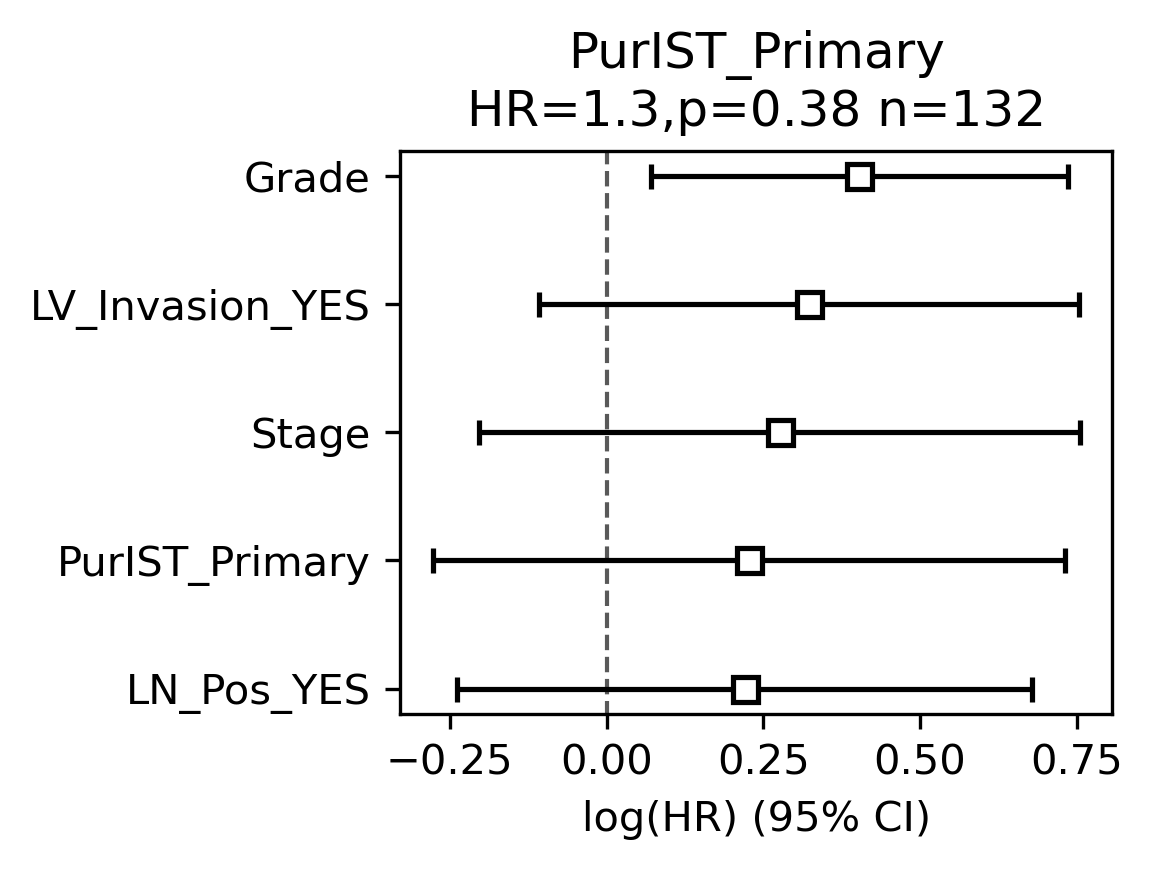

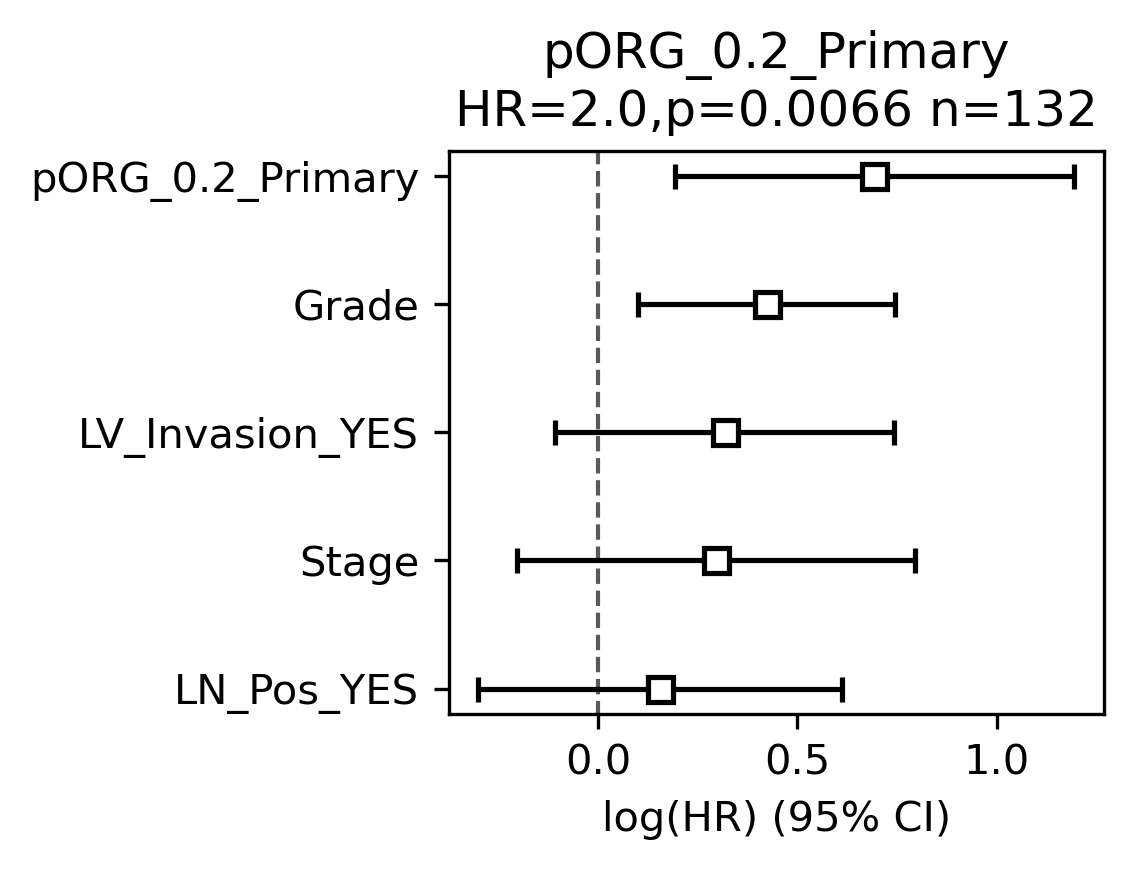

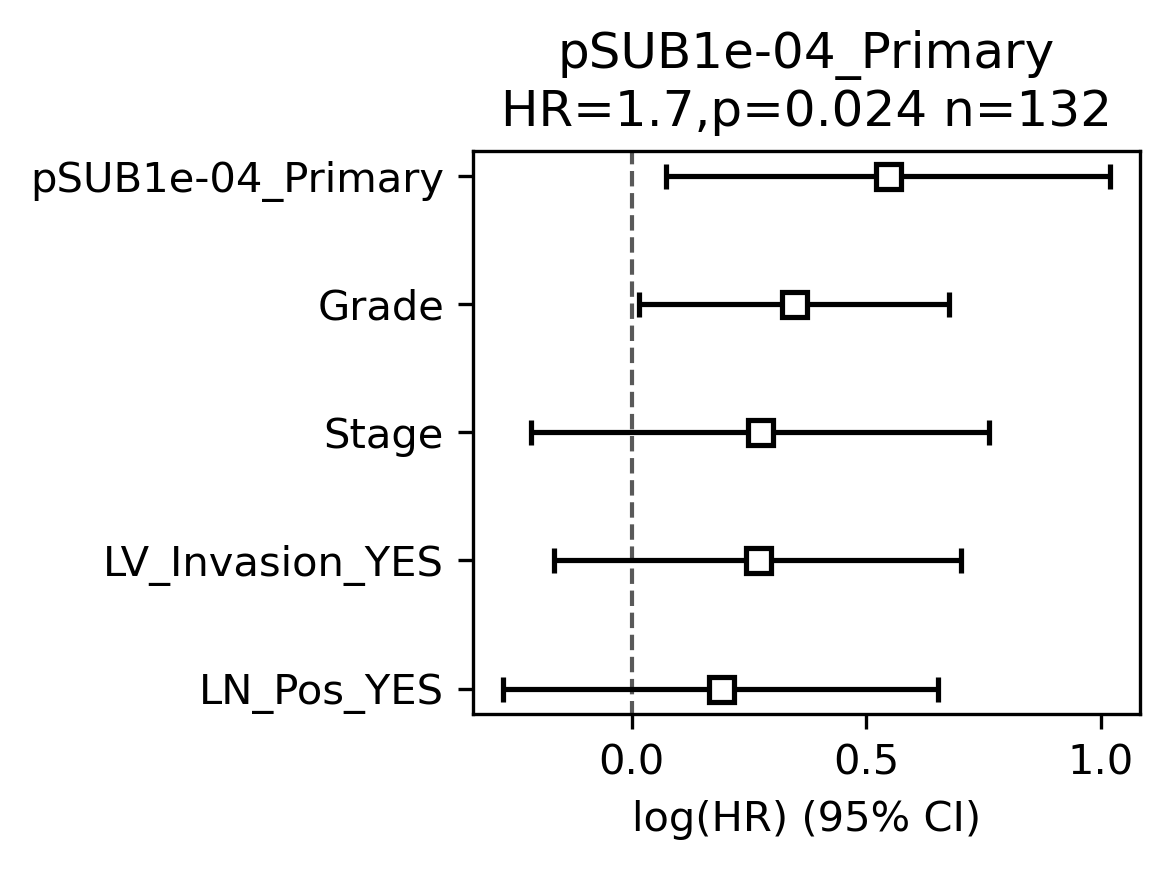

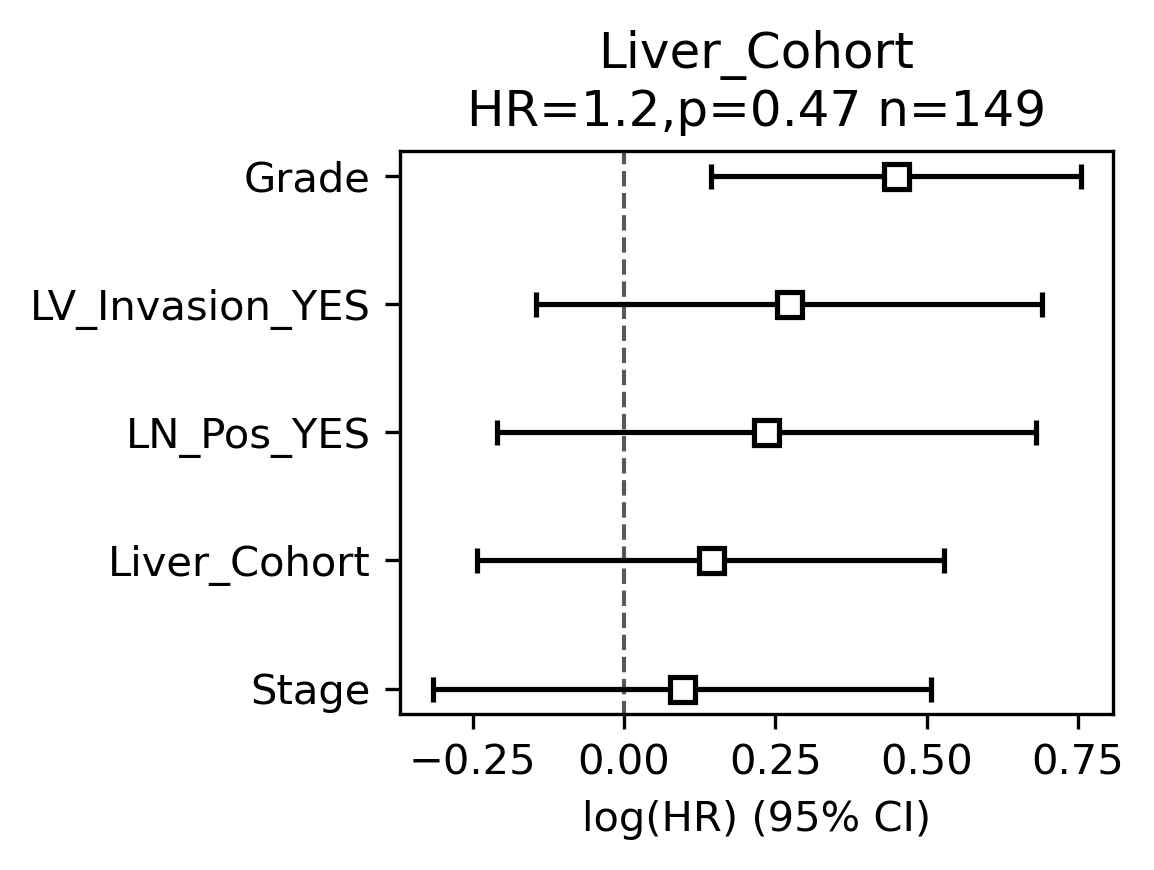

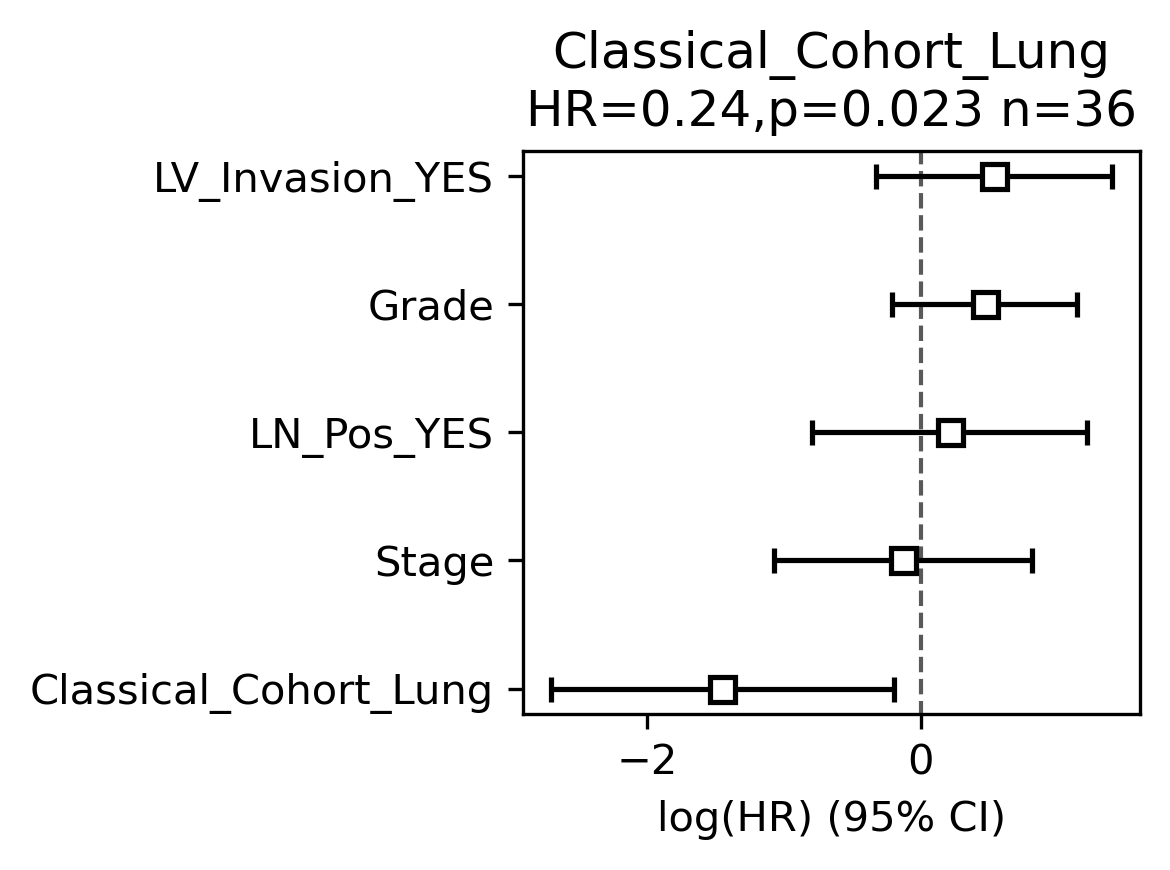

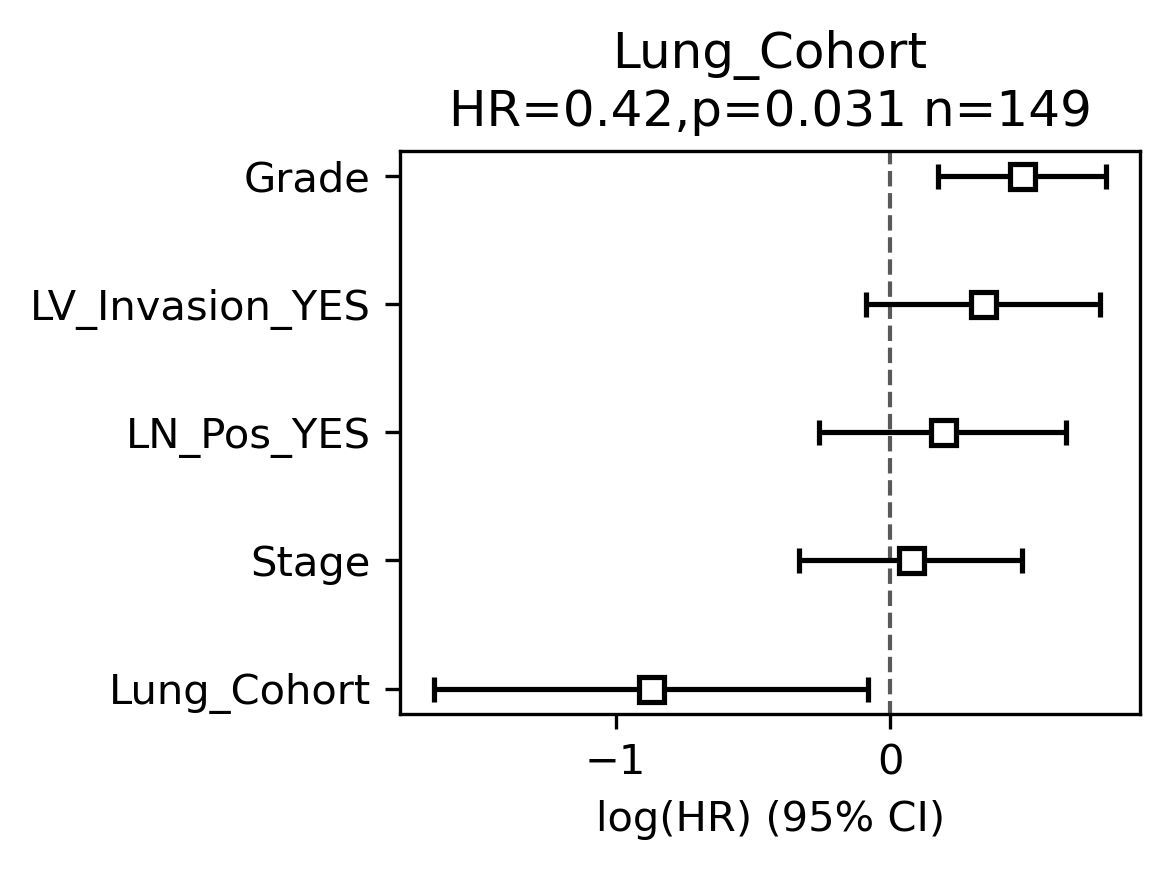

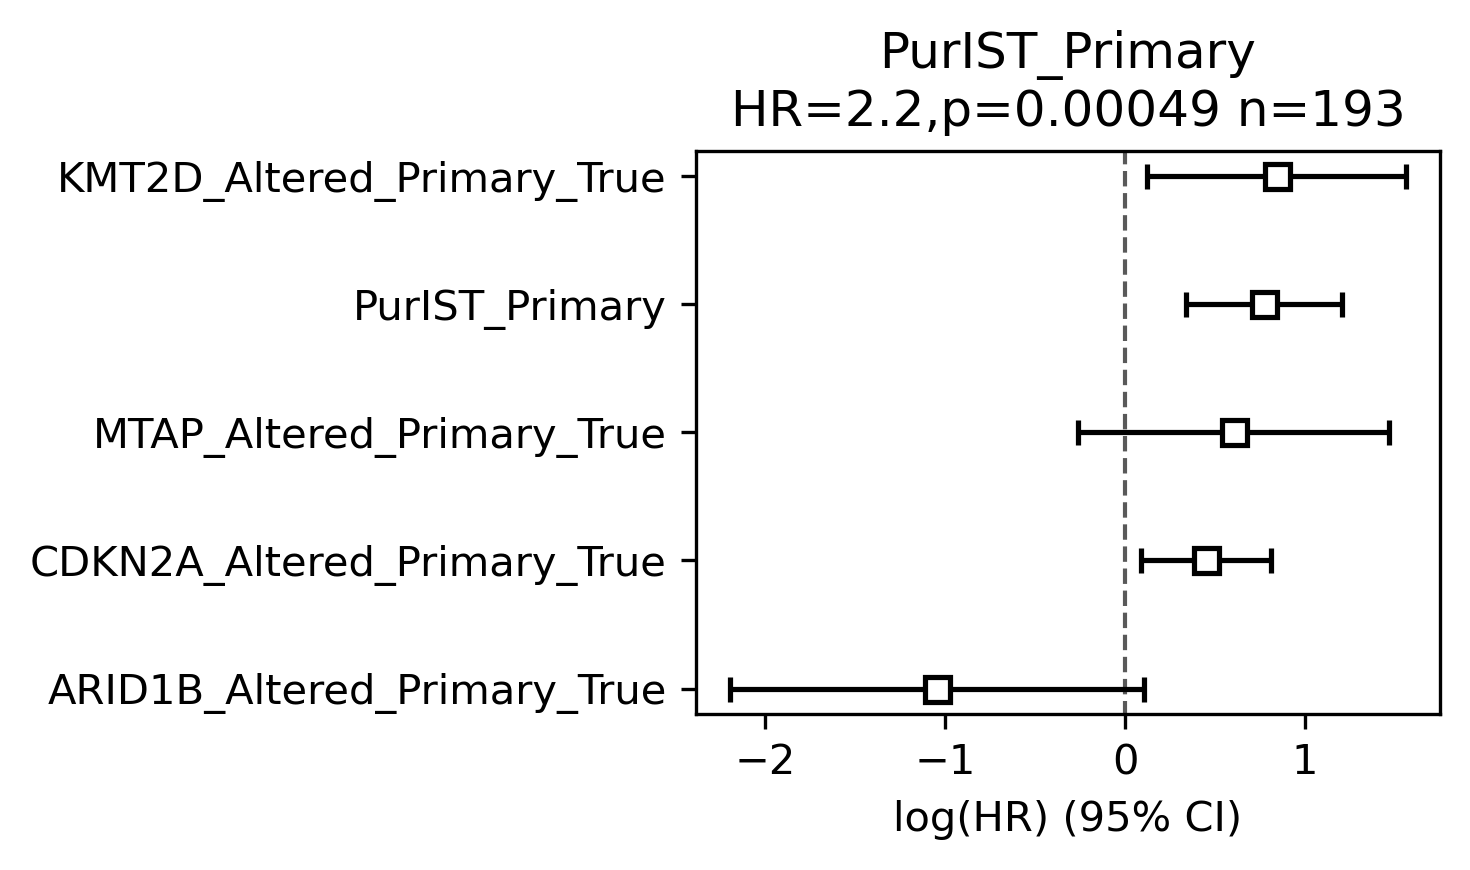

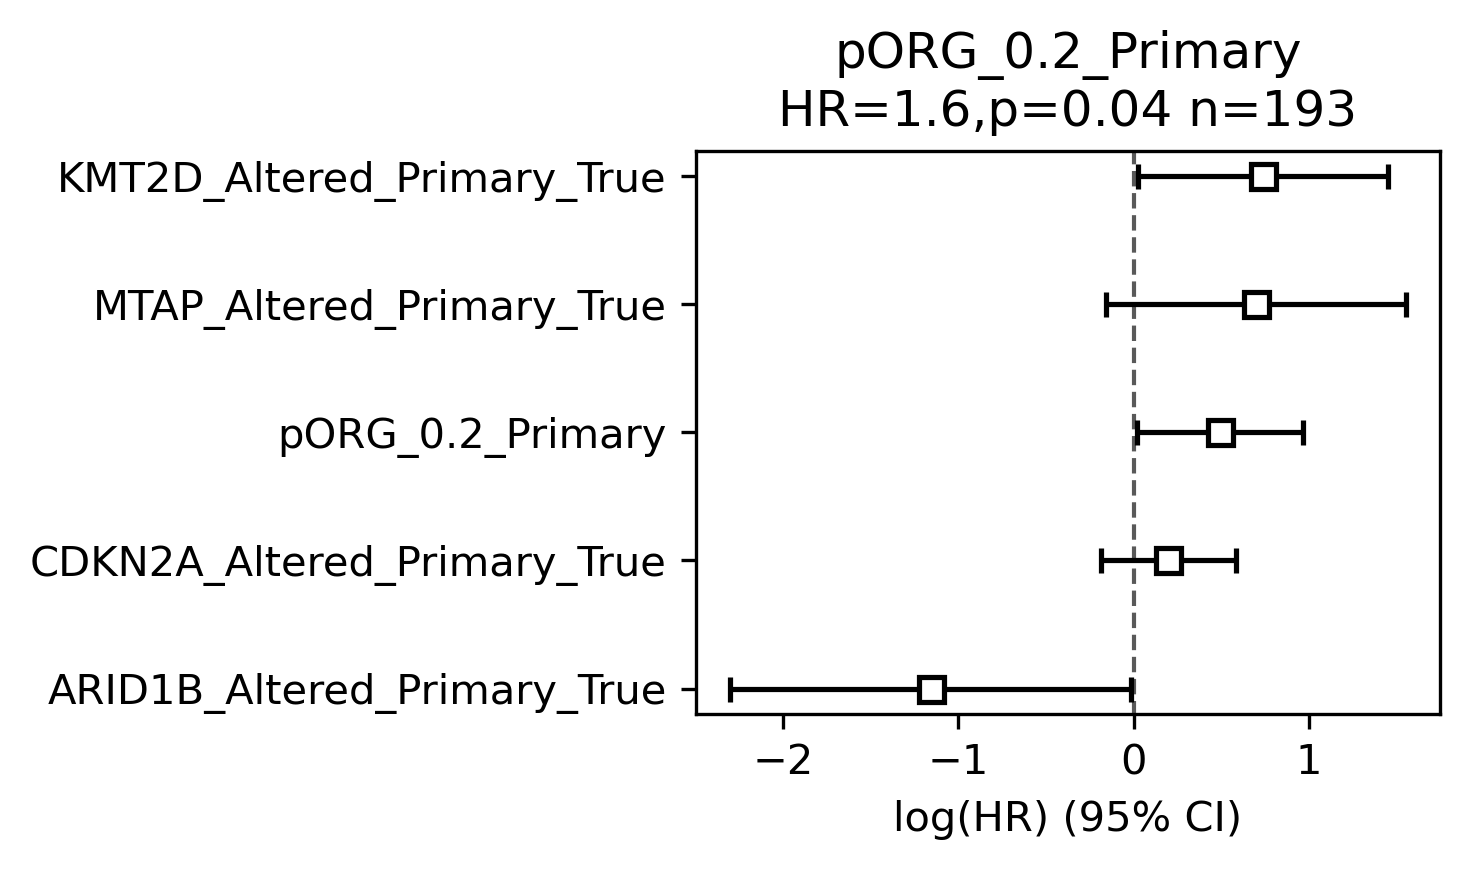

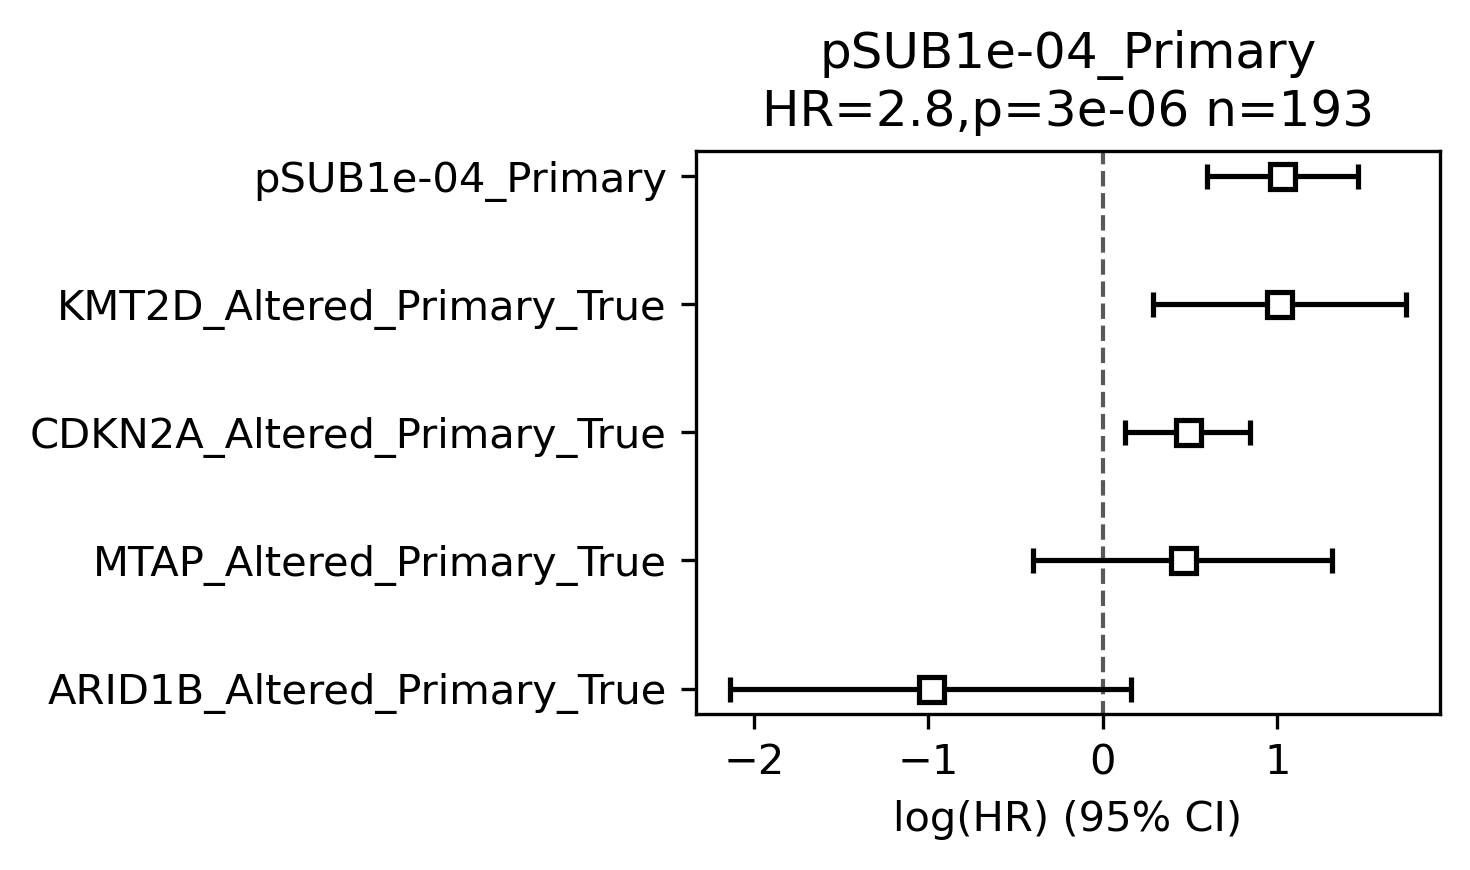

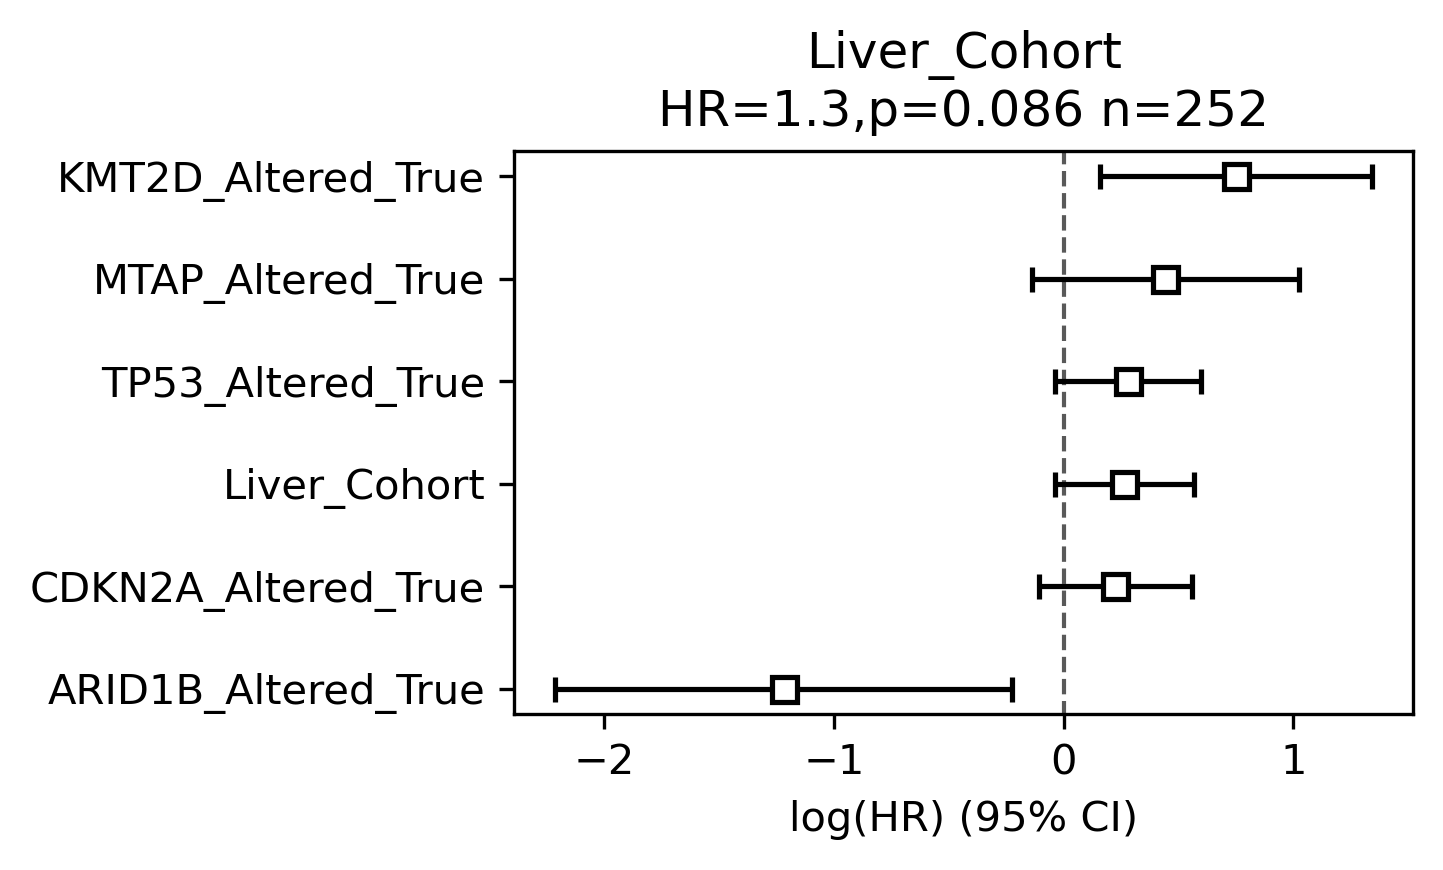

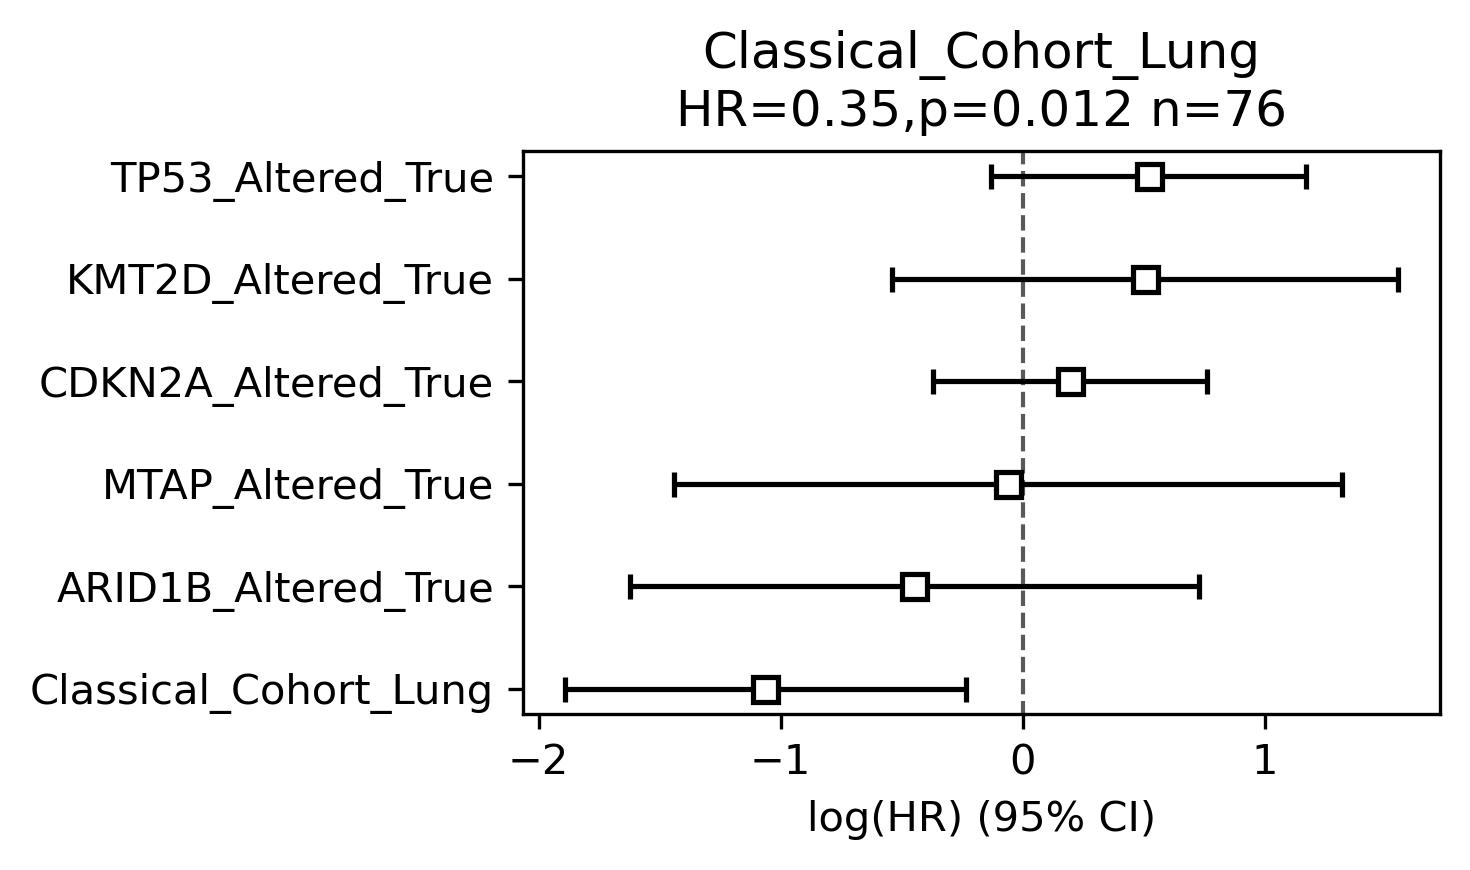

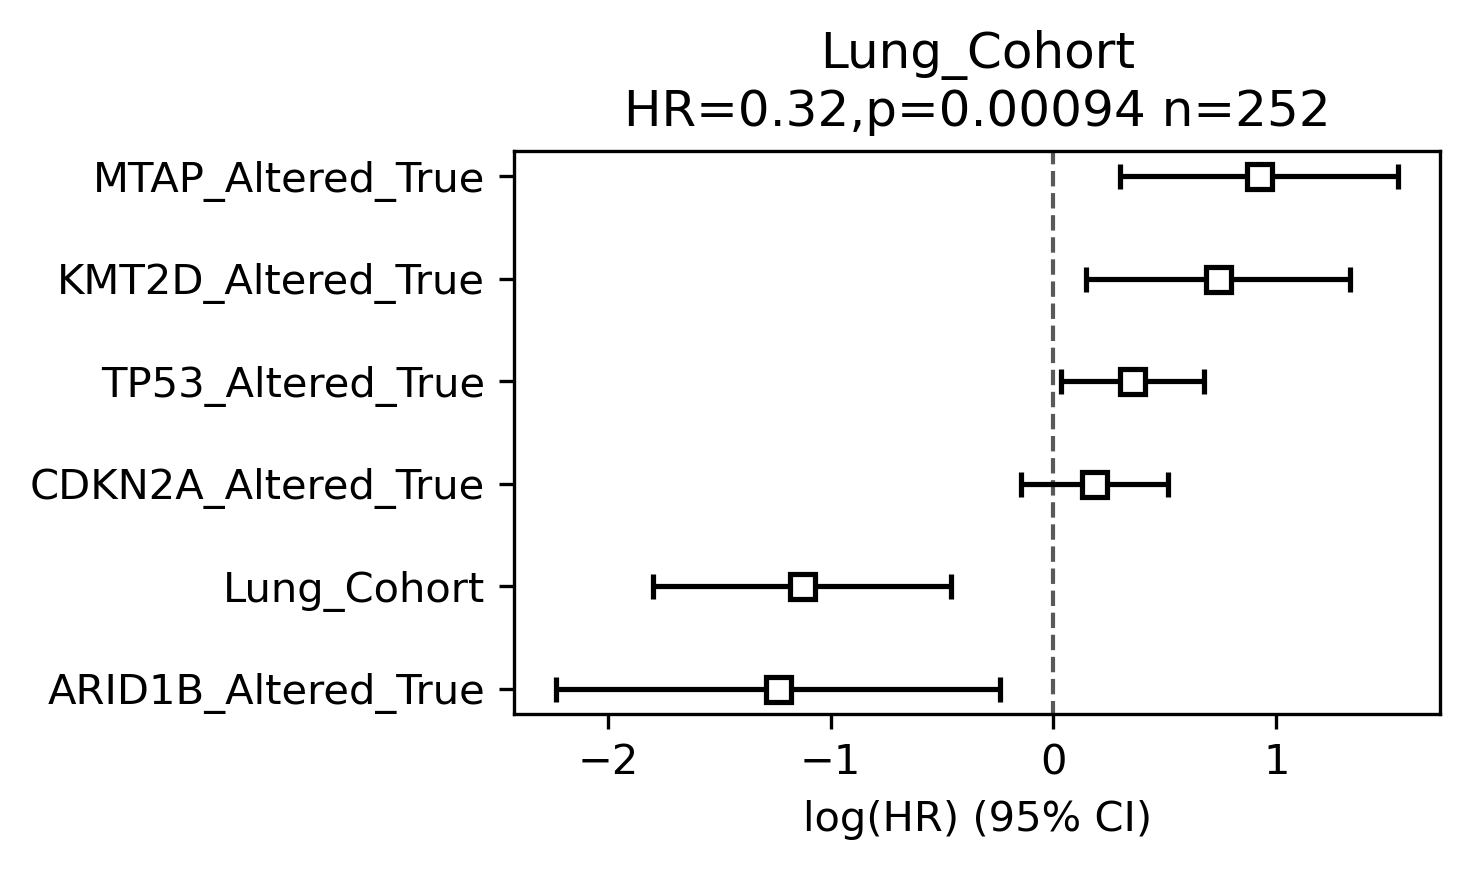

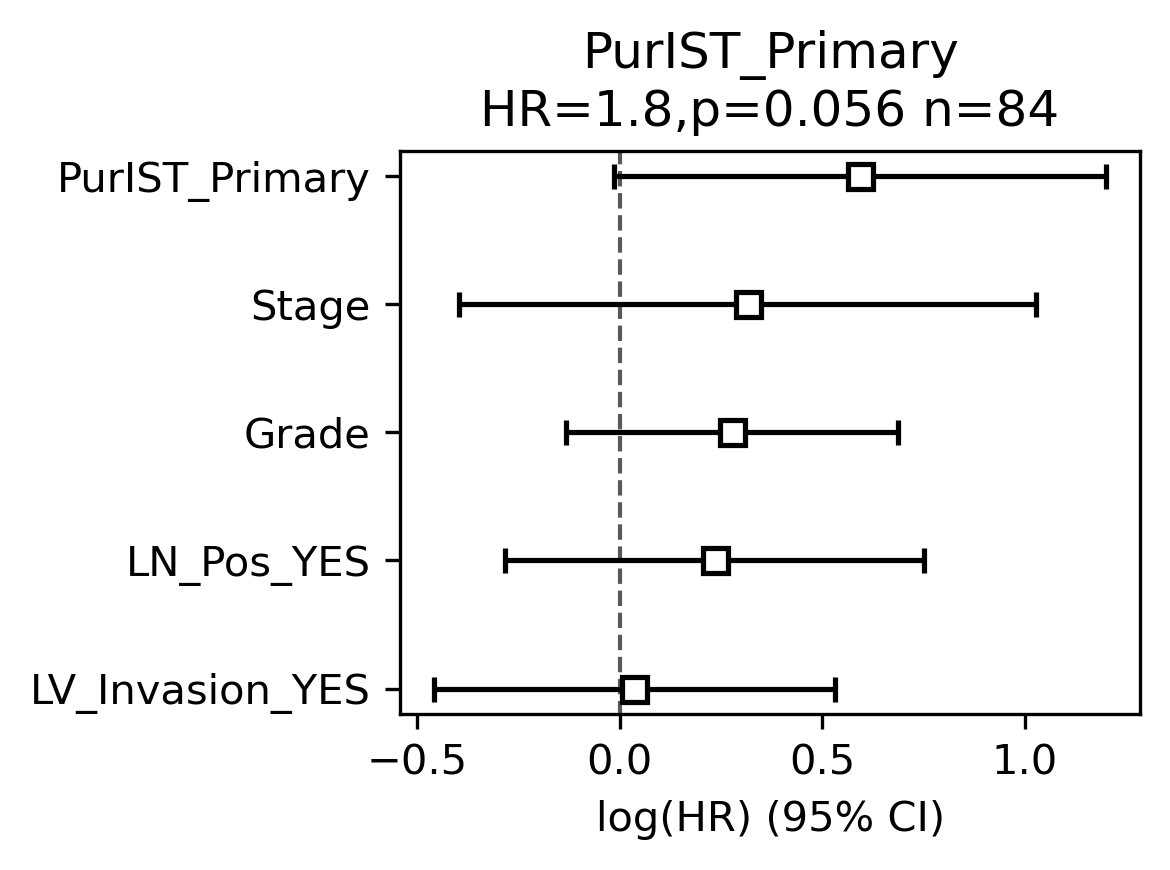

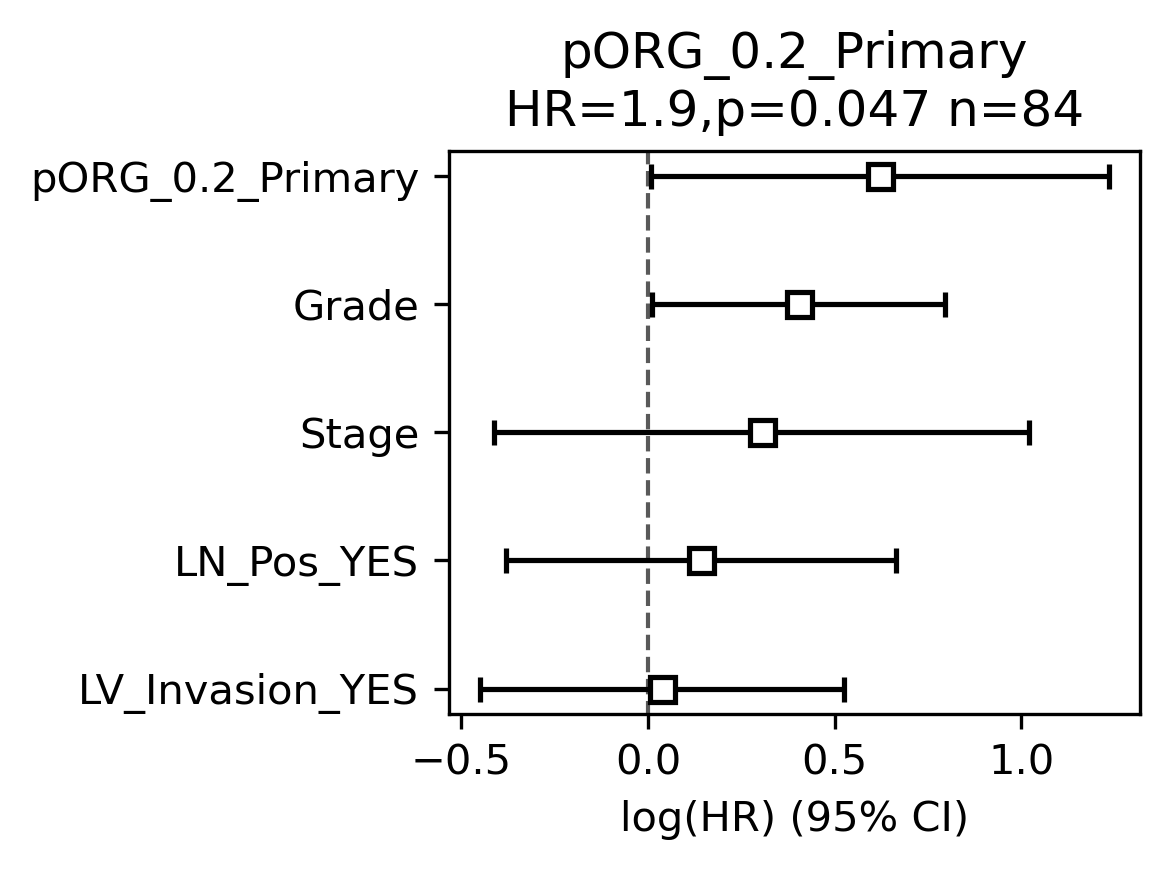

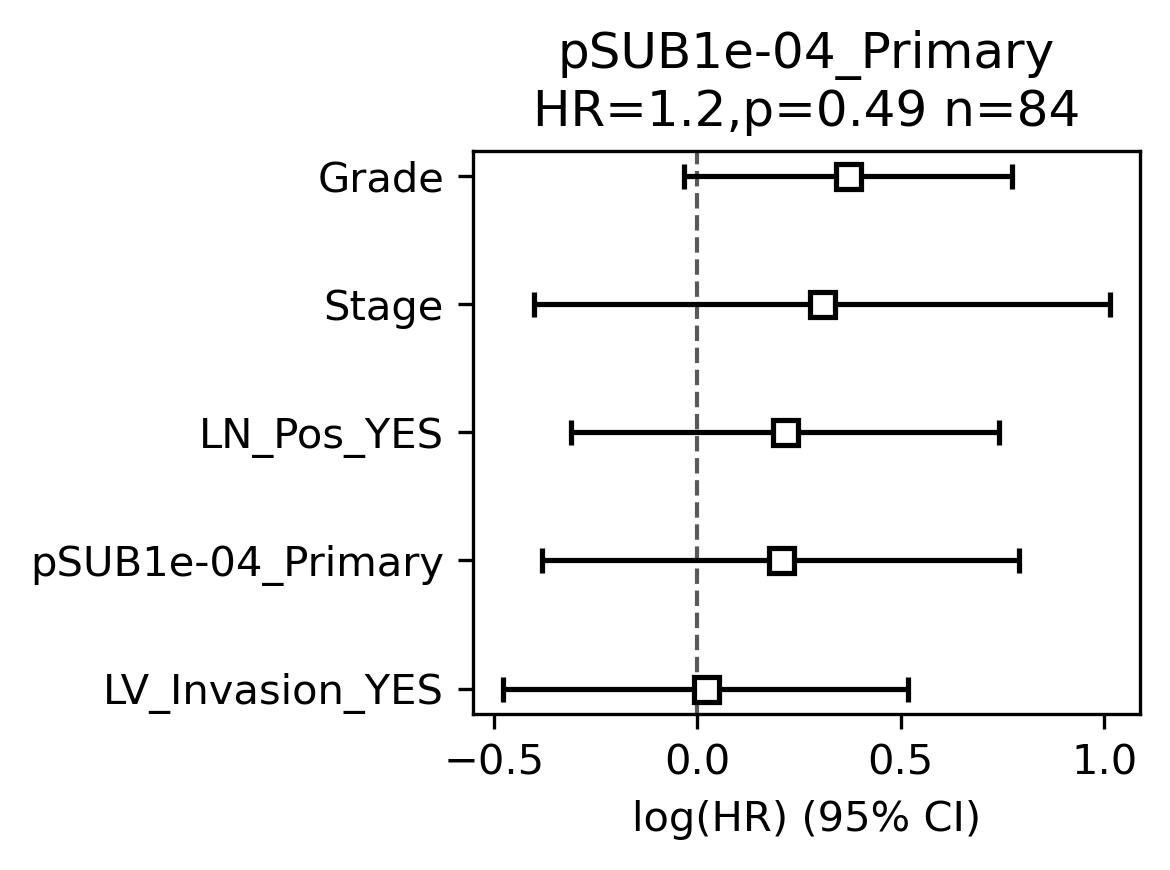

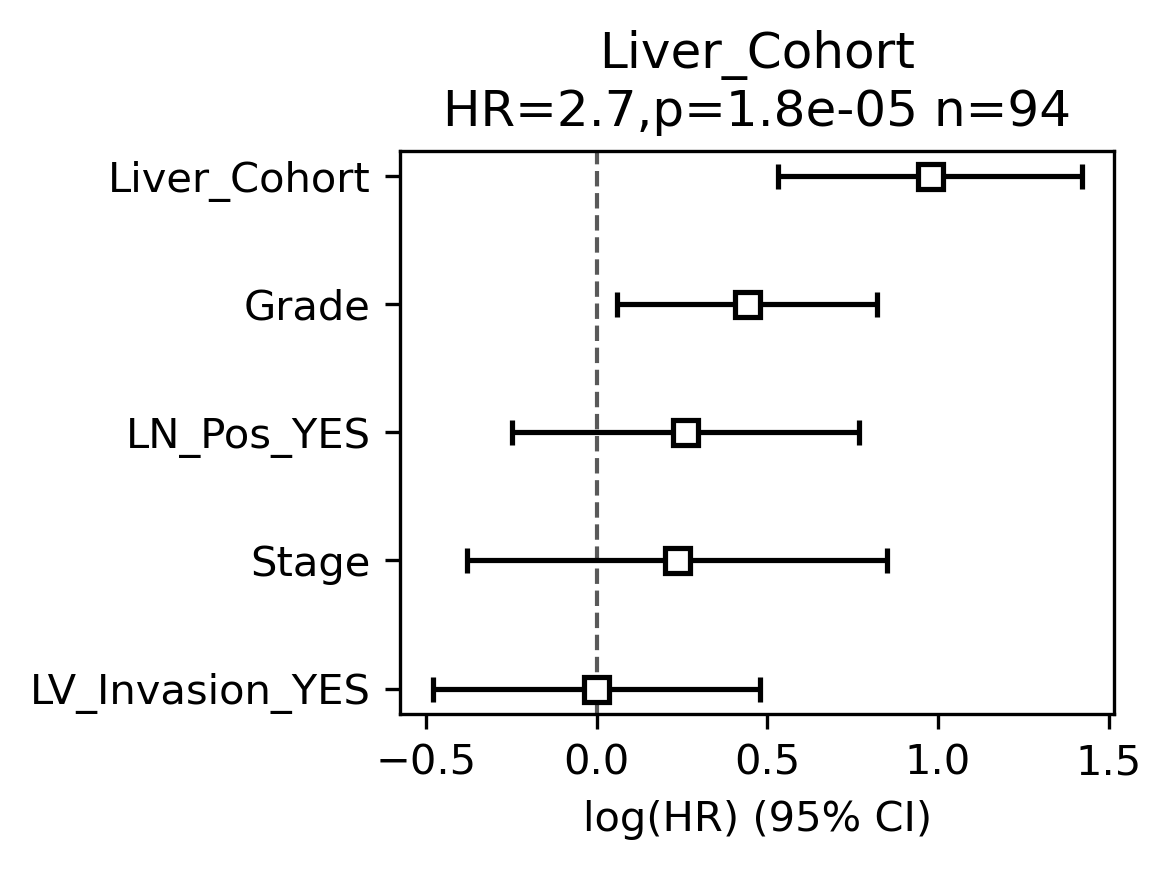

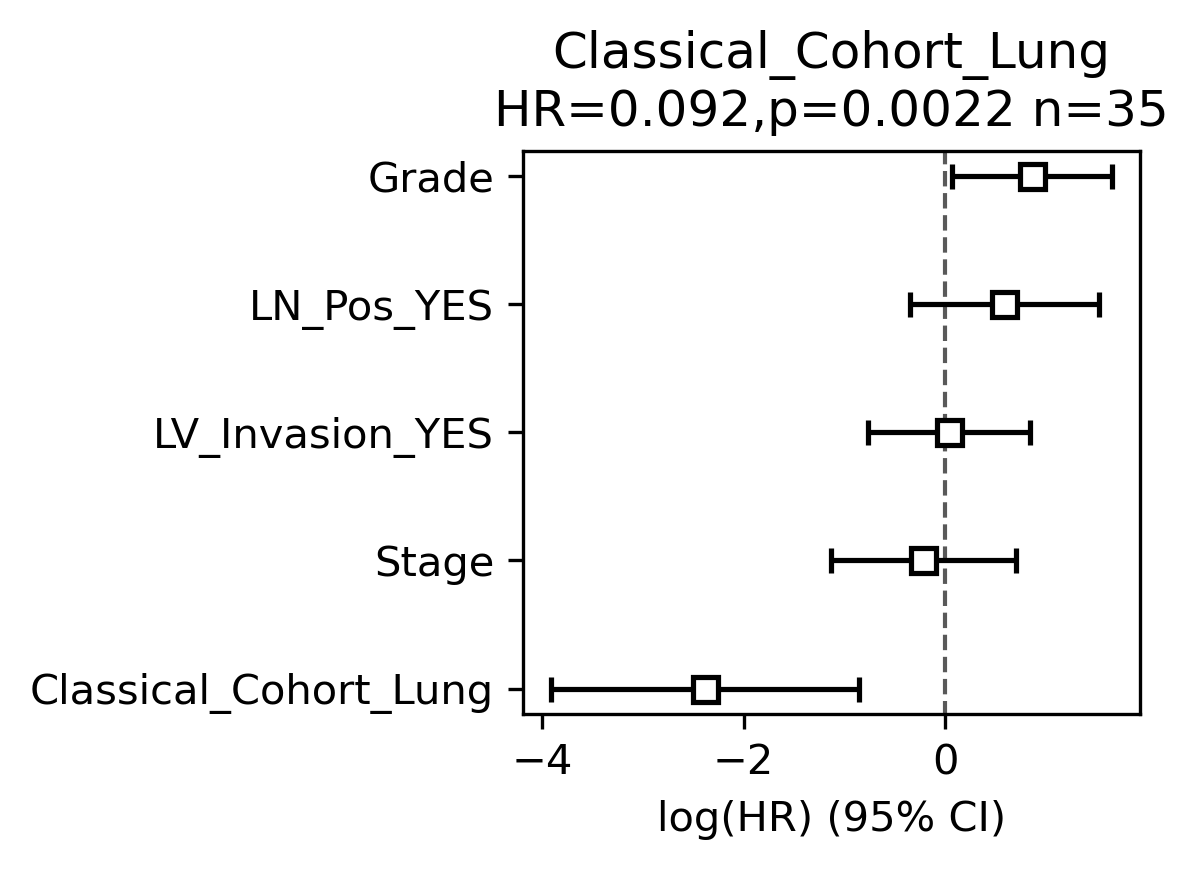

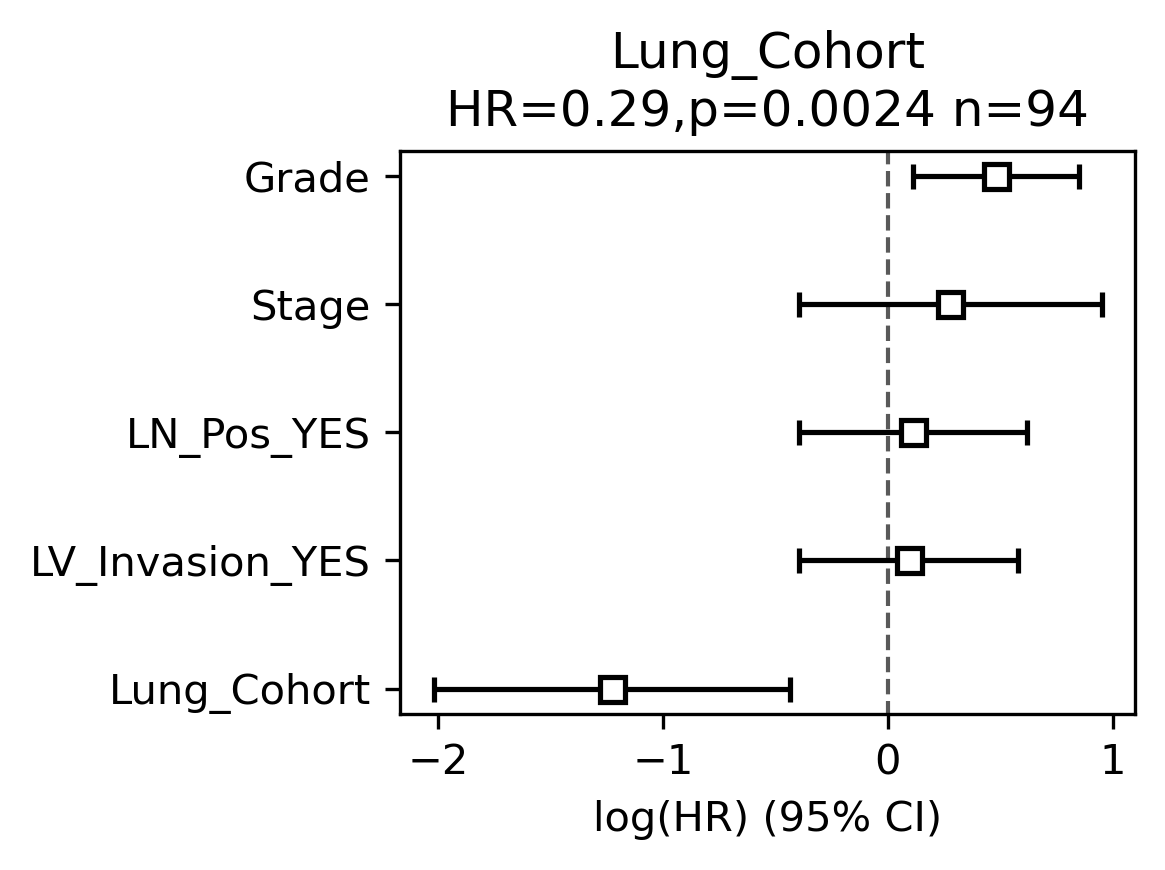

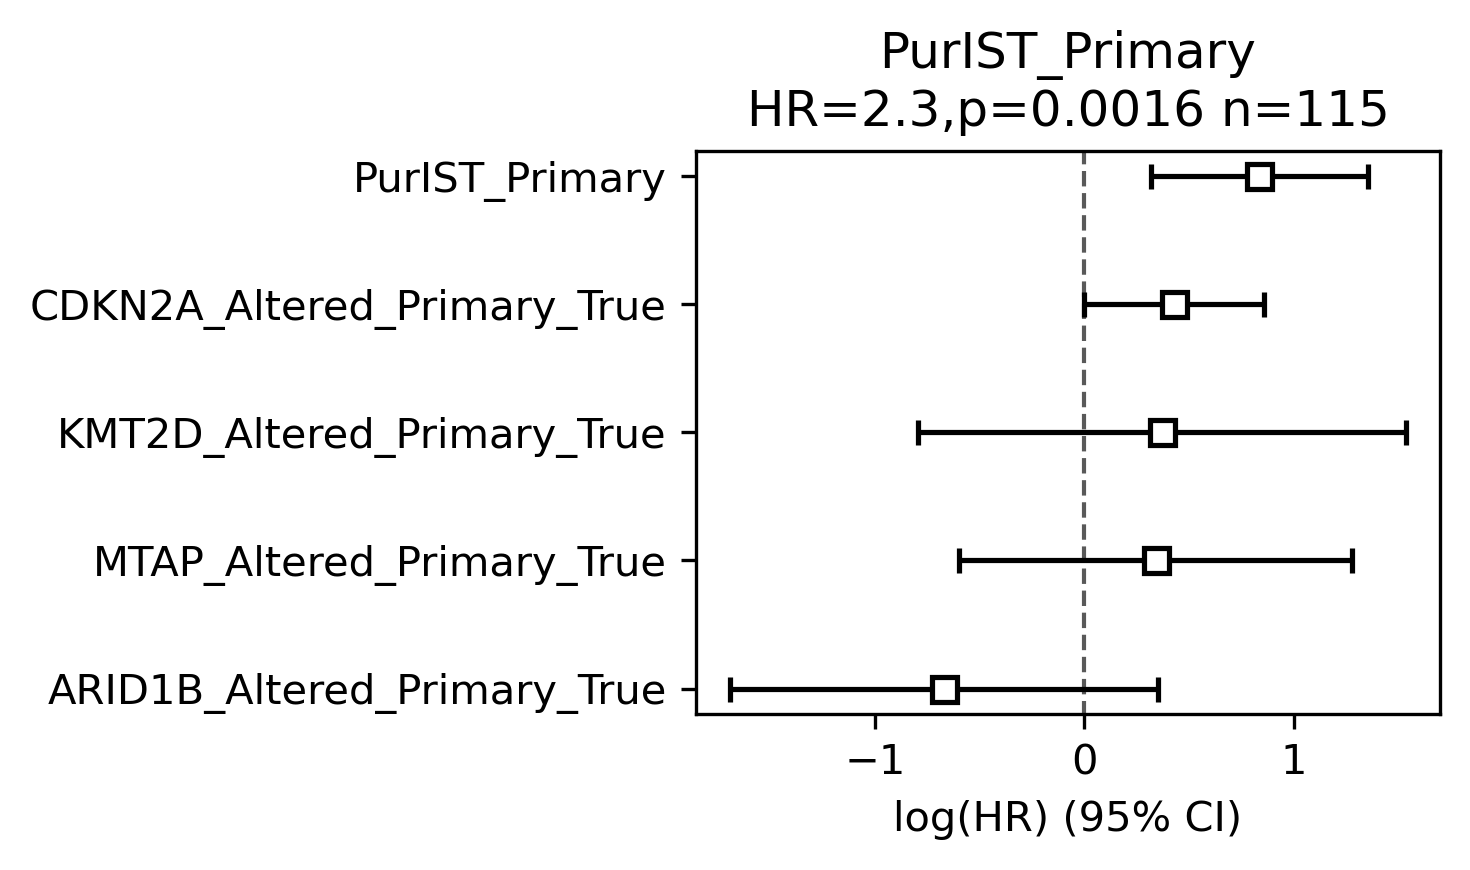

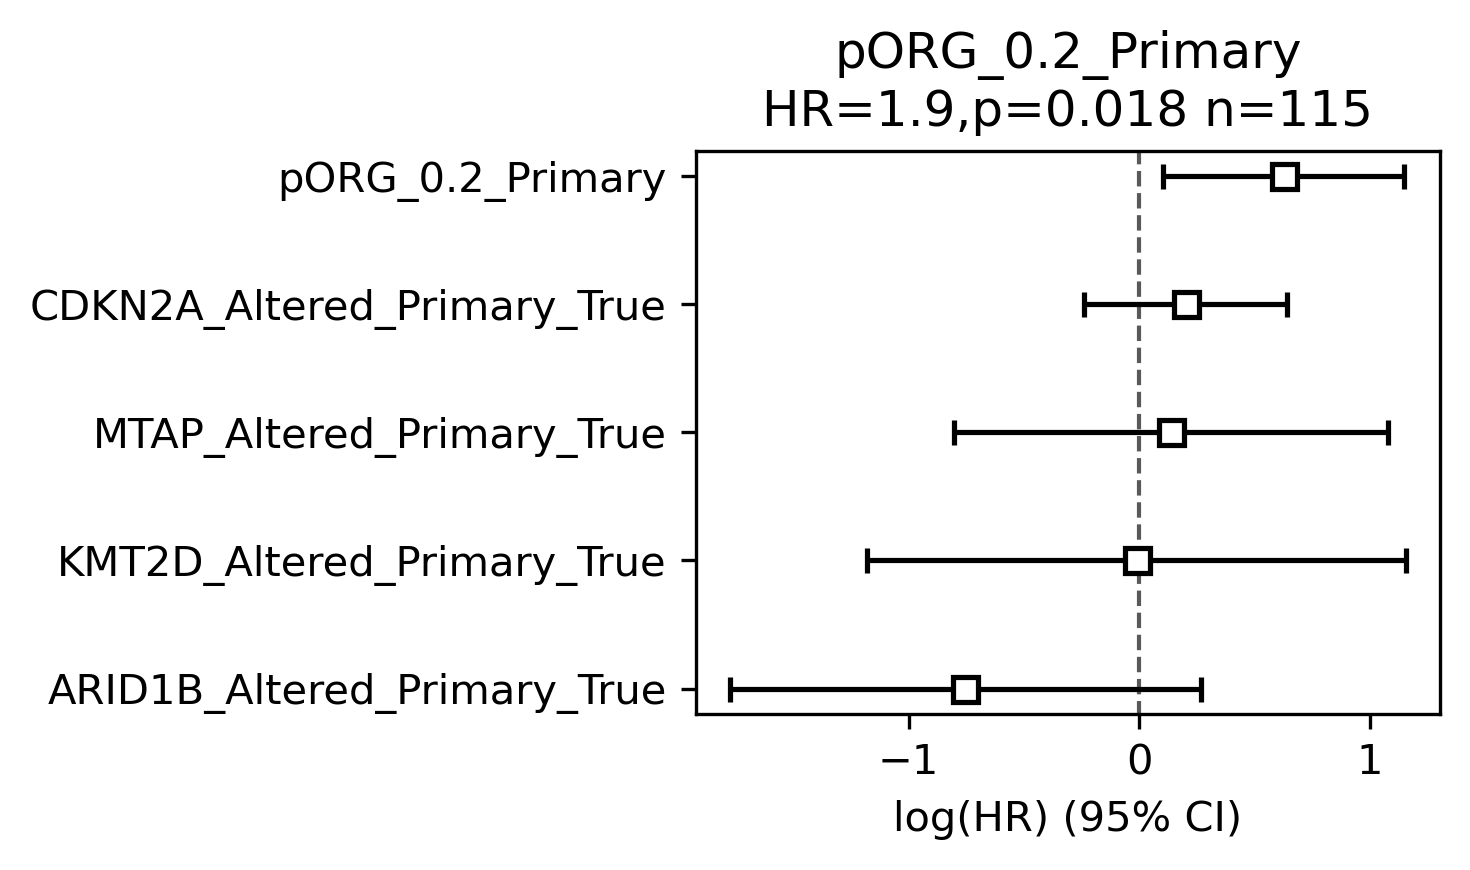

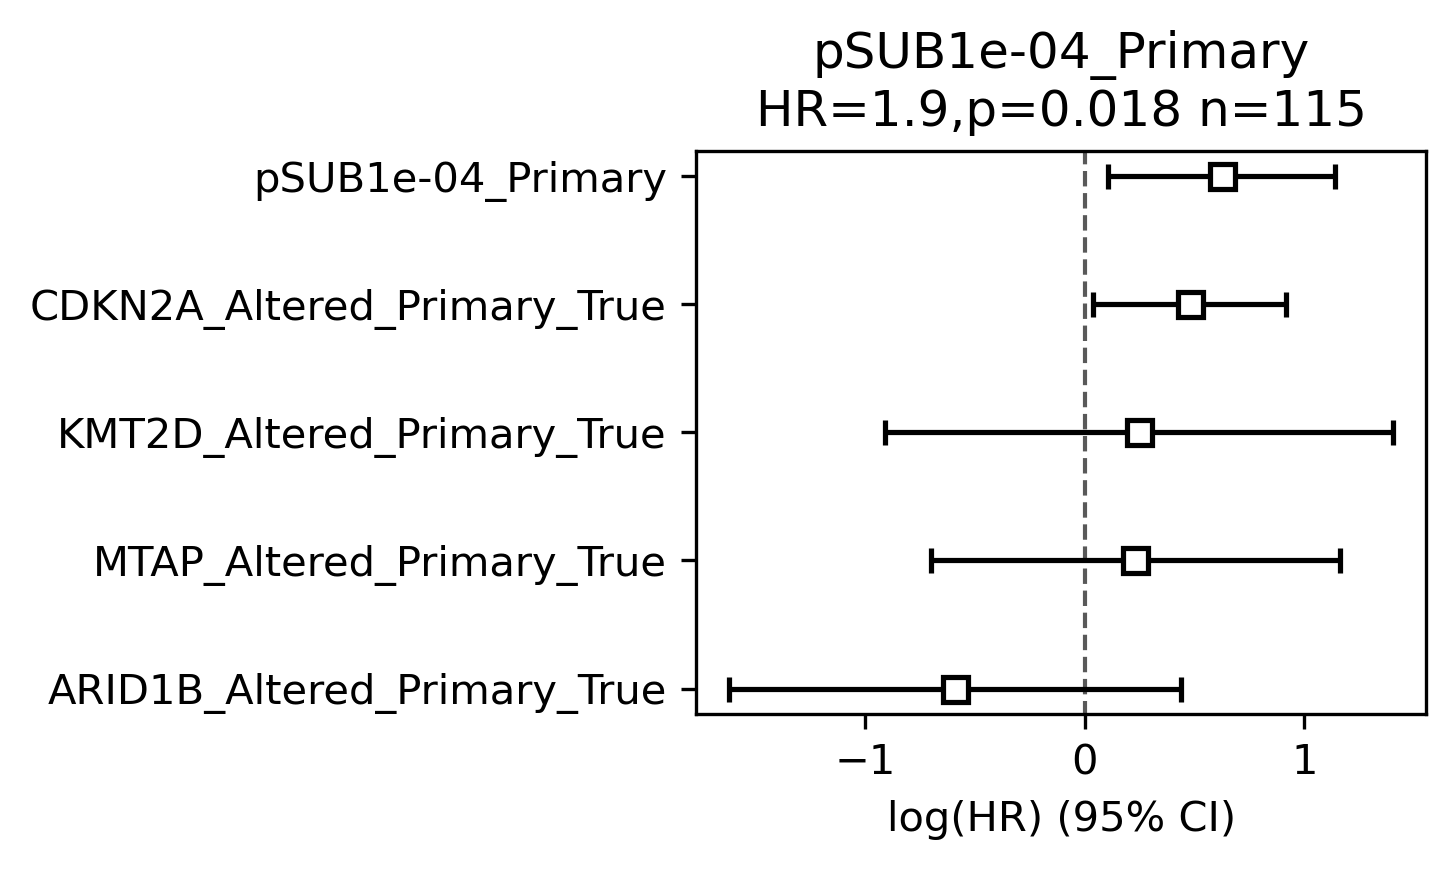

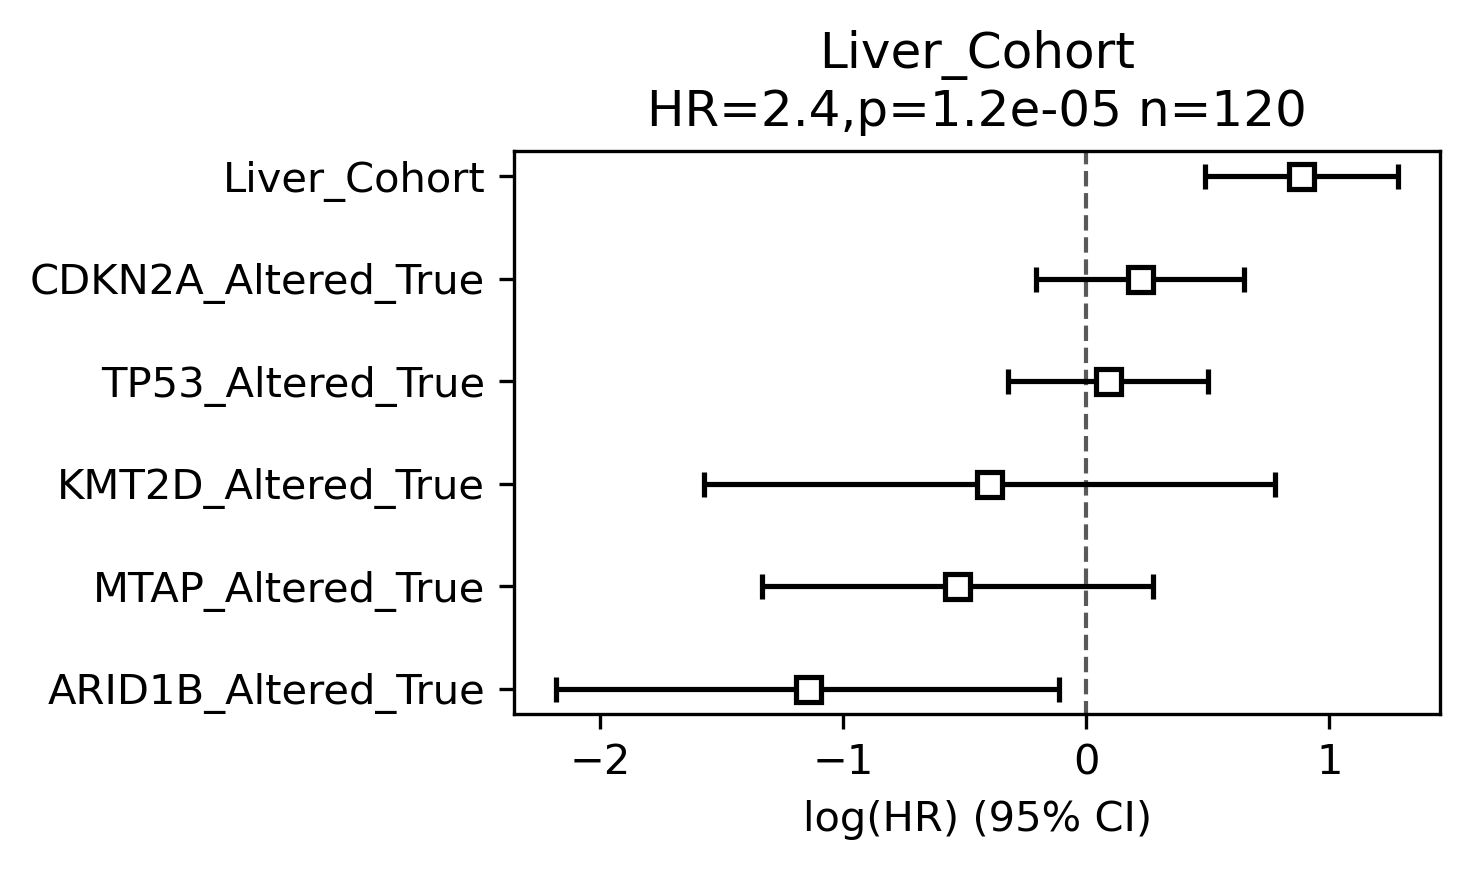

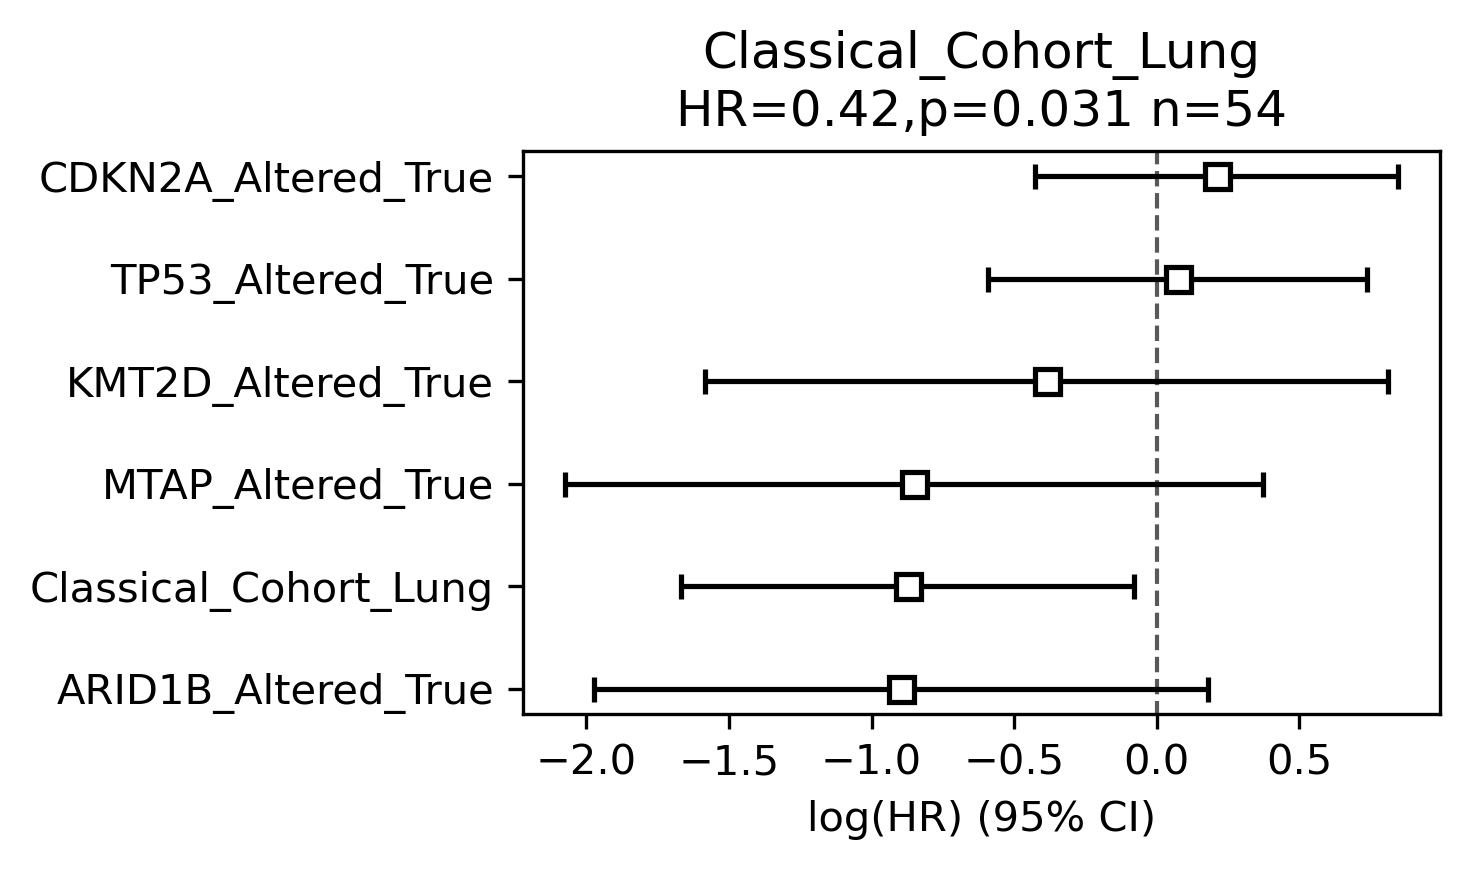

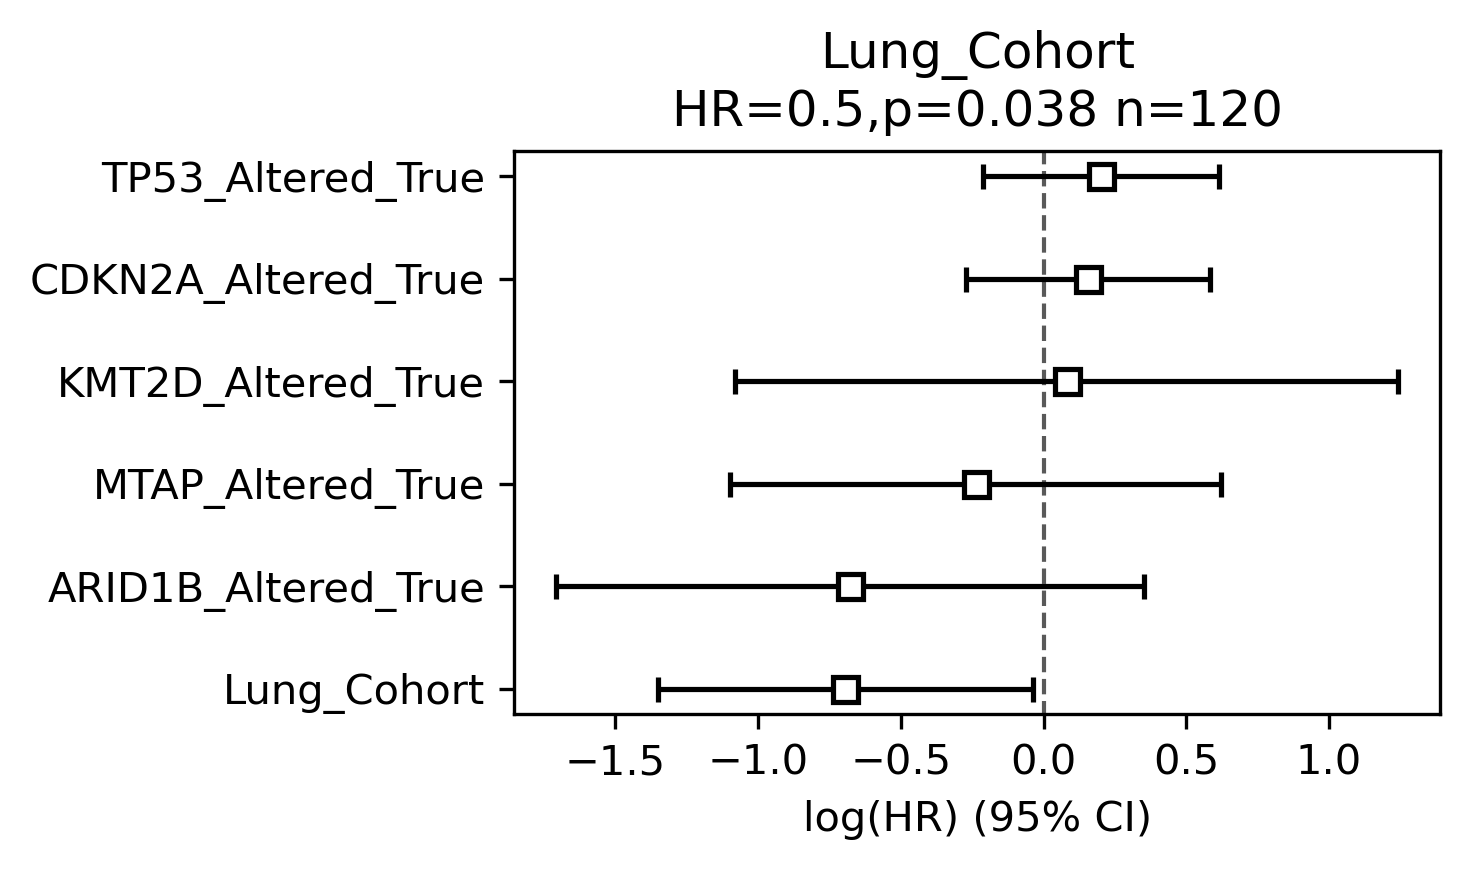

In [367]:
#CPH multivariable
b_primary = False
for (s_time, s_censor) in tu_time_censor:
    print(s_censor)
    for b_genes in [False, True,]:
        if b_genes:
            s_covar = 'gene_alterations'
            figsize = (5,3)
        else:
            s_covar = 'clinical_covariates'
            figsize = (4,3)
        df_result_multi = pd.DataFrame()
        ls_multi = ['PurIST_Primary','pORG_0.2_Primary',#'pORG_0.2_Met', 'pORG_0.2_All',,'PurIST_Met',
                'pSUB1e-04_Primary', 'Liver_Cohort',#'pSUB1e-04_Met',#'pSUB1e-04_All'
            #'Other_Recurrence', 'No_Recurrence',
                     'Classical_Cohort',
                    'Lung_Cohort',
               ]
        ls_cats = ['LV_Invasion','LN_Pos'] #categorical,'Neoadjuvant'
        if b_genes:
            ls_cats = ['CDKN2A_Altered_Primary', #'CDKN2A_Altered_Met', 'KDM6A_Altered_Met',
               'ARID1B_Altered_Primary', 'KMT2D_Altered_Primary',
               'MTAP_Altered_Primary']
        for s_multi in ls_multi:
            if not b_primary:
                if len(se_recur.intersection(set([s_multi]))) and b_genes:
                    ls_cats = ['CDKN2A_Altered','ARID1B_Altered','KMT2D_Altered','MTAP_Altered','TP53_Altered']
            print(s_multi)
            df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_multi,s_time,s_censor,'Grade','Stage','Public_Patient_ID']].copy()#.dropna() #
            if ls_cats[0].find('Altered') > -1:
                df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_multi,s_time,s_censor,'Public_Patient_ID']].copy()#.dropna()
            #if len(se_recur.intersection(set([s_multi]))):
            #    df.loc[df_patient.Recurrence_Sites_4=='No_Resection',s_multi] = np.nan
            df = df.dropna()    
            if df.loc[:,s_multi].dtype=='O':
                df_dummy = pd.get_dummies(df.loc[df_patient.Alive_30_days_post_surgery,[s_multi]],drop_first=True)
                if df_dummy.shape[1]>0:
                    df.drop(s_multi,axis=1,inplace=True)
                    s_multi = df_dummy.columns[0]
                    df[s_multi] = df_dummy
                else:
                    continue
            df_dummy = pd.get_dummies(df_patient.loc[df_patient.Alive_30_days_post_surgery,ls_cats+['Public_Patient_ID']].dropna().set_index('Public_Patient_ID'),drop_first=True) #
            df = df.merge(df_dummy.reset_index(),on='Public_Patient_ID',how='left').set_index('Public_Patient_ID')
            df = df.dropna()
            print(len(df))
            try:
                fig, cph = util.cph_plot(df,s_multi,s_time,s_censor,figsize=figsize)
                fig.savefig(f'figures/CPH_multi_{s_multi}_{s_covar}_{s_censor}.png')
                #plt.close(fig)
                df_result_model = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']].reset_index()
                df_result_model['model'] = s_multi
                df_result_model['n'] = len(df)
                df_result_multi=pd.concat([df_result_multi,df_result_model])
            except:
                print('cph error')
#             break
#         break
#     break
    #all the recurrence combos - multi
    #'''
        s_vital = 'Recurrence_Sites_4'
        figsize=(5,3)
        for tu_combo in combinations(df_patient.Recurrence_Sites_4.unique(),r=2):
            print(tu_combo)
            df = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_vital,s_time,s_censor,'Stage','Grade']]#.dropna(how='any')
            df = df[df.loc[:,s_vital].isin(tu_combo)].dropna()
            #order them
            df.Recurrence_Sites_4 = df.Recurrence_Sites_4.astype('category')
            df.Recurrence_Sites_4 = df.Recurrence_Sites_4.cat.set_categories(sorted(tu_combo))
            df_dummy = pd.get_dummies(df.loc[df_patient.Alive_30_days_post_surgery,[s_vital]],drop_first=False)
            df.drop(s_vital,axis=1,inplace=True)
            s_compare = " to ".join(sorted(tu_combo))
            df[s_compare] = df_dummy.iloc[:,0]
            df_dummy = pd.get_dummies(df_patient.loc[:,ls_cats].dropna(),drop_first=True) 
            df = pd.concat([df,df_dummy],axis=1)
            df = df.dropna()
            print(len(df))
            try:
                fig, cph = util.cph_plot(df,s_compare,s_time,s_censor,figsize=figsize)
                plt.tight_layout()
                fig.savefig(f'figures/CPH_mutli_{s_vital}_{s_compare}_{s_covar}_{s_censor}.png')
                plt.close(fig)
                df_result_model = cph.summary.loc[:,['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']].reset_index()
                df_result_model['model'] = s_compare
                df_result_model['n'] = len(df)
                df_result_multi=pd.concat([df_result_multi,df_result_model])
            except:
                print('cph error')
        df_result_multi.reset_index(drop=True).to_csv(f'results/results_multi_CPH_{s_covar}_{s_censor}.csv')
        #'''
#         break
#     break

## Cox PH plots <a name="cphplot"></a>


[contents](#contents)

In [393]:
def forrest_plot(df_plot,s_title,figsize=(4,2.5)):
    '''
    plot hazard ratios as error bars
    df_plot: dataframe with HR 'exp(coef)', confidence 'ci', pvalue 'p'
    s_title: axis title string
    '''
    #colors
    df_plot['color'] = 'k'
    df_plot.loc[((df_plot.loc[:,'exp(coef)']<1)&(df_plot.p<0.05)),'color'] = 'g'
    df_plot.loc[((df_plot.loc[:,'exp(coef)']>1)&(df_plot.p<0.05)),'color'] = 'r'
    fig,ax = plt.subplots(figsize=figsize,dpi=300)
    for idx, row in df_plot.iterrows():
        ax.errorbar(x=row['exp(coef)'], y=row.name, xerr=np.array([row.ci[0],row.ci[1]]).reshape(2,1), #row.ci,#[0],
                ecolor="k", capsize=3, linestyle='None', linewidth=1, marker="s", 
                         markersize=5, mfc=row.color, mec=row.color)
    ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    ax.set_xlabel('Hazard Ratio')
    ax.set_title(s_title)
    plt.tight_layout()
    return(fig,df_plot)

def make_ci(df):
    df['upper'] = df['exp(coef) upper 95%'] - df['exp(coef)']
    df['lower'] = df['exp(coef)'] - df['exp(coef) lower 95%'] 
    df['ci'] = list(zip(df['lower'], df['upper']))
    return(df)

In [394]:
#load patient metadata
%matplotlib inline
s_out = '20230905_Patient_Metadata.csv'
df_patient = pd.read_csv(s_out,index_col=0)
#add recurrence censor
df_patient.loc[~df_patient.loc[:,'Days from Resection to Recurrence'].isna(),'Recurrence'] = 1
df_patient.loc[df_patient.No_Recurrence,'Recurrence'] = 0

In [395]:
# load saved CPH results
for s_file in os.listdir('results'):
    if s_file.find('results_multi') > -1:
        print(s_file)


results_multi_CPH_clinical_covariates_Recurrence_JE.csv
results_multi_CPH_clinical_covariates_Survival.csv
results_multi_CPH_clinical_covariates_Recurrence.csv
results_multi_CPH_clinical_covariates_Survival_JE.csv
results_multi_CPH_gene_alterations_Survival.csv
results_multi_CPH_gene_alterations_Recurrence.csv


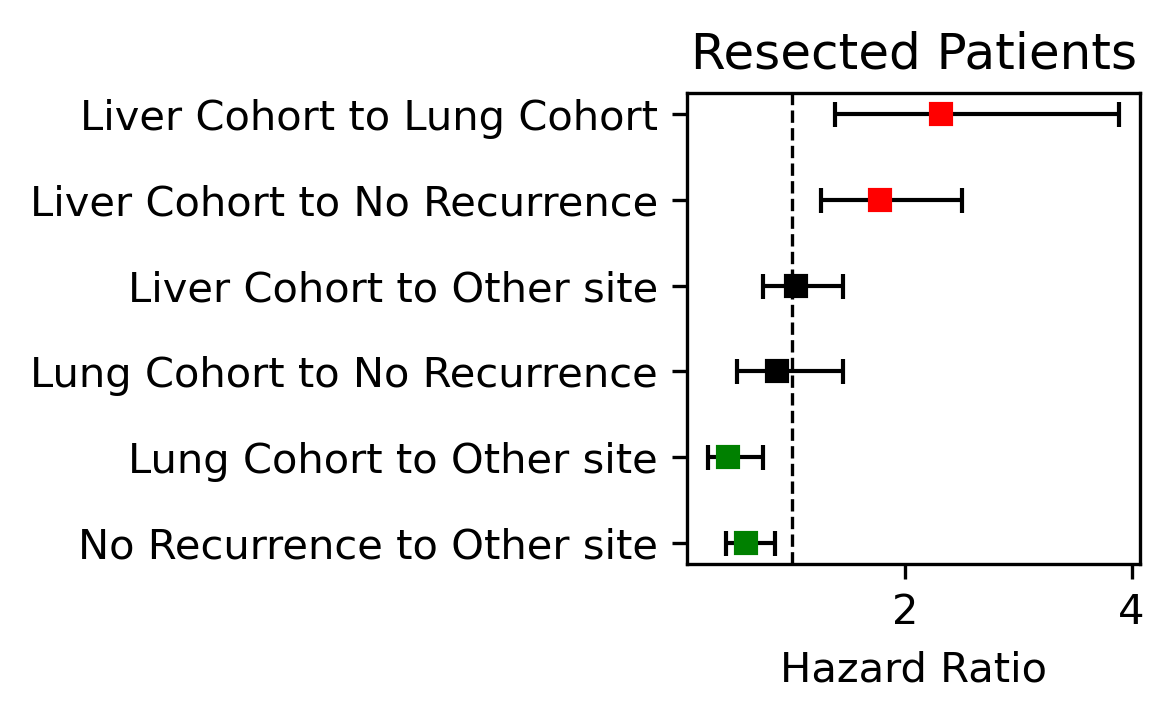

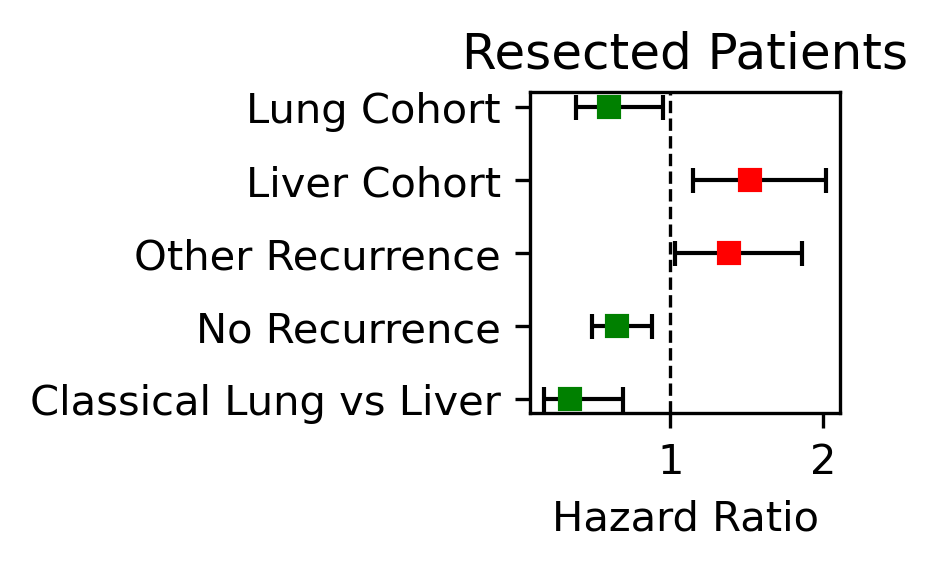

In [396]:
#multi compare resected
df = pd.read_csv(f'results/results_single_CPH_Survival_JE.csv',index_col=0)
df=make_ci(df)

ls_row = ['Liver to No_Recurrence', 'Liver to Lung', 'Liver to Other_site',
       'Lung to No_Recurrence', 'No_Recurrence to Other_site',
       'Lung to Other_site']
df_plot = df.loc[ls_row]
df_plot.index = [item.replace('_',' ').replace('Lung','Lung Cohort').replace('Liver','Liver Cohort') for item in df_plot.index]
df_plot.sort_index(ascending=False,inplace=True)
# # plot
s_title='Resected Patients'
fig,__ = forrest_plot(df_plot,s_title)
fig.savefig(f'figures/cph_final_cohorts_compare.png')

#compare to all patients
ls_row = [ 'Lung_Cohort','Liver_Cohort',
       'Other_Recurrence',
       'No_Recurrence',
          'Classical_Lung_vs_Liver'
         ]
df_plot = df.loc[ls_row].copy()
df_plot.index = [item.replace('_',' ') for item in df_plot.index]
df_plot = df_plot.iloc[::-1]
# # plot
fig,__ = forrest_plot(df_plot,s_title,figsize=(3,2))
fig.savefig(f'figures/cph_final_cohorts.png')

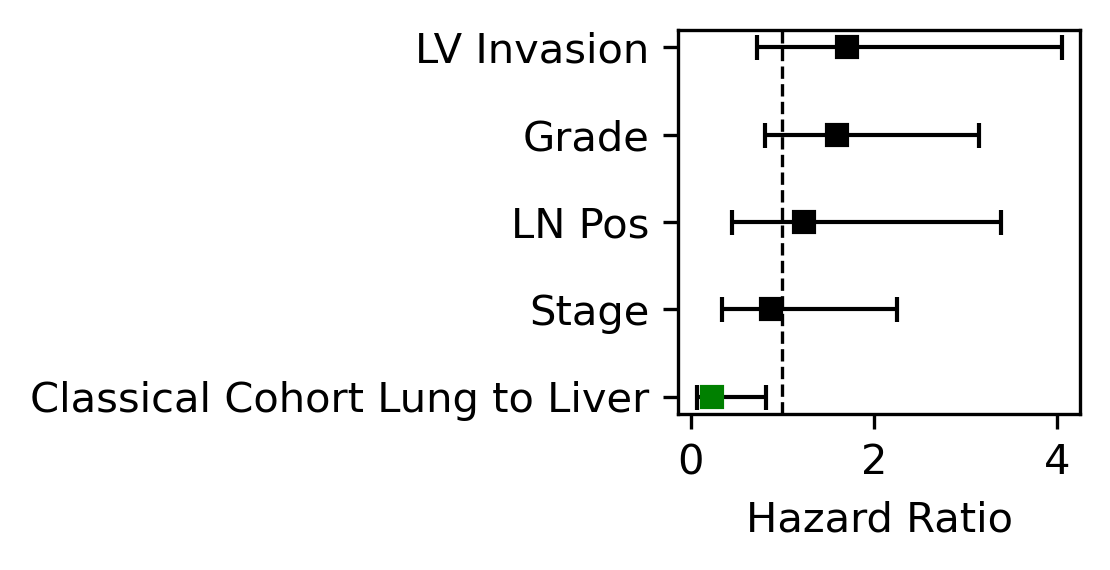

In [414]:
# clinical covariates
s_file = 'results_multi_CPH_clinical_covariates_Survival_JE.csv'
df = pd.read_csv(f'results/{s_file}',index_col=0)
df = make_ci(df)

ls_model = [#'Lung to No_Recurrence',
#             'Liver to No_Recurrence', 'Liver to Lung',
#        'Liver to Other_site', 
#        'No_Recurrence to Other_site', 'Lung to Other_site',
#            'PurIST_Primary', 'pORG_0.2_Primary', 'pSUB1e-04_Primary',
#            'Liver_Cohort_True','Other_Recurrence_True','No_Recurrence_True','Lung_Cohort_True',
            'Classical_Lung_vs_Classical_Liver']
for s_model in ls_model:
    df_plot = df[df.model==s_model].copy()
    df_plot.index = df_plot.covariate.replace({'Classical_Cohort_Lung':'Classical_Cohort_Lung_to_Liver'})
    df_plot.index = [item.replace('_',' ').replace('True','').replace(' YES','')for item in df_plot.index]#.replace('Lung','Lung Cohort').replace('Liver','Liver Cohort').replace(' YES','') for item in df_plot.index]
    s_title = s_model.replace('_',' ').replace('True','')#.replace('Lung','Lung Cohort').replace('Liver','Liver Cohort')
    df_plot.sort_values(by='exp(coef)',inplace=True)
    if s_model.find('to') > -1:
        figsize=(3.5,2)
    elif s_model.find('vs') > -1:
        figsize=(3.8,2)
    else:
        figsize = (2.5,2)
    fig,__ = forrest_plot(df_plot,s_title='',figsize=figsize)
    fig.savefig(f'figures/cph_final_{s_title}.png')
    #break

In [398]:
#df[~df.covariate.isin(['Grade','Stage','LV_Invasion_YES','LN_Pos_YES'])].to_csv('tent.csv')

In [399]:
# gene alteration
df = pd.read_csv(f'results/results_multi_CPH_gene_alterations_Survival.csv',index_col=0)
df=make_ci(df)



# Section 6 <a name="geneexp"></a>

gene expresison correlation

The 7 genes used for the IRDS signature were: STAT1, IFI44, IFIT3, OAS1,208
IFIT1, G1P2, and MX1


[contents](#contents)

In [ ]:
s_out = '20230828_Patient_Metadata.csv'
df_patient= pd.read_csv(s_out,index_col=0)

df_vst = pd.read_csv('data/VST_Genes_Link.csv',index_col=0)
df_rna = df_vst.T.copy()
df_rna.index = [item[0:-2] for item in df_rna.index]
print(len(df_rna))

In [ ]:
ls_add = ['pORG_0.2_Primary','pSUB1e-04_Primary','PurIST_Primary']
for s_add in ls_add:
    d_map = dict(zip(df_patient.loc[:,'Public_Patient_ID'],df_patient.loc[:,s_add]))
    df_rna[s_add] = df_rna.index.map(d_map)


In [ ]:
d_rename={'txi_pORG_Up_42_Genes':'pORG_42',
          'trim_padj_0.2_pORG_Up_55_Genes':'pORG_55',
          'pORG.14':'pORG_14', 'pORG.15':'pORG_15',
          'pORG_0.2_Primary':'pORG_0.2',
          'pSUB1e-04_Primary':'pSUB1e-04',
          'MRC1':'MRC1 (CD206)',
          'OLR1':'OLR1 (LOX1)',
          'MS4A1':'MS4A1 (CD20)'}
from scipy.stats import pearsonr
dim = (4,3)
    
for s_add in ls_add:
    ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1',#'LAMP3','ITGAX','CD209',
                 'CD68','OLR1','MRC1','MX1','STAT1',
                 s_add] #
    df_all = df_rna.loc[:,ls_marker].corr().rename(d_rename,axis=1).rename(d_rename,axis=0)
    print(len(df_rna))
    g = sns.clustermap(df_all)
    plt.close()
    categories_order = df_all.iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
    df_all = df_all.loc[categories_order,categories_order]
    rho = df_rna.loc[:,ls_marker].corr() #df_all.corr()
    pval = df_rna.loc[:,ls_marker].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
    p_vals = p_vals.rename(d_rename,axis=1).rename(d_rename,axis=0)
    p_vals = p_vals.loc[categories_order,categories_order]
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax,
               cbar_kws={'shrink':0.85,'label':s_add})
    #temp
    plt.title(f'{s_add} n={len(df_rna)}')
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    matrix = np.triu(np.ones_like(rho))
    np.fill_diagonal(matrix, val=0)
    np.fill_diagonal(p_vals.values,'')
    sns.heatmap(df_all, vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',
                ax=ax,mask=matrix,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'},
               ) #'anchor':(-1.4,0.0)

## gene expresison versus liver lung

In [ ]:
Colorblind[8]
pal_porg = ('#56B4E9','#E69F00')
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_liv)
#sns.palplot(Colorblind[8])

In [ ]:
# add cohort
df_rna['Public_Patient_ID'] = df_rna.index
df_rna['Cohort'] = df_rna.index.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
#liver vs lung (t cell)
for s_samples in ['T cell samples','All Samples']:
    ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1']
    if s_samples == 'T cell samples':
        df_plot = df_rna.loc[df_rna.Public_Patient_ID.isin(df_tcell.Public_Patient_ID),ls_marker].unstack().reset_index()
    else:
        df_plot = df_rna.loc[:,ls_marker].unstack().reset_index()
    df_plot['Public_Patient_ID'] = df_plot.level_1#[item[0:-2] for item in df_plot.level_1]
    df_plot['Cohort'] = df_plot.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
    df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
    fig,ax = plt.subplots(dpi=200,figsize=(5,3))
    sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',dodge=True,ax=ax,s=2)
    sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='Cohort',ax=ax,showmeans=True,medianprops={'visible': False},
                           whiskerprops={'visible': False},meanline=True,showcaps=False,
                           meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[0:2],l[0:2],loc='lower left')
    pairs = [((item,'Lung'),(item,'Liver')) for item in ls_marker]
    annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='Cohort',
                      order=ls_marker,hue_order=('Lung','Liver'))
    annot.configure(test='t-test_ind')
    annot.apply_and_annotate()
    ax.set_title(f'Liver vs Lung: {s_samples}')
    plt.tight_layout()

## Section 6 <a name="tcell"></a>

re-analyze t cell data

289 blood samples with matching 175 primary
tumors (141 overlapping with the RNA-seq dataset) and 43 metastatic tumors (33 overlapping with
the RNA-seq dataset). (218)

**missing 2 tumor (have 216), all 289 blood there**

290 unique patients (one primary tumor w/o blood: ST-00018360)

215 blood and tumor are matched

TOTAL = 174 primary, 42 met (216 total)

Of the 290 patients, 284 are analyzed (some dropped surgery)

we analyzed blood samples from 77 patients in the liver cohort and 16
patients in the lung cohort, of which 60 and 16 were matched with tumor samples from the same
patient, respectively

TOTAL = 94 blood
TOTAL = 76 tumor

tumor distinct clones
used data from 214 matched pairs of tumor and blood samples

**213 are there, missing 1**

(TCR tumor: 59 and 16)

#### Exclude those who died of surgery

yes      ST-00018963

yes      ST-00020077

yes     ST-00016968

yes     ST-00006625

yes     ST-00007146

yes    ST-00018260

#### Actually analyzed 
Liver    76
Lung     16

| Cohort  | Tumor Type  |  number pts.  |
|---------|-------------|---------------|
| Liver   | Met         | 17            |
|         | Primary     | 42            |
| Lung    | Met         | 3             |
|         | Primary     | 13            |

[contents](#contents)

In [ ]:
# df_merge.loc[df_merge.Alive_30_days_post_surgery,['Shannon_Entropy_Tumor','Alive_30_days_post_surgery']].dropna()

In [ ]:
#load full patient data
s_out = '20230905_Patient_Metadata.csv'
df_patient= pd.read_csv(s_out,index_col=0)
# old patient data
df_patient_old = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset1.xlsx',
                           sheet_name='Patients - Tab 1')
#load T cell data - tumor
df_tcell = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Tumor Samples')
print(f'T cell tumor {len(df_tcell)}')
#blood
df_tcell_blood = pd.read_excel(f'{codedir.split("Liver_Lung_PDAC")[0]}MethodsAndReferencesSupplementalData/SupplementalDataset6.xlsx',
                         sheet_name='Blood Samples')
#df_tcell_blood['Tumor Type'] = 'Blood'
print(f'T cell blood {len(df_tcell_blood)}')

#both
df_tcell = df_tcell.merge(df_tcell_blood,on='Patient ID',suffixes=(' tumor',' blood'),how='outer')
df_tcell.rename({'Productive Rearrangements (Observed Richness)':'Productive_Rearrangements',
                'Templates per ng':'Templates_per_ng','Patient ID':'Public_Patient_ID'},axis=1,inplace=True)
print(f'T cell both {len(df_tcell)}')
df_merge = df_patient[df_patient.Public_Patient_ID.isin(df_tcell.Public_Patient_ID)]

# missing_ids: some were dropped surgery due to death from surgery
missing_ids = df_tcell[~df_tcell.Public_Patient_ID.isin(df_merge.Public_Patient_ID)].Public_Patient_ID
df_not_matched = df_patient_old[df_patient_old.loc[:,'Patient ID'].isin(missing_ids)]
print(f'dropped {len(df_not_matched)} patients; days surv post surgery: {df_not_matched.loc[:,"Days from Resection to FU"].max()}')

print(f'Unique patients t cell {(df_merge.Public_Patient_ID.nunique())}')
print(df_merge.Cohort.value_counts())
print(df_merge.groupby(['Cohort','Tumor Type']).count().Public_Patient_ID)

## add calculated Entropy, simpsons 

In [ ]:
#load data

d_load = {'TCR_Tumor_Distinct_Clones_no_rare_denom.csv':['Public_Patient_ID',
                'Number Tumor Distinct Clones', 'Fraction Tumor Distinct Clones','Prod. Freq. Tumor Distinct Clones'],
          'TCR_Tumor_Distinct_Rearrangements_no_rare.csv':['Public_Patient_ID',
       'Number Tumor Distinct Rearrangements','Fraction Tumor Distinct Rearrangements','Prod. Freq. Tumor Distinct Rearrangements'],
          'TCR_Tumor_Distinct_Clones.csv':['Public_Patient_ID','Fraction_Tumor_Distinct_Clones'],#'Number Tumor Distinct Clones (rare)',
          'TCR_Simpsons_Evenness_templates.csv':['Public_Patient_ID','Simpsons_Evenness','Simpsons_Evenness_no_CMV'],
          'TCR_Simpsons_D_templates.csv':['Public_Patient_ID','Simpsons_D'],
          'TCR_Shannon_entropy_productive_frequency.csv':['Public_Patient_ID','Shannon_Entropy','Normalized_Shannon_Entropy'],
         }
for s_en, ls_markers in d_load.items():
    print(s_en)
    df_en = pd.read_csv(f'data/{s_en}')
    df_en.rename({'Unnamed: 0':'Patient_Specimen_ID','Shannon Entropy':'Shannon_Entropy',#'Percent Tumor Distinct Rearrangements in Tumor':'Percent Tumor Distinct Clones (JL)',   
             'Normalized Shannon Entropy':'Normalized_Shannon_Entropy'},axis=1,inplace=True)
    if s_en == 'TCR_Tumor_Distinct_Clones.csv':
        df_en.rename({'Unnamed: 0':'Patient_Specimen_ID','Fraction Tumor Distinct Clones in Tumor':'Fraction_Tumor_Distinct_Clones'},axis=1,inplace=True)
    df_en['dash_end'] = [item.split('-')[-1] for item in df_en.Patient_Specimen_ID]
    df_en['Public_Patient_ID'] = [item.split('-')[0] + '-' + item.split('-')[1] for item in df_en.Patient_Specimen_ID]
    #patient rows with columns for blood and tumor
    df_en_pat = pd.DataFrame(index=df_en.Public_Patient_ID.unique())
    df_tum = df_en[df_en.dash_end!='B'].loc[:,ls_markers].set_index('Public_Patient_ID')
    print(df_tum.index.duplicated().any())
    df_en_pat = df_en_pat.merge(df_tum,left_index=True,right_index=True,how='left')
    if s_en.find('Tumor_Distinct') == -1:
        df_bld = df_en[df_en.dash_end=='B'].loc[:,ls_markers].set_index('Public_Patient_ID')
        print(df_bld.index.duplicated().any())
        df_en_pat = df_en_pat.merge(df_bld,left_index=True,right_index=True,how='left',suffixes=('_Tumor','_Blood'))
    df_merge = df_merge.merge(df_en_pat.reset_index().rename({'index':'Public_Patient_ID'},axis=1),on='Public_Patient_ID',how='left')
    #break
    
df_merge['Simpsons_Diversity_Tumor'] = 1/df_merge.Simpsons_D_Tumor#1-df_merge.Simpsons_D_Tumor#
df_merge['Simpsons_Diversity_Blood'] = 1/df_merge.Simpsons_D_Blood#1-df_merge.Simpsons_D_Blood#
df_merge['Clonality_Tumor'] = 1 - df_merge.Normalized_Shannon_Entropy_Tumor
df_merge['Clonality_Blood'] = 1 - df_merge.Normalized_Shannon_Entropy_Blood

#met or primary
df_merge['Percent Tumor Distinct Clones'] = 100 - df_merge.loc[:,'Percentage Tumor-Distinct Clones in Paired Tumor Sample']
df_merge.rename({'Patient Specimen ID':'Patient_Specimen_ID','Tumor Type':'Tumor_Type'},axis=1,inplace=True)
print((df_merge.Public_Patient_ID.nunique()))

# df_merge.loc[df_merge.loc[:,'PurIST_Met'] > 0.5,'PurIST_Subtype'] = 'basal-like'
# df_merge.loc[df_merge.loc[:,'PurIST_Met'] <= 0.5,'PurIST_Subtype'] = 'classical'

In [ ]:
df_patient

In [ ]:
#save out metadata with TCR
# ls_col = df_merge.columns[~df_merge.columns.isin(df_patient.columns)].tolist() + ['Public_Patient_ID']
# df_out = df_patient.merge(df_merge.loc[:,ls_col],on='Public_Patient_ID',how='left')
# df_out.to_csv('20230908_Patient_Metadata_TCR_Metrics.csv')
# df_out.Public_Patient_ID.duplicated().any()

In [ ]:
#add pORG quartiles, plot violins 
%matplotlib inline
sns.set_palette('tab10')
importlib.reload(util)
alpha = 0.05
b_correct= True#False #True #
ls_foci = ['Shannon_Entropy_Tumor','Templates_per_ng', 'Shannon_Entropy_Blood',
           'Productive_Rearrangements',
        'Simpsons_Diversity_Tumor','Simpsons_Diversity_Blood',
           'Clonality_Tumor', 'Clonality_Blood',
        "Simpson's Evenness tumor", "Simpson's Evenness blood",
    #'Fraction Tumor Distinct Rearrangements',
           'Fraction Tumor Distinct Clones', #equals Percent
            'Fraction_Tumor_Distinct_Clones',
           #'Percent Tumor Distinct Clones',
        ]
d_colorblind = {'Liver':'#d55e00','Lung':'#0072b2',
               'high':'#e69f00','low': '#56b4e9',
               'basal-like':'#000000','classical':'#cc79a7',
               'high pSUB': '#f0e442','low pSUB':'#d55e00'}
#non- parametric
se_non_para = pd.Series(['Simpsons_Diversity_Blood', 
    'Templates_per_ng','Productive_Rearrangements',
     "Simpson's Evenness tumor",
    "Simpson's Evenness blood",
   'Number Tumor Distinct Clones'])
d_order =  {'Cohort':['Liver','Lung'],#'PurIST_Subtype':['basal-like','classical'],
    'quartiles':['high','low']}
for s_porg in [ 'pORG_0.2_Primary','pORG_0.2_All', 'pORG_0.2_Met']:#, 'pORG_78_Primary',
    if s_porg.find('Primar') > -1:
        print('Primaries')
        df_pri = df_merge.loc[(df_merge.Tumor_Type=='Primary')].copy()
    elif s_porg.find('All') > -1: 
        print('Primaries and Mets')
        df_whole = pd.DataFrame(columns=df_merge.columns)
        for s_all in ['pORG_0.2_allPrimary', 'pORG_0.2_allMet']:
            df_half = df_merge[(df_merge.loc[:,s_all].notna())]
            df_half = df_half[~df_half.Public_Patient_ID.isin(df_whole.Public_Patient_ID)].copy()
            df_half.rename({s_all:'pORG_0.2_All'},axis=1,inplace=True)
            print(len(df_half))
            df_whole = pd.concat([df_whole,df_half],axis=0,ignore_index=True)
        #s_foci not defined
        df_pri = df_merge.merge(df_whole.loc[df_whole.loc[:,s_foci].notna(),['Public_Patient_ID','pORG_0.2_All']],on='Public_Patient_ID',how='left')
        df_pri.loc[df_pri.Public_Patient_ID.duplicated(),'Cohort'] = np.nan
    elif s_porg.find('Met') > -1:
        df_pri = df_merge.loc[df_merge.Tumor_Type=='Met'].copy()
    df_pri = util.add_quartiles(df_pri,s_porg)#.drop(219) #p. rearrangements outlier 
    for s_foci in ls_foci:
        print(s_foci)
        if se_non_para.isin([s_foci]).any():
            s_stats = 'non-parametric'
        else:
            s_stats = 'mean' 
        df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_foci,s_stats)
        #util.qq_plot_hist(df_pri,s_cat,s_foci)  #anova eval
#         fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_foci,order,d_colorblind,s_porg,b_correct=b_correct)#True#False
#         fig.savefig(f'figures/violinplot_both_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
#         plt.close(fig)
        # SPEARMAN corr to tumor distinct clones
        #fig2, pvalues2 = util.plot_pearson(df_pri,'Percent Tumor Distinct Clones',s_foci,s_stats= 'non-parametric',ls_plots=['Primaries'])
        '''
        if s_porg.find('All') > -1:
            fig2, pvalues2 = util.plot_pearson(df_pri,s_porg,s_foci,s_stats,ls_plots=['Primaries','Mets','Both'])
            fig2.savefig(f'figures/scatterplot_pearson_all_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
        elif s_porg.find('Primar') > -1:
            fig2, pvalues2 = util.plot_pearson(df_pri,s_porg,s_foci,s_stats,ls_plots=['Primaries'])
            fig2.savefig(f'figures/scatterplot_pearson_primary_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
        elif s_porg.find('Met') > -1:
            fig2, pvalues2 = util.plot_pearson(df_pri,s_porg,s_foci,s_stats,ls_plots=['Mets'])
            fig2.savefig(f'figures/scatterplot_pearson_met_{s_foci}_{list(d_order.keys())[-1]}_{s_porg}_{s_stats}.png')
        plt.close(fig2)
#         break
#         #'''
    break


## TCR survival <a name="tcells"></a>

- The goal is to find a rational method to set a pORG threshold selecting High/Low cohorts for use in Kaplan-Meier and pathway analysis.
- Since we have survival data and it’s probably the best clinical endpoint we can use, we will start by selecting a survival threshold that seems relevant. (545 days)
- Based on the survival threshold, we will divide the patient into short/long term survivor cohorts.
- We can then generate rock curves testing the ability of our pORG score to predict these cohorts.
- Using the Youden’s Index, we can maximize the pORG threshold for making this prediction.
- Finally, we can use this pORG threshold to generate Kaplan-Meier curves and test the significance of these using log-rank p-value.
- We will try this with a few reasonable selections for our original survival threshold.


[contents](#contents)

In [ ]:
#KM and CPH
pal_porg_r = ('#E69F00','#56B4E9')
sns.set_palette(pal_porg_r)
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
alpha = 0.1
savedir = 'figures'
d_cut = {4:['low','med-low','med-high','high'],
         3: ['low','highX','high'], #['low','med','high'],#
         2:['low','high']
        }
for i_cut, labels in d_cut.items():
    for s_title_str in  ['All','Primary','Met',]:
        df_result = pd.DataFrame()
        if s_title_str == 'All':
            df_km_samples = df_merge.loc[df_merge.Alive_30_days_post_surgery]
        #elif s_title_str == 'Met':
        #    i_cut=2
        #    labels=['low','high']
        #    df_km_samples = df_merge.loc[(df_merge.loc[:,'Tumor_Type']==s_title_str) & (df_merge.Alive_30_days_post_surgery),[s_time,s_censor,'Public_Patient_ID']+ls_foci]
        else:
            df_km_samples = df_merge.loc[(df_merge.loc[:,'Tumor_Type']==s_title_str) & (df_merge.Alive_30_days_post_surgery),[s_time,s_censor,'Public_Patient_ID']+ls_foci]
        for s_col in ls_foci: #[2::]
            try:
                df_km, pvalue = util.quartile_km(df_km_samples,s_col,s_title_str,savedir,alpha,i_cut,
                                                labels,s_time=s_time,s_censor='Survival')
                print(f'{s_col} {s_title_str} {i_cut}: {pvalue}')
            except:
                print(f'no KM {s_col} {s_title_str} {i_cut}')
            if i_cut == 4:
                try: #cox
                    df = df_km_samples.loc[:,[s_col,s_time,s_censor]].dropna()
                    fig2, cph = util.cph_plot(df,s_col,s_time,s_censor,figsize=(4,1.5))
                    plt.tight_layout()
                    fig2.savefig(f'figures/CPH_TCR_{s_col}_{s_title_str}.png')
                    df_result_model = cph.summary.loc[:,['exp(coef)','p']].reset_index()
                    df_result=pd.concat([df_result,df_result_model])
                    plt.close(fig2)
                except:
                    print('')
                #print(s_title_str)
            #break
        #df_result.sort_values(by='p').set_index('covariate').to_csv(f'results_CPH_TCR_{s_title_str}.csv')
        #break

## youden 

In [ ]:
#define high and low survivors
# df_patient.loc[:,'Vital Status at FU'].replace({'Alive':0,'Dead':1}) #note to self
df_patient = pd.read_csv(f'20230908_Patient_Metadata_TCR_Metrics.csv')
s_time = 'Days from Diagnosis to FU'
s_censor = 'Survival'
df_counts = pd.DataFrame(columns=['Long','Short','Short_Censored'])
for s_tcr in ls_foci:
    #s_tcr = 'Shannon_Entropy_Blood'#'pORG_0.2_Primary'
    for SurvivalThreshold in [90, 180, 365, 545, 730]:
        GoodIdx = (df_patient.loc[:,s_time] > SurvivalThreshold) & (df_patient.loc[:,s_tcr].notna()) & (df_patient.Alive_30_days_post_surgery)
        BadIdx = (df_patient.loc[:,s_time] <= SurvivalThreshold) & (df_patient.loc[:,s_tcr].notna()) & (df_patient.loc[:,s_censor] == 1) & (df_patient.Alive_30_days_post_surgery)
        Num_censored = (df_patient.loc[:,s_time] <= SurvivalThreshold) & (df_patient.loc[:,s_tcr].notna()) & (df_patient.loc[:,s_censor] == 0) & (df_patient.Alive_30_days_post_surgery)
        df_counts.loc[f'{s_tcr}_{SurvivalThreshold}'] = [GoodIdx.sum(),BadIdx.sum(),Num_censored.sum()]
        df_patient.loc[GoodIdx,f'{s_tcr}_{SurvivalThreshold}_day_survival'] = 'long'
        df_patient.loc[BadIdx,f'{s_tcr}_{SurvivalThreshold}_day_survival'] = 'short'
#     df_counts['total'] = df_counts.sum(axis=1)
#     df_counts['included_ROC'] = df_counts.loc[:,['Short','Long']].sum(axis=1)
    #break
#df_counts.to_csv('patient_counts_TCR_ROC.csv')

In [ ]:
#low = good
importlib.reload(util)
pal_porg = ('#56B4E9','#E69F00')
sns.set_palette(pal_porg)
pos_label='short'
dd_result = {}
for s_tcr in ls_foci:
    print(s_tcr)
    fig, d_result = util.plot_youden_tcr(df_patient,s_tcr,pos_label)
    fig.savefig(f'figures/youden_{s_tcr}_{pos_label}.png')
    plt.close(fig)
    dd_result.update(d_result)
    #break
sns.set_palette(pal_porg_r)
for s_surv in ['180_day_survival','545_day_survival']:
    keys = df_patient.columns[(df_patient.columns.str.contains(s_surv))]
    for key in keys:
        s_tcr = '_'.join(key.split('_day_survival')[0].split('_')[0:-1])
        thresh = dd_result[key]
        df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_tcr,s_time,s_censor]].dropna()
        df_km[key] = (df_km.loc[:,s_tcr] > thresh).replace({True:'high',False:'low'})
        util.km_plot(df_km,key,s_time,s_censor)

    

In [ ]:
#high = good
pal_porg_r = ('#E69F00','#56B4E9')
sns.set_palette(pal_porg_r)
pos_label='long'
dd_result = {}
for s_tcr in ls_foci:
    print(s_tcr)
    fig, d_result = util.plot_youden_tcr(df_patient,s_tcr,pos_label)
    fig.savefig(f'figures/youden_{s_tcr}_{pos_label}.png')
    plt.close(fig)    
    dd_result.update(d_result)
for s_surv in ['180_day_survival','545_day_survival']:
    keys = df_patient.columns[(df_patient.columns.str.contains(s_surv))]
    for key in keys:
        s_tcr = '_'.join(key.split('_day_survival')[0].split('_')[0:-1])
        thresh = dd_result[key]
        df_km = df_patient.loc[df_patient.Alive_30_days_post_surgery,[s_tcr,s_time,s_censor]].dropna()
        df_km[key] = (df_km.loc[:,s_tcr] > thresh).replace({True:'high',False:'low'})
        util.km_plot(df_km,key,s_time,s_censor)
        #break
    #break

### TCR heatmap

In [ ]:
#heatmap
if s_porg == 'pORG_0.2_All':
    import matplotlib as mpl
    df_pri['Survival interval'] = pd.qcut(df_merge.loc[:,s_time],6)
    df_pri.rename({'medians':f'{s_porg} (median)'},axis=1,inplace=True)
    ls_annot = ['Tumor_Type', 'Cohort',f'{s_porg} (median)' ,'Survival interval']
    cmap=plt.cm.get_cmap('Blues', 6)
    ls_color=[mpl.cm.Set1.colors,('#D55E00', '#0072B2'),('#E69F00', '#56B4E9'),
             [cmap(item) for item in np.arange(0,1,.17)]]
    df_annot = pd.DataFrame()
    dd_color = {}
    for idx, s_annot in enumerate(ls_annot):
        color_palette = ls_color[idx]
        d_color = dict(zip(sorted(df_pri.loc[:,s_annot].dropna().unique()),color_palette[0:len(df_pri.loc[:,s_annot].dropna().unique())]))
        d_color.update({'NA':'lightgray'})
        network_colors = df_pri.loc[:,s_annot].astype('object').fillna('NA').map(d_color)
        df_annot[s_annot] = pd.DataFrame(network_colors)
        dd_color.update({s_annot:d_color})
    from matplotlib.pyplot import gcf
    g = sns.clustermap(df_pri.loc[:,ls_foci].dropna(),z_score=1,dendrogram_ratio=0.1,cmap='RdBu_r',vmin=-5,vmax=5,
          cbar_pos=(0.01, 0.94, 0.04, 0.08),figsize=(8, 10),row_colors=df_annot,cbar_kws={'label': 'z-score'})
    for idx, (s_annot, d_color) in enumerate(dd_color.items()):
        g.ax_col_dendrogram.bar(0, 0, color='w',label=' ', linewidth=0)
        for label,color in d_color.items():
            g.ax_col_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
    g.ax_heatmap.set_yticks([])
    l1 = g.ax_col_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(0, 0.7),bbox_transform=gcf().transFigure)
    g.ax_heatmap.set_title(s_porg)
    g.savefig(f'figures/heatmap_TCR_{s_porg}.png')
    #plt.close(g.fig)

In [ ]:
#high low pORG quartile versus gene expresison
pal_porg = ('#56B4E9','#E69F00')
pal_liv = ('#0072B2','#D55E00')
sns.set_palette(pal_porg)
if s_porg == 'pORG_0.2_Primary':
    #df_rna['Public_Patient_ID'] = [item.split('-T')[0] for item in df_rna.index]
    #liver vs lung (run t cell section to load t cell data!)
    ls_marker = ['CD3E','CD4', 'CD8A', 'MS4A1','CD68','OLR1','MRC1','MX1','STAT1',]
    df_plot = df_rna.loc[df_rna.index.isin(df_merge.Public_Patient_ID),ls_marker].unstack().reset_index()
    df_plot['Public_Patient_ID'] = df_plot.level_1 #[item[0:-2] for item in df_plot.level_1]
    df_plot['pORG'] = df_plot.Public_Patient_ID.map(dict(zip(df_pri.Public_Patient_ID,df_pri.quartiles)))
    df_plot.rename({0:'Expression','level_0':'Gene'},axis=1,inplace=True)
    fig,ax = plt.subplots(dpi=200,figsize=(5,3))
    sns.stripplot(data=df_plot,x='Gene',y='Expression',hue='pORG',dodge=True,ax=ax,s=2)
    sns.boxplot(data=df_plot,x='Gene',y='Expression',hue='pORG',ax=ax,showmeans=True,medianprops={'visible': False},
                           whiskerprops={'visible': False},meanline=True,showcaps=False,
                           meanprops={'color': 'k', 'ls': '-', 'lw': 2},showfliers=False,showbox=False)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[0:2],l[0:2],loc='lower left')
    pairs = [((item,'low'),(item,'high')) for item in ls_marker]
    annot = Annotator(ax, pairs, data=df_plot,x='Gene',y='Expression',hue='pORG',
                      order=ls_marker,hue_order=('low','high'))
    annot.configure(test='t-test_ind', text_format='simple',fontsize=7,comparisons_correction='fdr_bh') #
    annot.apply_test()
    d_pval = dict([(res.data.group1[0],res.data.pvalue) for res in annot.annotations])
    pvalues = [d_pval[item] for item in ls_marker]
    reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(pvalues,method='fdr_bh')
    formatted_pvalues = [f'p={pvalue:.2}' for pvalue in list(corrected)]
    annot.set_custom_annotations(formatted_pvalues)
    annot.annotate()
    ax.set_title(f'{s_porg} Quartiles') 
    plt.tight_layout()
    fig.savefig(f'figures/gene_expression_binary_{s_porg}_Quartiles.png')
    plt.close(fig)

In [ ]:
# TCR met sites
# #color by met
# #add pORG quartiles, plot violins 
# %matplotlib inline
# sns.set_palette('tab10')
# importlib.reload(util)

# s_porg = 'pORG_0.2_Met'
# for s_comp in ['Cohort','quartiles']:#, 'pORG_78_Primary',
#     df_pri = df_merge.loc[df_merge.Tumor_Type=='Met'].copy()
#     df_pri = util.add_quartiles(df_pri,s_porg)#.drop(219) #p. rearrangements outlier 
#     for s_foci in ls_foci:
#         print(s_foci)
#         fig = util.plot_violins3(df_pri,s_stats,s_foci,s_comp,s_porg,hue='TCR_Met_Site',figsize=(5,3))#True#False
#         fig.savefig(f'figures/violinplot_met_colors_{s_foci}_{s_porg}_{s_comp}.png')
#         break
#     break

# #group by met
# d_replace = {'Gastric serosal':'Other', 'Lower quadrant mass':'Other','Mesocolon':'Other',
#              'Tissue near left hepatic artery':'Other',
#             'Pelvic nodule':'Other', 'Gallbladder':'Other', 'Omentum':'Other',
#              'Retroperitoneum':'Other'}
# df_pri['TCR_Met_Site_S'] = df_pri.TCR_Met_Site.replace(d_replace)
# for s_foci in ls_foci:
#     fig = util.plot_violins3(df_pri,s_stats,s_foci,s_comp='TCR_Met_Site_S',s_porg=s_porg,hue='TCR_Met_Site',figsize=(8,3))#True#False
# df_pri.loc[~df_pri.Cohort.isna(),['Public_Patient_ID','Cohort','TCR_Met_Site']].sort_values(by=['Cohort','TCR_Met_Site']).to_csv('test.csv')


## Section 7 <a name="split"></a>


GSEA plots. I think we should say we are showing any pathway with FDRq < 0.15 and NES>1.5 for all for datasets, so if a pathway doesn’t meet these cutoffs, they are not shown as a bar in the two graphs: liver/lung and high/low pORG, and high/low PurIST and high/low pSUB. 

[contents](#contents)

In [415]:
#generate more GSEA
ls_columns = ['NAME', 'SIZE', 'ES', 'NES', 'NOM.p.val', 'FDR.q.val', 'FWER.p.val',#'RANK.AT.MAX'
       ]
ls_gsea = ['Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_h.xlsx',
     'basal-like_vs_classical_h.xlsx','LiverCohort_vs_LungNotLiverCohort_h.xlsx',
 'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_h.xlsx',
 'Top4th_pSUB.1eNeg5_vs_Bottom4th_pSUB.1eNeg5_h.xlsx',
 'Top4th_pORG.20_vs_Bottom4th_pORG.20_h.xlsx'
    ]
d_en = {}
for s_gsea in ls_gsea:
    d_load =  pd.read_excel(f'data/{s_gsea}',sheet_name=None)#,index_col=0
    df_up = d_load['GSEA_UP'].loc[:,ls_columns] #df[df.ES>0]
    df_down = d_load['GSEA_DN'].loc[:,ls_columns]#df[df.ES<0]
    d_en.update({f"{s_gsea.split('_h.xlsx')[0]}_UP":df_up})
    d_en.update({f"{s_gsea.split('_h.xlsx')[0]}_DN":df_down})
    #break

In [416]:
d_labels = {'TopVsBot4th_PurIST':'Top vs Bottom Quartile by PurIST',
            'TopVsBot4th_pSUB':'Top vs Bottom Quartile by pSUB',
            'basal-like_vs_classical':'Basal-Like vs. Classical',
            'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score':'Top vs Bottom Quartile by PurIST',
           'TopVsBot4th_pORG':'Top vs Bottom Quartile by pORG 78 gene',
            'LungVsLiver':'Liver Cohort vs. Lung Cohort',
            'LiverCohort_vs_LungNotLiverCohort':'Liver Cohort vs. Lung Cohort',
           'Top4th_pORG.14_vs_Bottom4th_pORG.14':'Top vs Bottom Quartile by pORG 0.14',
           'Top4th_pORG.20_vs_Bottom4th_pORG.20':'Top vs Bottom Quartile by pORG 0.2',
           'Top4th_pSUB.1eNeg5_vs_Bottom4th_pSUB.1eNeg5':'Top vs Bottom Quartile by pSUB 1e-5',
           'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4':'Top vs Bottom Quartile by pSUB 1e-4'}

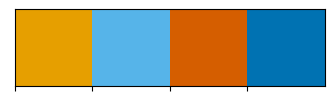

In [597]:
#sns.set_palette(('#E69F00','#56B4E9','#D55E00','#0072B2'))
sns.palplot(('#E69F00','#56B4E9','#D55E00','#0072B2'))

Top4th_pORG.20_vs_Bottom4th_pORG.20_UP
Top4th_pORG.20_vs_Bottom4th_pORG.20_DN
LiverCohort_vs_LungNotLiverCohort_UP
LiverCohort_vs_LungNotLiverCohort_DN


/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_1712/2987283057.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['comparison'] = df_plot.comparison.replace(d_rename)
/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_1712/2987283057.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['FDR.Q'] = pd.cut(df_plot.loc[:,'FDR.q.val'],bins=bins,


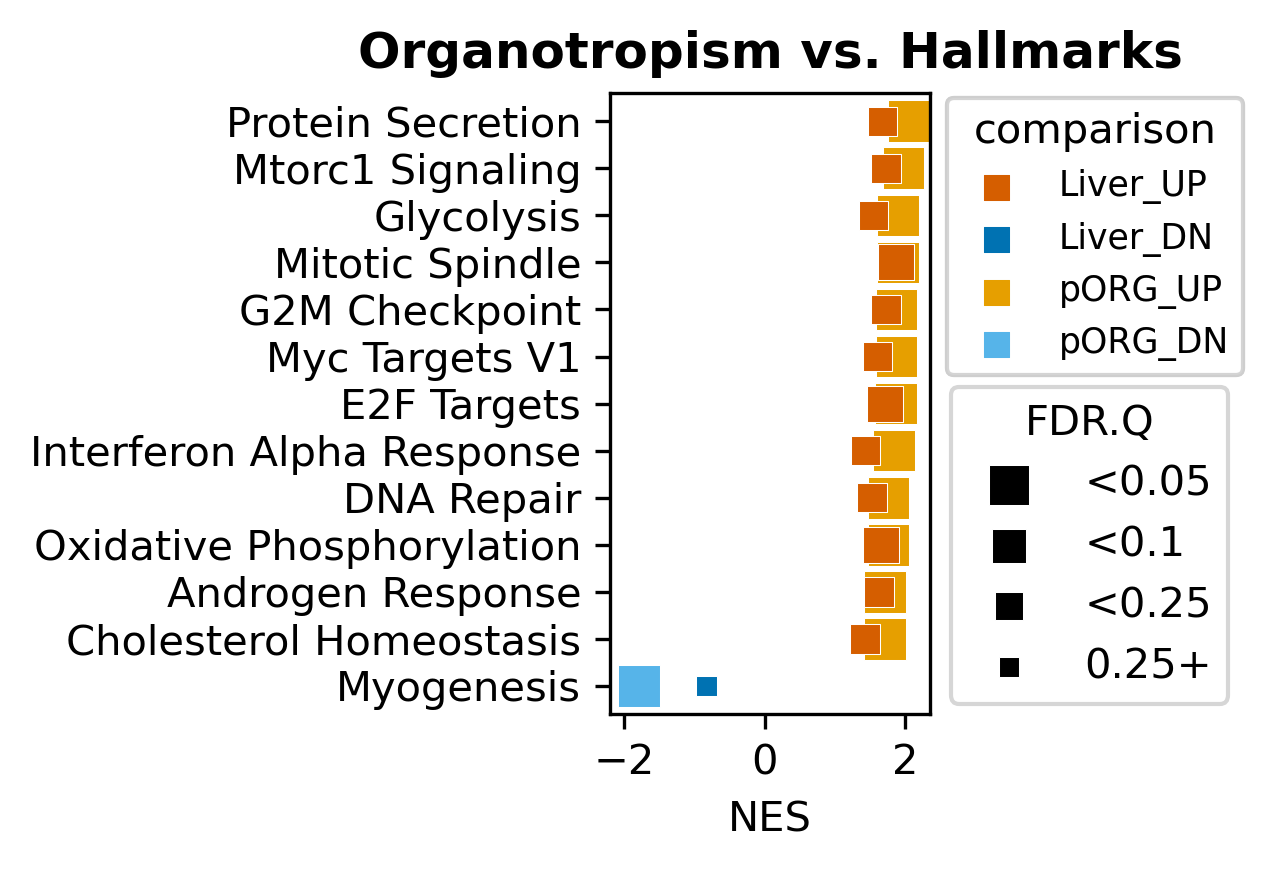

In [604]:
#bubble plots
%matplotlib inline
# organo
sorter_combined =  ['HALLMARK_MYOGENESIS' ,'HALLMARK_CHOLESTEROL_HOMEOSTASIS','HALLMARK_ANDROGEN_RESPONSE',
  'HALLMARK_OXIDATIVE_PHOSPHORYLATION', 'HALLMARK_DNA_REPAIR','HALLMARK_INTERFERON_ALPHA_RESPONSE',
  'HALLMARK_E2F_TARGETS','HALLMARK_MYC_TARGETS_V1','HALLMARK_G2M_CHECKPOINT','HALLMARK_MITOTIC_SPINDLE',
  'HALLMARK_GLYCOLYSIS','HALLMARK_MTORC1_SIGNALING','HALLMARK_PROTEIN_SECRETION',
                  ]
sns.set_palette(('#E69F00','#56B4E9','#D55E00','#0072B2'))

d_palette = {'Liver_UP': '#D55E00','Liver_DN': '#0072B2','pORG_UP': '#E69F00',
    'pORG_DN': '#56B4E9'}
ls_plot_items = ['Top4th_pORG.20_vs_Bottom4th_pORG.20',
    'LiverCohort_vs_LungNotLiverCohort']
df_plot_long = pd.DataFrame()
for s_comp in ls_plot_items:
    for s_direction in ['UP','DN']:
        s_compare =f'{s_comp}_{s_direction}'
        print(s_compare)
        #find the genes up or down
        df_plot_o = d_en[s_compare]
        df_plot_o['comparison'] = s_compare
        df_plot_long = pd.concat([df_plot_long,df_plot_o])
#plot
df_plot = df_plot_long[df_plot_long.NAME.isin(sorter_combined)]
d_rename = {'Top4th_pORG.20_vs_Bottom4th_pORG.20_UP':'pORG_UP',
       'Top4th_pORG.20_vs_Bottom4th_pORG.20_DN':'pORG_DOWN',
       'LiverCohort_vs_LungNotLiverCohort_UP':'Liver_UP',
       'LiverCohort_vs_LungNotLiverCohort_DN':'Liver_DN'}
df_plot['comparison'] = df_plot.comparison.replace(d_rename)
size_order =  ['<0.05','<0.1','<0.25','0.25+']
sizes = [100,75,50,25]
bins=[0,0.05,0.1,0.25,1]
d_size = dict(zip(size_order,sizes))
df_plot['FDR.Q'] = pd.cut(df_plot.loc[:,'FDR.q.val'],bins=bins,
                          right=True,labels=size_order)
kws = {"marker": 's', "linewidth":0.25}
fig, ax = plt.subplots(dpi=300,figsize=(3.3,3))
sns.scatterplot(data=df_plot, y='NAME',x='NES',hue='comparison',size='FDR.Q',
                ax=ax,size_order=size_order,sizes=sizes,
                **kws
            )
handles1, labels1 = zip(*[
    (plt.scatter([], [],s=color,ec='white', fc='k',marker='s',linewidth=0.25), key) for key, color in d_size.items()])
legend1 = plt.legend(handles1, labels1, title="FDR.Q",bbox_to_anchor=(1,0.56),markerscale=0.95)
handles2, labels2 = zip(*[
    (plt.scatter([], [], fc=color, **kws), key) for key, color in d_palette.items()])
legend2 = plt.legend(handles2, labels2, title="comparison",bbox_to_anchor=(1,1.02),fontsize='small')
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_title('Organotropism vs. Hallmarks',fontweight='bold')
#ax.legend(bbox_to_anchor=(1,1.05))
ax.set_ylabel('')
ticks = ax.get_yticks()
ax.set_yticks(ticks=ticks,labels=[item.replace('HALLMARK_','').replace('_',' ').title().replace('Dna','DNA') for item in reversed(sorter_combined)])
ax.set_xlim(-2.2,2.35)
plt.tight_layout()
fig.savefig('figures/GSEA_Organotropism.png')

Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_UP
Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_DN
Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_UP
Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_DN


/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_1712/1525084128.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['comparison'] = df_plot.comparison.replace(d_rename)
/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_1712/1525084128.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['FDR.Q'] = pd.cut(df_plot.loc[:,'FDR.q.val'],bins=bins,


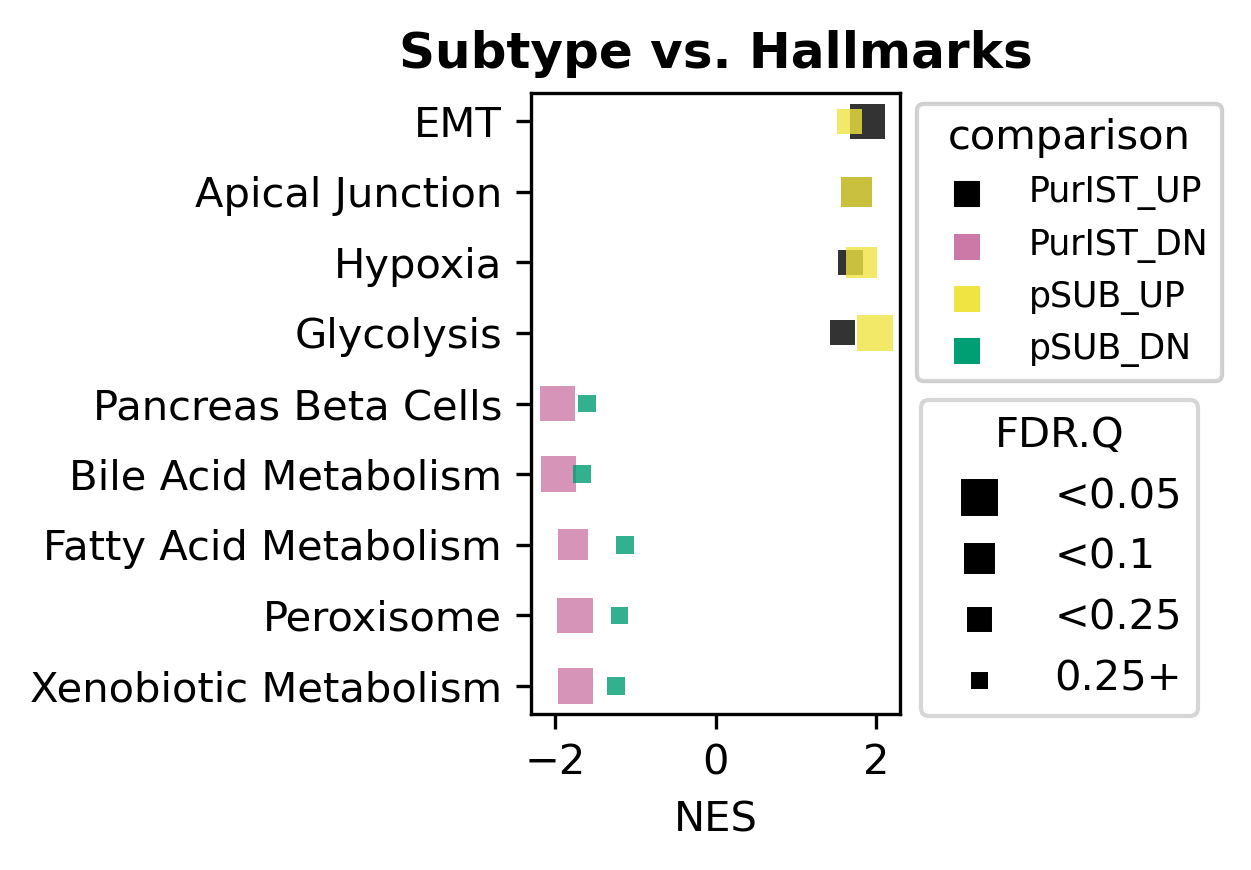

In [601]:
#subtype

sorter_combined = ['HALLMARK_XENOBIOTIC_METABOLISM',
  'HALLMARK_PEROXISOME',
  'HALLMARK_FATTY_ACID_METABOLISM',
  'HALLMARK_BILE_ACID_METABOLISM',
  'HALLMARK_PANCREAS_BETA_CELLS',
   'HALLMARK_GLYCOLYSIS',
  'HALLMARK_HYPOXIA',
    'HALLMARK_APICAL_JUNCTION',
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',]

sns.set_palette(('#000000','#CC79A7','#F0E442','#009E73'))
palette ={'PurIST_UP': '#000000',
 'PurIST_DN': '#CC79A7',
 'pSUB_UP': '#F0E442',
 'pSUB_DN': '#009E73'}
ls_plot_items = [ 'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score',
    'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4',
                 #'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score',
    ]
df_plot_long = pd.DataFrame()
for s_comp in ls_plot_items:
    for s_direction in ['UP','DN']:
        s_compare =f'{s_comp}_{s_direction}'
        print(s_compare)
        #find the genes up or down
        df_plot_o = d_en[s_compare]
        df_plot_o['comparison'] = s_compare
        df_plot_long = pd.concat([df_plot_long,df_plot_o],ignore_index=True)
#plot
df_plot = df_plot_long[df_plot_long.NAME.isin(sorter_combined)]
d_rename = {'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_UP':'pSUB_UP',
       'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4_DN':'pSUB_DN',
       'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_UP':'PurIST_UP',
       'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score_DN':'PurIST_DN'}
df_plot['comparison'] = df_plot.comparison.replace(d_rename)
size_order =  ['<0.05','<0.1','<0.25','0.25+']
sizes = [100,75,50,25]
bins=[0,0.05,0.1,0.25,1]
d_size = dict(zip(size_order,sizes))
df_plot['FDR.Q'] = pd.cut(df_plot.loc[:,'FDR.q.val'],bins=bins,
                          right=True,labels=size_order)
fig, ax = plt.subplots(dpi=300,figsize=(3.2,3))
sns.scatterplot(data=df_plot, y='NAME',x='NES',hue='comparison',size='FDR.Q',ax=ax,linewidth=0,
                marker='s',
            alpha=0.8,size_order=size_order,#palette=('#000000','#CC79A7','#F0E442','#009E73')
               )
ax.set_title('Subtype vs. Hallmarks',fontweight='bold')
handles, labels = zip(*[
    (plt.scatter([], [],s=color,ec='white', fc='k',marker='s',linewidth=0.25), key) for key, color in d_size.items()])
legend1 = plt.legend(handles, labels, title="FDR.Q",loc=0,bbox_to_anchor=(1,0.54),markerscale=0.9)
handles, labels = zip(*[
    (plt.scatter([], [], fc=color, **kws), key) for key, color in palette.items()])
legend2 = plt.legend(handles, labels, title="comparison",bbox_to_anchor=(1,1.01),fontsize='small')
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_title('Subtype vs. Hallmarks',fontweight='bold')
ax.set_ylabel('')#HALLMARK
labels_long = ax.get_yticklabels().copy()
ticks = ax.get_yticks()
labels_ = [item.replace('HALLMARK_','').replace('_',' ').title().replace('Epithelial Mesenchymal Transition','EMT') for item in reversed(sorter_combined)]
ax.set_yticks(ticks=ticks,labels=labels_)
ax.set_xlim(-2.3,2.3)
plt.tight_layout()
fig.savefig('figures/GSEA_Subtype.png')

In [561]:
dict(zip(l[1::],('#000000','#CC79A7','#F0E442','#009E73')))

{'PurIST_UP': '#000000',
 'PurIST_DN': '#CC79A7',
 'pSUB_UP': '#F0E442',
 'pSUB_DN': '#009E73'}

## figure 2  <a name="violin2"></a>
  violin plots

[contents](#contents)


In [419]:
print(df_patient.PurIST_Primary.notna().sum())
print(df_patient.loc[:,'pORG_0.2_Primary'].notna().sum())
print(df_patient.loc[:,'pSUB1e-04_Primary'].notna().sum())

216
216
216


In [420]:
print(df_patient.PurIST_Met.notna().sum()) #why only 71 mets have purist?
print(df_patient.loc[:, 'pSUB1e-04_Met'].notna().sum())
print(df_patient.loc[:, 'pORG_0.2_Met'].notna().sum())
216 + 72 - 10

71
72
72


278

In [421]:
print(df_patient.loc[:,['PurIST_Primary','PurIST_Met']].notna().all(axis=1).sum())
print(df_patient.loc[:,['pSUB1e-04_Primary','pSUB1e-04_Met']].notna().all(axis=1).sum())
print(df_patient.loc[:,['pORG_0.2_Primary','pORG_0.2_Met']].notna().all(axis=1).sum())

10
10
10


In [422]:
print(df_patient.loc[:,'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,'pORG_0.2_Primary'].notna(),'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,'pORG_0.2_Met'].notna(),'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,'PurIST_Met'].notna(),'Cohort'].notna().sum())
print(df_patient.loc[df_patient.loc[:,['pORG_0.2_Primary','pORG_0.2_Met']].notna().all(axis=1),'Cohort'].notna().sum())
75 + 38 - 7

165
75
38
37
7


106

## per specimen

In [447]:
d_colorblind_g ={'Liver': '#d55e00',
 'Lung': '#0072b2',
 'high': '#e69f00',
 'low': '#56b4e9',
 'basal-like': 'dimgray',
 'classical': '#cc79a7',
 'high pSUB': '#f0e442',
 'low pSUB': '#d55e00'}

population match
score pORG_0.2_All
population pORG_0.2_All
72
216
False
specimen data 288
score pSUB1e-04_All
population pORG_0.2_All
72
216
False
specimen data 288
score PurIST_All
population pORG_0.2_All
72
216
False
specimen data 288


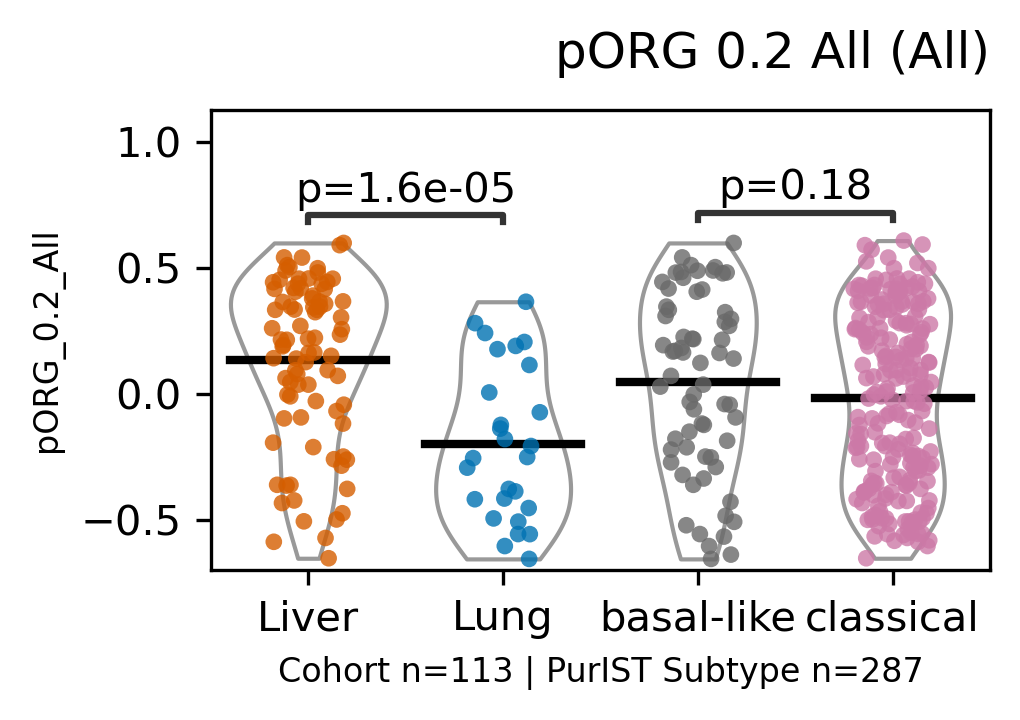

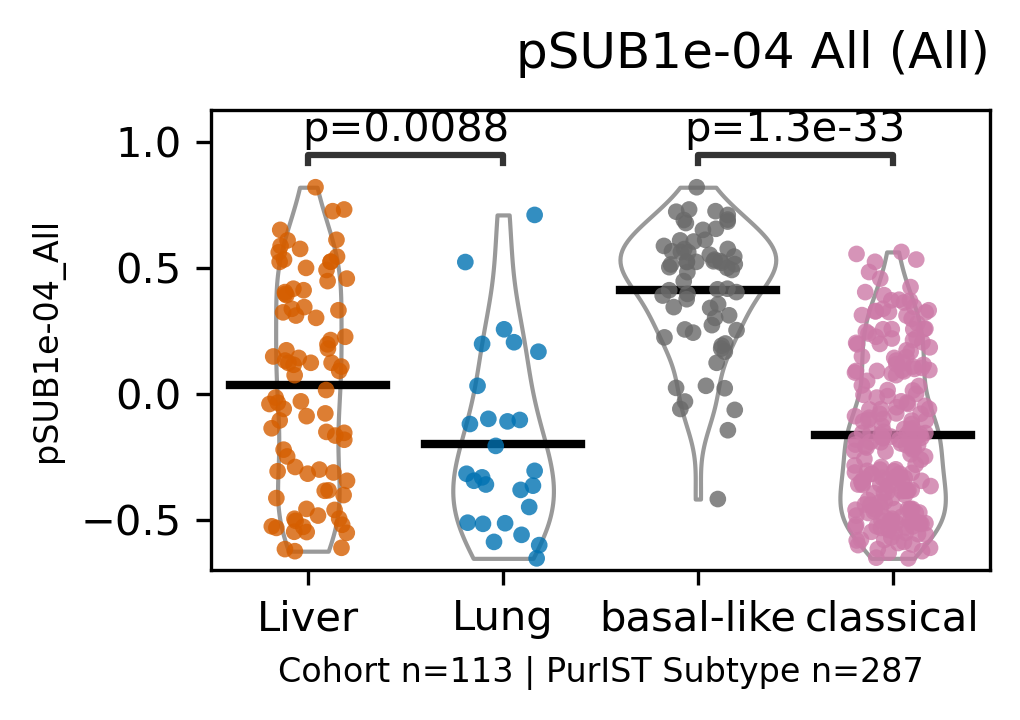

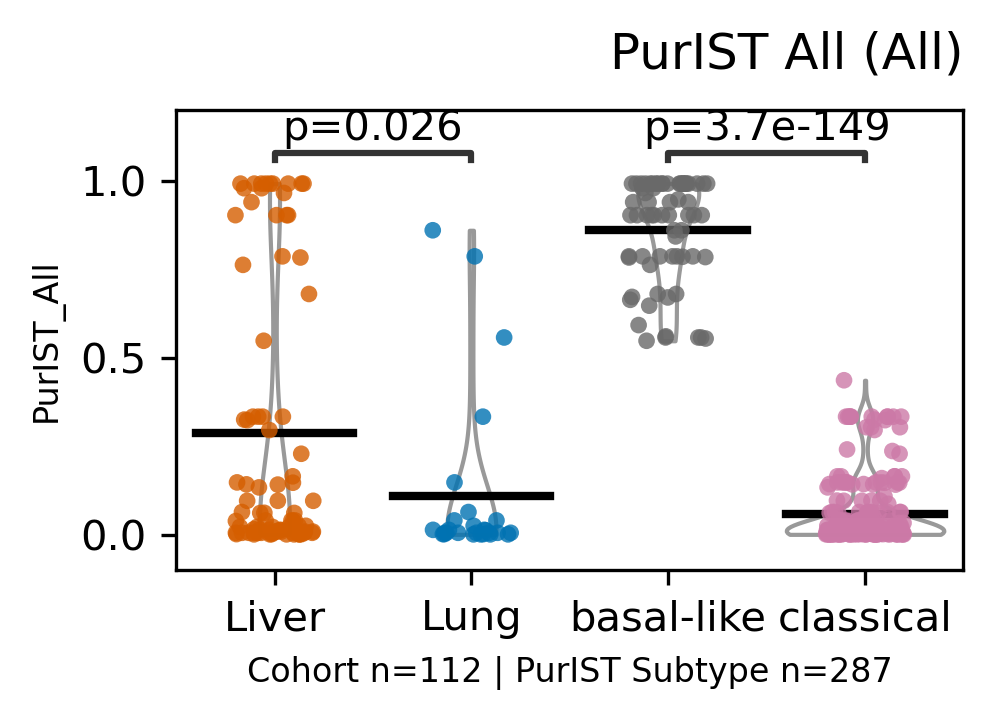

In [448]:
#per specimen
#Can you redo this removing the non lung and non liver mets in their respective cohorts:
importlib.reload(util)
import warnings
s_out = '20230905_Patient_Metadata.csv'
df_patient= pd.read_csv(s_out,index_col=0)
df_patient['PurIST_allPrimary'] = df_patient.PurIST_Primary.copy()
df_patient['PurIST_allMet'] = df_patient.PurIST_Met.copy()
s_stats = 'mean'
d_order =  {'Cohort':['Liver','Lung'],
            'PurIST Subtype':['basal-like','classical']}
lls_score = [['pORG_0.2_All', 'pSUB1e-04_All','PurIST_All']]
for ls_score in lls_score:
    ls_population = ['match']
    for s_population in ls_population:
        print(f'population {s_population}')
        if s_population.find('_Met')>-1:
            lb_met = [True,False]
        else:
            lb_met = [False]
        for b_met in lb_met:
            for s_score in ls_score:
                print(f'score {s_score}')
                if s_population == 'match':
                    s_population = s_score
                print(f'population {s_population}')

                met_index = df_patient.loc[:,['pORG_0.2_allMet','pSUB1e-04_allMet']].dropna(how='any').index #72
                df_met = df_patient.loc[met_index,['Public_Patient_ID','pORG_0.2_allMet','pSUB1e-04_allMet','PurIST_allMet']] #72
                df_met['Public_Specimen_ID'] = [item + f"-Met" for item in df_met.Public_Patient_ID]
                print(len(df_met)) 
                #df_pri = pd.concat([df_pri,df_met],axis=0,ignore_index=True)
                pri_index = df_patient.loc[:,['pORG_0.2_allPrimary','pSUB1e-04_allPrimary']].dropna(how='any').index #72
                df_primary = df_patient.loc[pri_index,['Public_Patient_ID','pORG_0.2_allPrimary','pSUB1e-04_allPrimary','PurIST_allPrimary']] #216
                df_primary['Public_Specimen_ID'] = [item + f"-Primary" for item in df_primary.Public_Patient_ID]
                print(len(df_primary))   
                df_pri = pd.concat([df_met,df_primary],ignore_index=True)
                print(df_pri.Public_Specimen_ID.duplicated().any())
                print(f'specimen data {len(df_pri)}')
                df_pri['pORG_0.2_All'] = df_pri.loc[:,'pORG_0.2_allPrimary'].fillna(df_pri.loc[:,'pORG_0.2_allMet'])
                df_pri['pSUB1e-04_All'] = df_pri.loc[:,'pSUB1e-04_allPrimary'].fillna(df_pri.loc[:,'pSUB1e-04_allMet'])
                df_pri['PurIST_All'] = df_pri.PurIST_allPrimary.fillna(df_pri.PurIST_allMet)
                df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] > 0.5,'PurIST Subtype'] = 'basal-like'
                df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] <= 0.5,'PurIST Subtype'] = 'classical'
                df_pri['Cohort'] = df_pri.Public_Patient_ID.map(dict(zip(df_patient.Public_Patient_ID,df_patient.Cohort)))
                df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_score,s_stats)
                fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_score,order,
                                                           d_colorblind_g,s_population,b_correct=True,figsize=(3.5,2.5))
                plt.ylim(-0.7, 1.13)
                if s_score.find('PurIST') > -1:
                    plt.ylim(-0.1, 1.2)
                fig.savefig(f'figures/violinplot_fig2_spec_{s_score}_{s_population.split("_")[-1]}_mets_only{b_met}.png')
        

population match
score pORG_0.2_All
population pORG_0.2_All
Primaries and Mets
score pSUB1e-04_All
Primaries and Mets
score PurIST_All
Primaries and Mets
population pORG_0.2_Met
score pORG_0.2_All
Primaries and Mets
mets
score pSUB1e-04_All
Primaries and Mets
mets
score PurIST_All
Primaries and Mets
mets
score pORG_0.2_All
Primaries and Mets
mets
score pSUB1e-04_All
Primaries and Mets
mets
score PurIST_All
Primaries and Mets
mets
population pORG_0.2_Primary
score pORG_0.2_All
Primaries and Mets
primaries
score pSUB1e-04_All
Primaries and Mets
primaries
score PurIST_All
Primaries and Mets
primaries


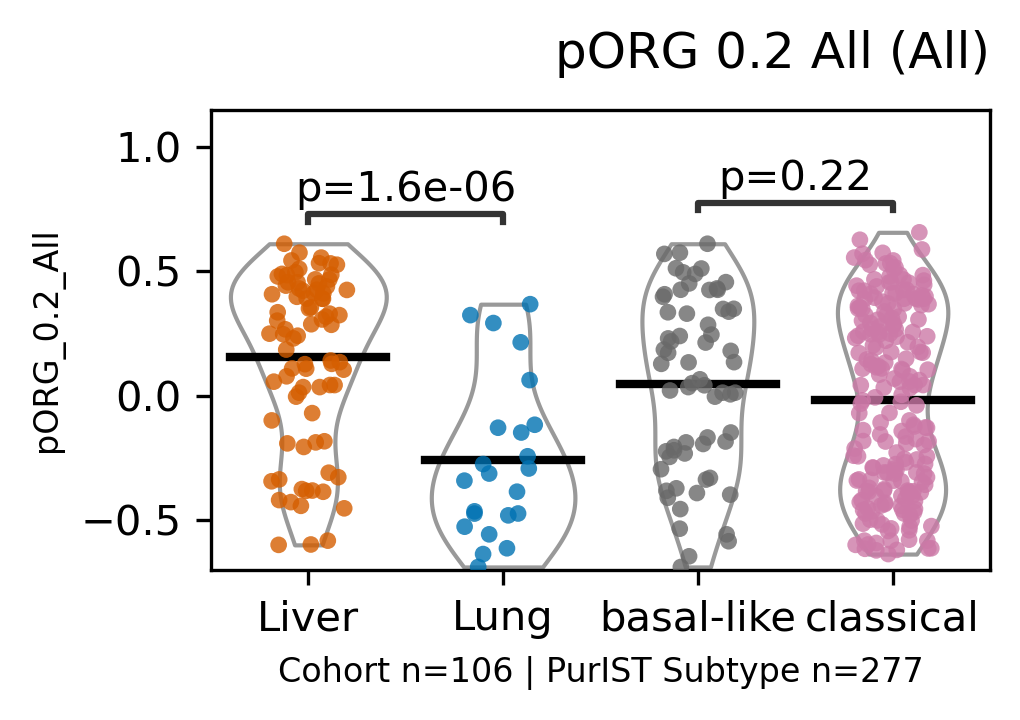

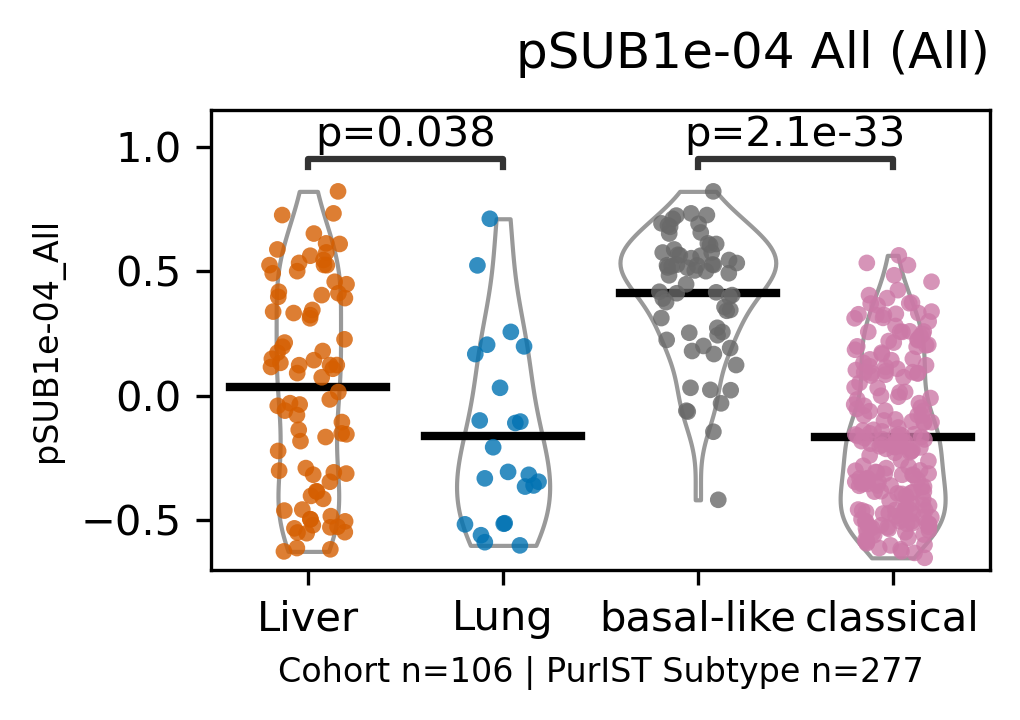

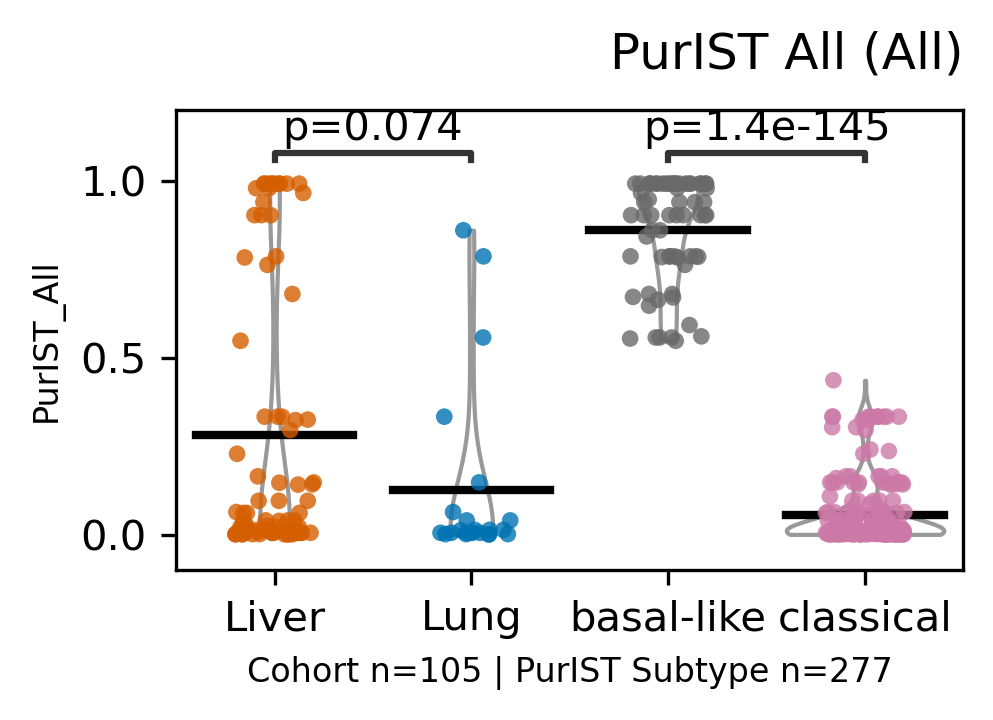

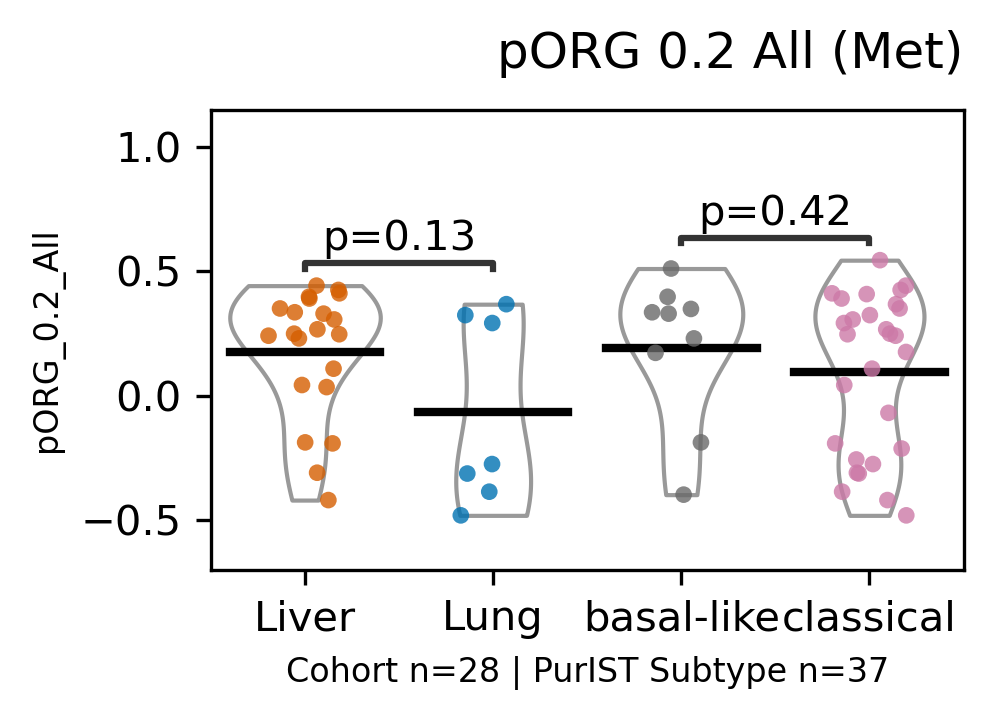

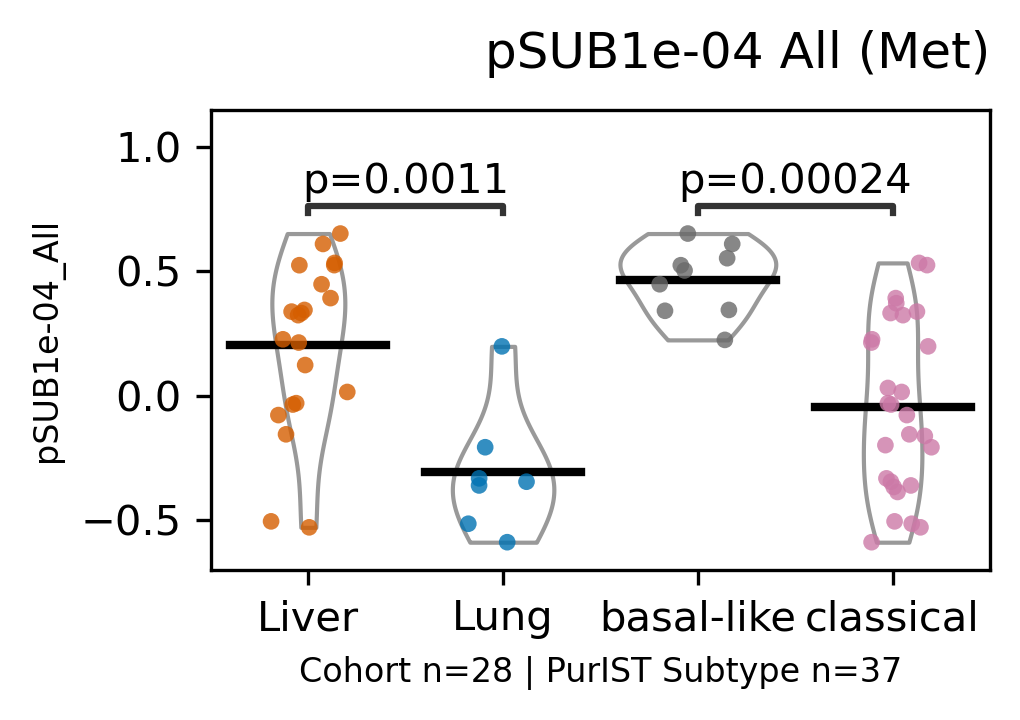

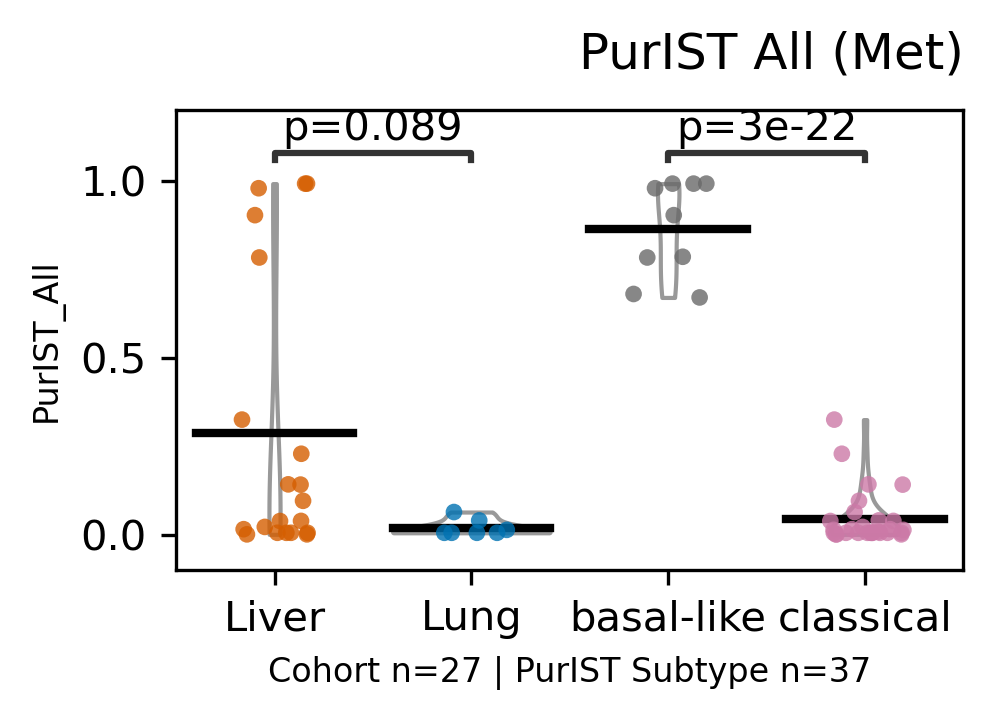

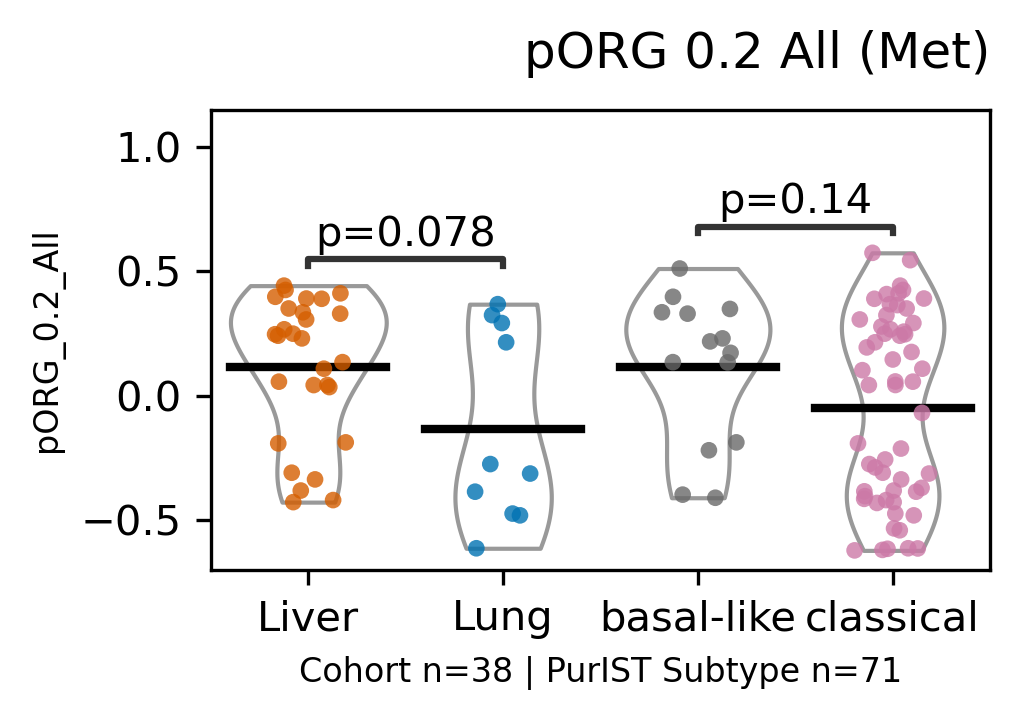

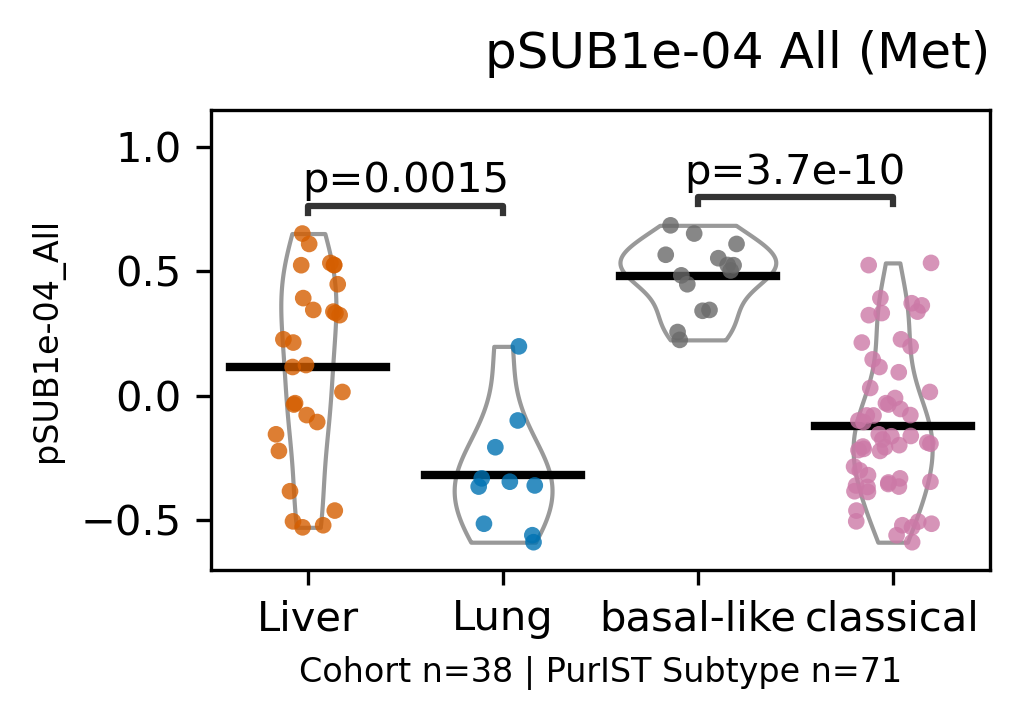

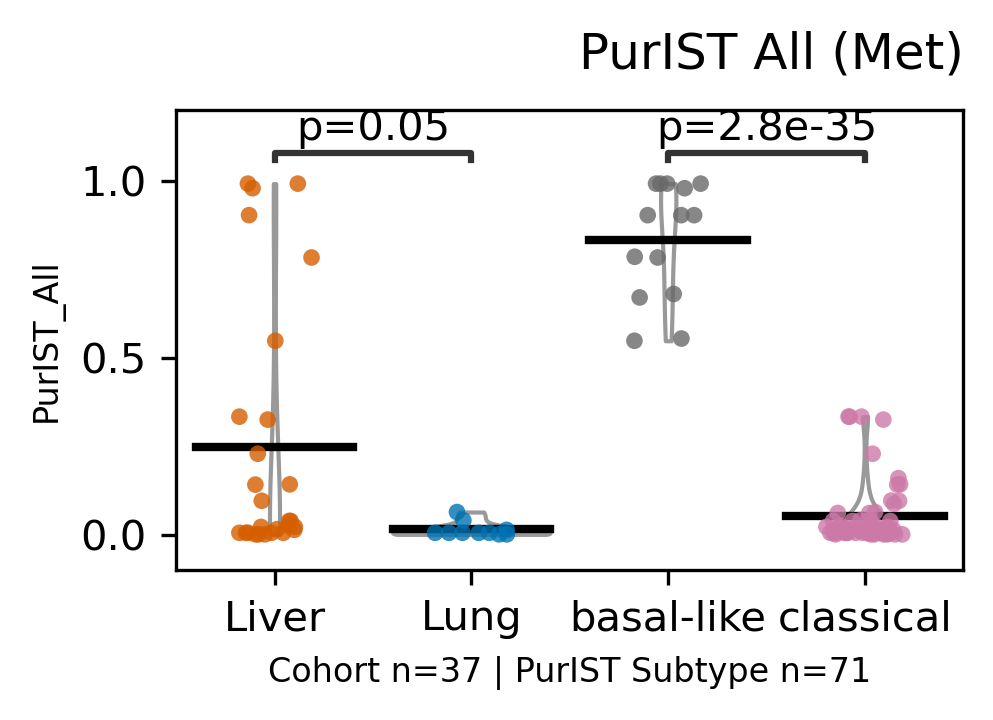

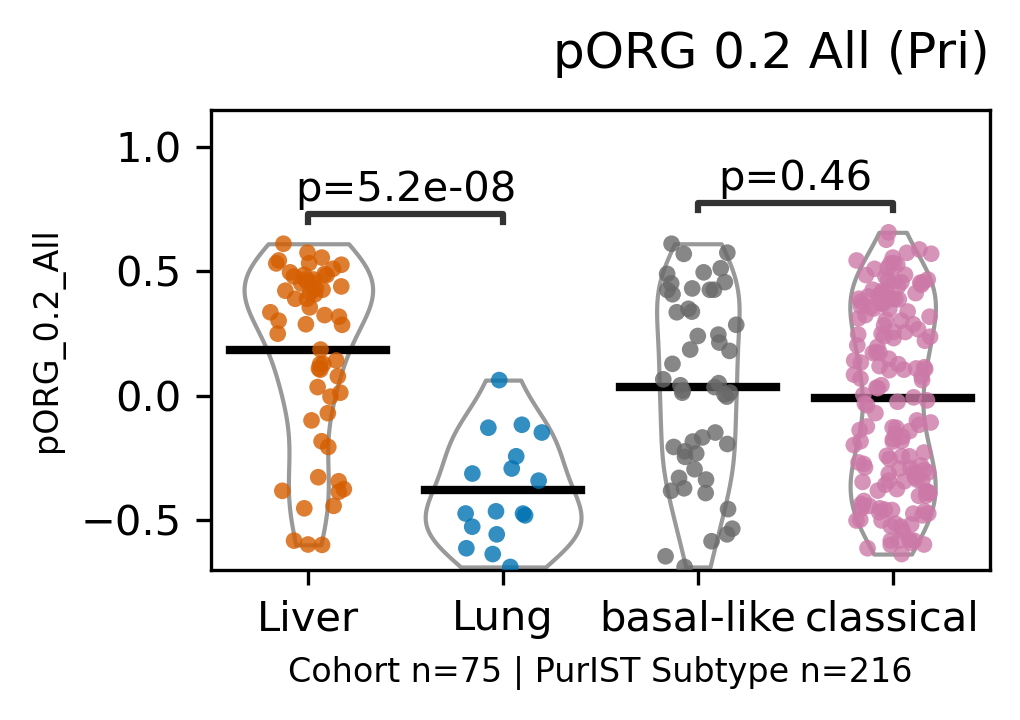

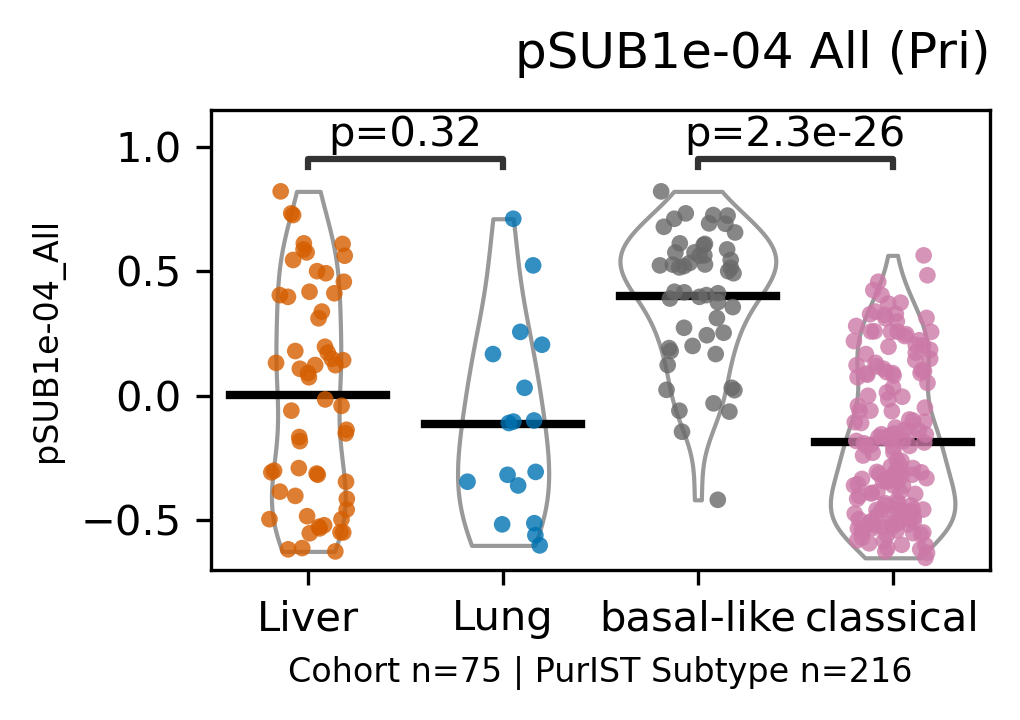

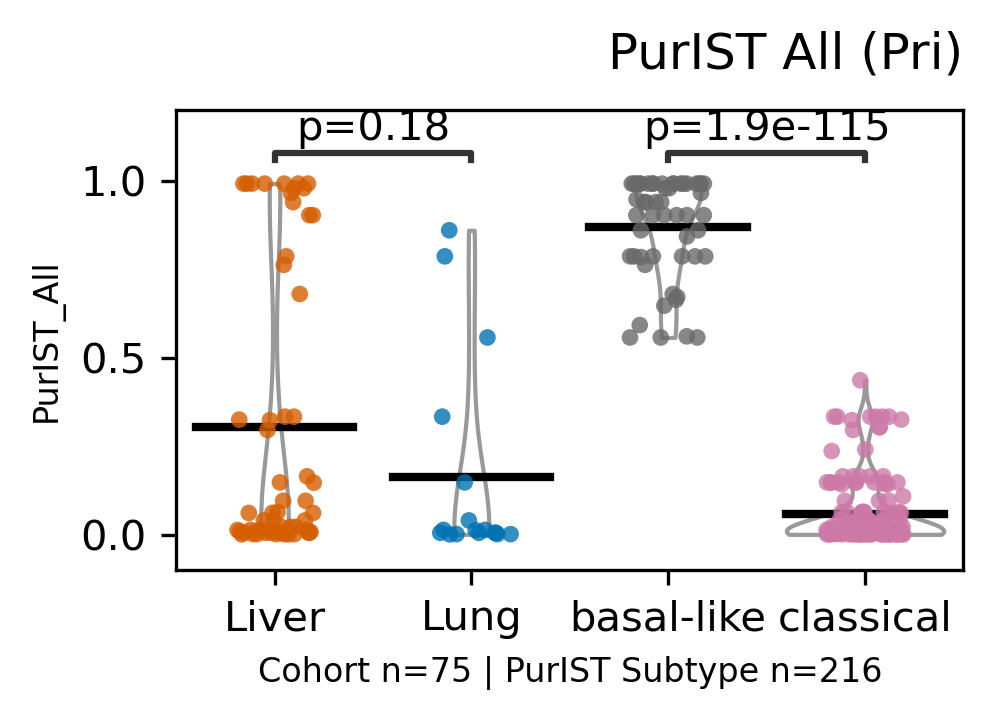

In [450]:
#lper patient
#Can you redo this removing the non lung and non liver mets in their respective cohorts:
importlib.reload(util)
import warnings
s_out = '20230828_Patient_Metadata.csv'
df_patient= pd.read_csv(s_out,index_col=0)
s_stats = 'mean'
d_order =  {'Cohort':['Liver','Lung'],
            'PurIST Subtype':['basal-like','classical']}
lls_score = [#['pORG_0.2_Primary','pSUB1e-04_Primary','PurIST_Primary'],
           ['pORG_0.2_All', 'pSUB1e-04_All','PurIST_All'],
          #['pORG_0.2_Met','pSUB1e-04_Met','PurIST_Met'],
          ]
for ls_score in lls_score:
    if ls_score[0].find('All') > -1:
        ls_population = ['match','pORG_0.2_Met','pORG_0.2_Primary']
    elif ls_score[0].find('Met') > -1:
        ls_population = ['pORG_0.2_Met']
    else:
        ls_population = ['pORG_0.2_Primary']
    for s_population in ls_population:
        print(f'population {s_population}')
        if s_population.find('_Met')>-1:
            lb_met = [True,False]
        else:
            lb_met = [False]
        for b_met in lb_met:
            for s_score in ls_score:
                print(f'score {s_score}')
                if s_population == 'match':
                    s_population = s_score
                    print(f'population {s_population}')
                if s_score.find('_All')> -1: #need to calculate and add "all" scores
                    print('Primaries and Mets')
                    df_pri = df_patient.copy()
                    df_pri['PurIST_allPrimary'] = df_pri.PurIST_Primary.copy()
                    df_pri['PurIST_allMet'] = df_pri.PurIST_Met.copy()
                    for s_score_all in ['PurIST','pORG_0.2','pSUB1e-04']:
                        df_whole = pd.DataFrame(columns=df_pri.columns)
                        for s_all in [f'{s_score_all}_allPrimary',f'{s_score_all}_allMet']:
                            #select the mets or primaries (this will prioritze primary over met for matched)
                            df_half = df_pri[df_pri.loc[:,s_all.replace(s_score_all,'pORG_0.2')].notna()].copy()
                            #only fill in the non duplicate 
                            df_half = df_half[~df_half.Public_Patient_ID.isin(df_whole.Public_Patient_ID)].copy()
                            df_half.rename({s_all:f'{s_score_all}_All'},axis=1,inplace=True)
                            #df_whole.index = [str(item) + 'a' for item in df_whole.index]
                            with warnings.catch_warnings():
                                warnings.simplefilter(action='ignore', category=FutureWarning)
                                df_whole = pd.concat([df_whole,df_half],axis=0,ignore_index=True)
                        #print(len(df_whole))
                        df_pri = df_pri.merge(df_whole.loc[:,['Public_Patient_ID',f'{s_score_all}_All']],on='Public_Patient_ID',how='left',suffixes=('','_'))
                else:
                    df_pri = df_patient.copy()
                if s_population.find('_Met')> -1:
                    print('mets')
                    if b_met: #select mets specific to cohort
                        df_pri = df_pri[(df_pri.loc[:,s_population].notna()) & (df_patient.Specimen_Site_Met.isin(['Liver','Lung']))].copy()
                    else: #select mets
                        df_pri = df_pri[(df_pri.loc[:,s_population].notna())].copy()
                elif s_population.find('_Primary')> -1: #select primaries
                    print('primaries')
                    df_pri = df_pri[df_pri.loc[:,s_population].notna()].copy()
                df_pri['PurIST_All'] = df_pri.PurIST_Primary.fillna(df_pri.PurIST_Met)
                df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] > 0.5,'PurIST Subtype'] = 'basal-like'
                df_pri.loc[df_pri.loc[:,f'PurIST_{s_score.split("_")[-1]}'] <= 0.5,'PurIST Subtype'] = 'classical'
                df_pri.loc[df_pri.Public_Patient_ID.duplicated(),'PurIST Subtype'] = np.nan
                df_both,d_pval,order = util.violin_stats2(df_pri,d_order,s_score,s_stats)
                fig,pvalues,corrected = util.plot_violins2(df_both,d_pval,d_order,s_stats,s_score,order,
                                                           d_colorblind_g,s_population,b_correct=True,figsize=(3.5,2.5))
                plt.ylim(-0.7, 1.15)
                if s_score.find('PurIST') > -1:
                    plt.ylim(-0.1, 1.2)
                fig.savefig(f'figures/violinplot_fig2_{s_score}_{s_population.split("_")[-1]}_mets_only{b_met}.png')
            #break

In [ ]:
#old bar plots of GSEA
# #subtype
# sorter_combined = ['HALLMARK_PEROXISOME','HALLMARK_XENOBIOTIC_METABOLISM', #0.05
#    'HALLMARK_PANCREAS_BETA_CELLS', 'HALLMARK_BILE_ACID_METABOLISM',
#     'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','HALLMARK_GLYCOLYSIS',
#                   ]
# sorter_combined = ['HALLMARK_XENOBIOTIC_METABOLISM',
#   'HALLMARK_PEROXISOME',
#   'HALLMARK_FATTY_ACID_METABOLISM',
#   'HALLMARK_BILE_ACID_METABOLISM',
#   'HALLMARK_PANCREAS_BETA_CELLS','HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
#   'HALLMARK_APICAL_JUNCTION',
#   'HALLMARK_HYPOXIA',
#   'HALLMARK_GLYCOLYSIS']

# #sorter_all
# b_manual = True #True #False
# sorter_all = {}
# #Rosie ask: rank by NES in pORG
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
# d_p = {}
# es_add = set()#set(['HALLMARK_MYOGENESIS'])
# s_pval = 'FDR.q.val'#'NES'#'NOM.p.val'#
# alpha = 0.15#0.2#
# df_all = pd.DataFrame()
# es_marker = set()
# ls_plot_items = [#'basal-like_vs_classical',
#     #'Top4th_pSUB.1eNeg5_vs_Bottom4th_pSUB.1eNeg5',
#     'Top4th_pSUB.1eNeg4_vs_Bottom4th_pSUB.1eNeg4',
#     'Top4th_PurIST.Score_vs_Bottom4th_PurIST.Score'
#                 ]

# for s_comp in ls_plot_items:
#     df_plot_long = pd.DataFrame()
#     df_plot_long2 = pd.DataFrame()
#     for s_direction in ['UP','DN']:
#         s_compare =f'{s_comp}_{s_direction}'
#         print(s_compare)
#         #find the genes up or down
#         df_plot_o = d_en[s_compare][(d_en[s_compare].loc[:,s_pval]<alpha)].sort_values(by='NES',ascending=False)
#         if s_direction == 'DN':
#             print('down')
#             #print(len(df_plot))
#             sorter = df_plot_o.sort_values(by='NES',ascending=False).NAME.tolist()
#         else:
#             print('up')
#             #print(len(df_plot))
#             sorter = df_plot_o.sort_values(by='NES').NAME.tolist()
#         #override
#         if b_manual:
#             df_plot = d_en[s_compare].loc[d_en[s_compare].NAME.isin(sorter_combined),ls_columns]
#         else:
#             df_plot = df_plot_o
#         print(len(df_plot))
#         df_plot_long = pd.concat([df_plot_long,df_plot])
#         #df_plot_long2 = pd.concat([df_plot_long2,d_en[s_compare]])
#         es_marker = es_marker.union(set(df_plot.NAME)).union(es_add)
#         sorter_all.update({s_compare:sorter})
#     #'''
#     df_plot_long = df_plot_long.sort_values(by='NES')
#     df_plot_long['comparison'] = s_comp
#     #df_plot_long2 = df_plot_long2.sort_values(by='NES',ascending=False)
#     #print(df_plot_long2.head())
#     df_all = pd.concat([df_all,df_plot_long])
#     d_p.update({s_comp:df_plot_long.NAME.unique()})
#     #break
# #'''
# df_all.NAME = df_all.NAME.astype('category')
# df_all.NAME = df_all.NAME.cat.set_categories(sorter_combined)
# df_plot_bar = df_all[df_all.NAME.isin(sorter_combined)].sort_values(by=['comparison','NAME'])
# df_plot_bar['FDR_color'] = rescale(df_plot_bar.loc[:,'FDR.q.val'])
# #erase low FDR.q
# #df_plot_bar.loc[(abs(df_plot_bar.loc[:,'NES']) < 1.5) | (df_plot_bar.loc[:,'FDR.q.val'] > 0.15),'NES'] = 0
# fig, ax = plt.subplots(dpi=200)
# my_cmap = plt.get_cmap("Reds_r")
# height=0.4
# for idx, s_comp in enumerate(ls_plot_items):
#     df_comp = df_plot_bar[df_plot_bar.comparison==s_comp]
#     df_comp.set_index('NAME',inplace=True)
#     if idx == 0:
#         indices = np.arange(len(df_comp.index))
#         ax.barh(y=indices+height/2, width=df_comp.loc[sorter_combined,'NES'],height=height,
#             color=[my_cmap(item) for item in df_comp.FDR_color],label=s_comp,
#            )
#     else: 
#         ax.barh(y=indices-height/2, width=df_comp.loc[sorter_combined,'NES'],height=height,hatch='//',
#             color=[my_cmap(item) for item in df_comp.FDR_color],label=s_comp,
#            )
#     ax.set_yticks(range(len(df_comp.index)))
#     ax.set_yticklabels(df_comp.index)
# norm = mpl.colors.Normalize(vmin=df_plot_bar.loc[:,'FDR.q.val'].min(),vmax=df_plot_bar.loc[:,'FDR.q.val'].max())
# #norm = mpl.colors.Normalize(vmin=0,vmax=0.2)
# mappable = mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap)
# fig.colorbar(mappable=mappable,ax=ax,label='FDR.q.val')
# ax.set_title('Subtype')
# handles = [mpl.patches.Patch(facecolor='lightgray', edgecolor='black',
#                          label=d_labels[ls_plot_items[0]]),
#                   mpl.patches.Patch(facecolor='lightgray', edgecolor='black',
#                          label=d_labels[ls_plot_items[1]],#label='Top vs Bottom Quartile by PurIST',
#                                     hatch='//')]
# ax.legend(handles=handles,bbox_to_anchor = (1.25,1),markerscale=1,title='Comparison')
# ax.set_xlabel('NES')
# #'''

# # organo
# sorter_combined =  ['HALLMARK_MYOGENESIS' ,'HALLMARK_CHOLESTEROL_HOMEOSTASIS',
#   'HALLMARK_ANDROGEN_RESPONSE',
#   'HALLMARK_OXIDATIVE_PHOSPHORYLATION',
#   'HALLMARK_DNA_REPAIR',
#   'HALLMARK_INTERFERON_ALPHA_RESPONSE',
#   'HALLMARK_E2F_TARGETS',
#   'HALLMARK_MYC_TARGETS_V1',
#   'HALLMARK_G2M_CHECKPOINT',
#   'HALLMARK_MITOTIC_SPINDLE',
#   'HALLMARK_GLYCOLYSIS',
#   'HALLMARK_MTORC1_SIGNALING',
#   'HALLMARK_PROTEIN_SECRETION',
#                   ]
# b_manual = True #True #False
# sorter_all = {}
# #Rosie ask: rank by NES in pORG
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
# d_p = {}
# es_add = set()#set(['HALLMARK_MYOGENESIS'])
# s_pval = 'FDR.q.val'#'NES'#'NOM.p.val'#
# alpha = 0.05#0.2#
# df_all = pd.DataFrame()
# es_marker = set()
# ls_plot_items = ['Top4th_pORG.20_vs_Bottom4th_pORG.20',
#     'LiverCohort_vs_LungNotLiverCohort']

# for s_comp in ls_plot_items:
#     df_plot_long = pd.DataFrame()
#     df_plot_long2 = pd.DataFrame()
#     for s_direction in ['UP','DN']:
#         s_compare =f'{s_comp}_{s_direction}'
#         print(s_compare)
#         #find the genes up or down
#         df_plot_o = d_en[s_compare][(d_en[s_compare].loc[:,s_pval]<alpha)].sort_values(by='NES',ascending=False)
#         if s_direction == 'DN':
#             print('down')
#             #print(len(df_plot))
#             sorter = df_plot_o.sort_values(by='NES',ascending=False).NAME.tolist()
#         else:
#             print('up')
#             #print(len(df_plot))
#             sorter = df_plot_o.sort_values(by='NES').NAME.tolist()
#         #override
#         if b_manual:
#             df_plot = d_en[s_compare].loc[d_en[s_compare].NAME.isin(sorter_combined),ls_columns]
#         else:
#             df_plot = df_plot_o
#         print(len(df_plot))
#         df_plot_long = pd.concat([df_plot_long,df_plot])
#         #df_plot_long2 = pd.concat([df_plot_long2,d_en[s_compare]])
#         es_marker = es_marker.union(set(df_plot.NAME)).union(es_add)
#         sorter_all.update({s_compare:sorter})
#     #'''
#     df_plot_long = df_plot_long.sort_values(by='NES')
#     df_plot_long['comparison'] = s_comp
#     #df_plot_long2 = df_plot_long2.sort_values(by='NES',ascending=False)
#     #print(df_plot_long2.head())
#     df_all = pd.concat([df_all,df_plot_long])
#     d_p.update({s_comp:df_plot_long.NAME.unique()})
#     #break
# #'''
# df_all.NAME = df_all.NAME.astype('category')
# df_all.NAME = df_all.NAME.cat.set_categories(sorter_combined)
# df_plot_bar = df_all[df_all.NAME.isin(sorter_combined)].sort_values(by=['comparison','NAME'])
# df_plot_bar['FDR_color'] = rescale(df_plot_bar.loc[:,'FDR.q.val'])
# #erase low FDR.q
# #df_plot_bar.loc[(abs(df_plot_bar.loc[:,'NES']) < 1.5) | (df_plot_bar.loc[:,'FDR.q.val'] > 0.15),'NES'] = 0
# fig, ax = plt.subplots(dpi=200)
# my_cmap = plt.get_cmap("Reds_r")
# height=0.4
# for idx, s_comp in enumerate(ls_plot_items):
#     df_comp = df_plot_bar[df_plot_bar.comparison==s_comp]
#     df_comp.set_index('NAME',inplace=True)
#     if idx == 0:
#         indices = np.arange(len(df_comp.index))
#         ax.barh(y=indices+height/2, width=df_comp.loc[sorter_combined,'NES'],height=height,
#             color=[my_cmap(item) for item in df_comp.FDR_color],label=s_comp,
#            )
#     else: 
#         ax.barh(y=indices-height/2, width=df_comp.loc[sorter_combined,'NES'],height=height,hatch='//',
#             color=[my_cmap(item) for item in df_comp.FDR_color],label=s_comp,
#            )
#     ax.set_yticks(range(len(df_comp.index)))
#     ax.set_yticklabels(df_comp.index)
# norm = mpl.colors.Normalize(vmin=df_plot_bar.loc[:,'FDR.q.val'].min(),vmax=df_plot_bar.loc[:,'FDR.q.val'].max())
# #norm = mpl.colors.Normalize(vmin=0,vmax=0.2)
# mappable = mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap)
# fig.colorbar(mappable=mappable,ax=ax,label='FDR.q.val')
# ax.set_title('Organotropism')
# handles = [mpl.patches.Patch(facecolor='lightgray', edgecolor='black',
#                          label=d_labels[ls_plot_items[0]]),
#                   mpl.patches.Patch(facecolor='lightgray', edgecolor='black',
#                          label=d_labels[ls_plot_items[1]],#label='Top vs Bottom Quartile by PurIST',
#                                     hatch='//')]
# ax.legend(handles=handles,bbox_to_anchor = (1.25,1),markerscale=1,title='Comparison')
# ax.set_xlabel('NES')
# #'''
